# **Global**

In [ ]:
!pip install pathfinding
!pip install stable-baselines
!apt install ffmpeg

     |████████████████████████████████| 245kB 5.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
!pip install tensorflow1.14.0

ERROR: Could not find a version that satisfies the requirement tensorflow1.14.0 (from versions: none)
ERROR: No matching distribution found for tensorflow1.14.0


In [ ]:
# General
import time
import random
import string
import numpy as np
from collections import deque
import copy
import os
import glob

# Connection
from telnetlib import Telnet

# Pathfinding
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.finder.dijkstra import DijkstraFinder

# Q-Learning
%tensorflow_version 1.x
import gym
from gym import spaces
from gym import wrappers
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import ACKTR

# Keras
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam

# Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline 

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
# Global variables
nMaps = 20                          # number of maps to save
listOfMaps = deque(maxlen=nMaps)    # a list of the latest maps
tempMap = deque(maxlen=1)
host = 'margot.di.unipi.it'
serverPort = 8421
chatPort = 8422
train_timer = 0.005
timer = 0.5
ai_timer = 0.3

# version
#{group-number}-{ai-version}
ai_version = '0.52'

# **Communication**




In [ ]:
class CommunicationHandler:

  def __init__(self, host, port):
    self.host = host
    self.port = port
    self.tn = self.connect(host, port)

    self.lastAction = time.time()
    self.timer = timer  # how many seconds do I have to wait before performing another action?


  def connect(self, host, port):
    tn = Telnet(host, port)
    # TODO: controlla connessione
    print('Connected!')
    return tn


  def createGame(self, matchName, params=''):
    #if ('T' in params):
    #  self.timer = train_timer

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Creating the new game
    command = 'NEW ' + matchName + ' ' + params + '\n'
    self.tn.write(command.encode('utf8'))
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[CREATE] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res


  def joinGame(self, matchName, playerName, train=False, observer=False):
    self.matchName = matchName
    self.playerName = playerName
    command = matchName + ' JOIN ' + playerName + ' AI _ AI0-' + ai_version + '\n'
    if (observer):
      command = matchName + ' JOIN ' + playerName + ' O -\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    if (train or observer):
      self.timer = train_timer
    else:
      self.timer = ai_timer

    # Joining game
    self.tn.write(command.encode('utf8'))
    # TODO: ADD CONTROLS
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[JOIN] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res


  def startGame(self):
    command = self.matchName + ' START\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Starting game
    self.tn.write(command.encode('utf8'))
    # TODO: ADD CONTROLS
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[START] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res
    

  def getMap(self):
    command = self.matchName + ' LOOK' + '\n'
    #self.tn.read_very_lazy()

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Getting the map
    self.tn.write(command.encode('utf8'))
    message = self.tn.read_until('»\n'.encode('utf8')).decode('utf8')
    if ('ERROR' in message):
      return -1
    res = message.split('OK LONG\n')

    # Update last action performed's timestamp
    self.lastAction = time.time()

    tempMap.append(res[1])
    return toMatrix(res[1])


  def getStatus(self):
    command = self.matchName + ' STATUS' + '\n'
    #self.tn.read_very_lazy()

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Getting the status
    self.tn.write(command.encode('utf8'))
    message = self.tn.read_until('»\n'.encode('utf8')).decode('utf8')
    if ('ERROR' in message):
      return -1
    res = message.split('OK LONG\n')

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res[1].split('«ENDOFSTATUS»')[0]


  def move(self, direction): #command eg: MOVE S
    command = self.matchName + ' MOVE ' + direction + '\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Moving
    self.tn.write(command.encode('utf8'))
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[MOVE-' + direction + '] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res


  def shoot(self, direction): #command eg: MOVE S
    command = self.matchName + ' SHOOT ' + direction + '\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Shooting
    self.tn.write(command.encode('utf8'))
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split('\n')[0].split(' ')
    print('[SHOOT-' + direction + '] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res
    
  def sendNOP(self): #NOTA: NON FUNZIONA! 10s delay!
    command = self.matchName + ' NOP\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Send NOP
    self.tn.write(command.encode('utf8'))
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[NOP] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res

  def accuse(self, playerName):
    command = self.matchName + ' ACCUSE ' + playerName + '\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Accusing
    self.tn.write(command.encode('utf8'))
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[ACCUSE-' + playerName + '] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res

  def judge(self, playerName, nature):
    command = self.matchName + ' JUDGE ' + playerName + ' ' + nature + '\n'

    # sleep until I can send another command
    currentTime = time.time()
    sleepingTime = self.timer - (currentTime - self.lastAction)
    if (sleepingTime<0):
      sleepingTime=0
    time.sleep(sleepingTime)

    # Judge
    self.tn.write(command.encode('utf8'))
    res = self.tn.read_until('\n'.encode('utf8')).decode('utf8').split(' ')
    print('[JUDGE-' + playerName + '] ' + res[0])

    # Update last action performed's timestamp
    self.lastAction = time.time()
    return res



# Chat System

In [ ]:
# phrase list
CHAT_DICTIONARY = {
  'salute': ['hi', 'hello', 'hi there', 'hello guys', 'good evening', 'glhf', 'hello there', 'don\'t feed please'],
  'victory' : ['too easy', 'nice game!', 'ggez', 'ez', 'another one?'],
  'defeat' : ['whatever', 'ggwp', 'report my team please', 'wtf', 'hacker!!', 'LAAAAAG', 'great job', 'another one?'],
  'attack' : ['let\'s attack!', 'let\'s go forward', 'attack them!', 'let\'s go guys!'],
  'defend' : ['come at me!', 'i\'ll defend the flag', 'defending flag', 'defending', 'def here', 'going to base'],
  'kill' : ['rush B', 'burn \'em all!', 'gonna kill you all'],
  'hide' : ['let\'s wait here', 'guys, play safe', 'waiting for them']
} 


In [ ]:
class Chat:
  def __init__(self, host, port, player):
    self.host = host
    self.port = port
    self.tn = self.connect(host, port, player)

  def connect(self, host, port, player):
    tn = Telnet(host, port)
    # TODO: controlla connessione

    # Connecting to the game chat
    command = 'NAME ' + player.name + '\n' #TODO: use real name
    tn.write(command.encode('utf8'))

    print('Connected!')
    return tn

  '''
  TODO: Should also join
    #GLOBAL for system-wide message (e.g., shutting down the server)
    #CHAT for Chat Server announcements
    #LEAGUE for League Manager announcements
    #LOGS for Log Manager announcements
    #DATA for Data Analysis announcements
    #STREAM
  '''
  def join(self, channel, team):
    #self.playerName = playerName
    #TODO: save channels in a list
    self.team = team
    if (team == 1):
      self.teamChannelName = channel + ':1'
      self.enemyChannelName = channel + ':0'
    else:
      self.teamChannelName = channel + ':0'
      self.enemyChannelName = channel + ':1'

    # Joining channels
    self.tn.write(('JOIN '+channel+'\n').encode('utf8'))
    self.tn.write(('JOIN '+self.teamChannelName+'\n').encode('utf8'))
    self.tn.write(('JOIN '+self.enemyChannelName+'\n').encode('utf8'))
    
    
    return True

  def leave(self, channel):
    self.tn.write(('LEAVE '+channel).encode('utf8'))
    
    return True

  def post(self, channel, text):
    command = 'POST ' + channel + ' ' + text + '\n'
    self.tn.write(command.encode('utf8'))

    return True

  def readChat(self, timeout=None):
    # matchName @GameServer message

    res = self.tn.read_until('\n'.encode('utf8'), timeout=timeout).decode('utf8')

    return res


# **Status**

In [ ]:
class Player:

  def __init__(self, symbol, name, team, posX=-1, posY=-1):
    self.symbol = symbol
    self.name = name
    self.team = team
    self.loyalty = self.team #for the other players
    self.energy = -1
    self.score = -1
    self.posX = posX
    self.posY = posY
    self.alive = True 
    self.posHistory = [] #TODO: use queue
    self.posHistory.append((posY,posX))
    if (symbol.islower()):
      self.myFlag = 'x'
      self.enemyFlag = 'X'
    else:
      self.myFlag = 'X'
      self.enemyFlag = 'x'


  def addInfo(self, energy, score, loyalty):
    self.energy = energy
    self.score = score
    self.loyalty = loyalty
    if (self.loyalty != self.team):
      self.myFlag, self.enemyFlag = self.enemyFlag, self.myFlag

  def updateLoyalty(self, val):
    if (self.loyalty != val):
      self.loyalty = val
      self.myFlag, self.enemyFlag = self.enemyFlag, self.myFlag

  def lastPosition(self, posX, posY):
    self.posX = int(posX)
    self.posY = int(posY)
    self.posHistory.append((posY, posX))

  def setFlagDistance(self, dist):
    self.distFromFlag = dist

  def printInfo(self):
    if (self.score == -1):
      print('sym=' + self.symbol + ', team='+ self.team)
    else:
      print('sym=' + self.symbol + ', team='+ self.team + ', loy='+ self.loyalty + ', ene='+ str(self.energy) + ', sco='+ str(self.score))


In [ ]:
# Extracts informations about the player from the getStatus command
def extractMyInfo(status):
  playerInfo = status.split('ME: ')[1]
  symbol = playerInfo.split('symbol=')[1][0]
  name = playerInfo.split('name=')[1].split(' ')[0]
  team = int(playerInfo.split('team=')[1][0])
  loyalty = int(playerInfo.split('loyalty=')[1][0])
  energy = int(playerInfo.split('energy=')[1].split(' ')[0])
  score = int(playerInfo.split('score=')[1].split('\n')[0])

  stat = status.split('PL: ')[1:]
  for line in stat:
    playerSymbol = line.split('symbol=')[1][0]
    if (symbol == playerSymbol):
      posX = int(line.split('x=')[1].split(' ')[0])
      posY = int(line.split('y=')[1].split(' ')[0])
      break
  
  myPlayer = Player(symbol, name, team, posX, posY)
  myPlayer.addInfo(energy, score, loyalty)

  return myPlayer

# Returns the state of the game (LOBBY, FINISHED, ...)
def gameState(status):
  return status.split('state=')[1].split(' ')[0]

# Extracts info about ANY player
def extractPlayerInfo(status):
  playersStatus = status.split('PL: ')[1:]
  players = {}
  for line in playersStatus:
    #print(player)
    symbol = line.split('symbol=')[1][0]
    name = line.split('name=')[1].split(' ')[0]
    team = int(line.split('team=')[1][0])
    posX = int(line.split('x=')[1].split(' ')[0])
    posY = int(line.split('y=')[1].split(' ')[0])
    state = line.split('state=')[1].split('/n')[0]
    #TODO: status: Alive/Dead/Disconnected
    if (symbol != myPlayer.symbol):
      players[symbol] = Player(symbol, name, team, posX, posY)
      if ('ACTIVE' not in state and 'LOBBYGUEST' not in state):
        players[symbol].alive = False
    else:
      myPlayer.lastPosition(posX, posY)

  return players

def updateMapFromStatus(map, myPlayer, players):
  #myPlayer = extractMyInfo(status)
  #p_list = extractPlayerInfo(status)
  #p_list = updatePlayerPosition(status, p_list)
  for player in players.values():
    p_posX, p_posY = player.posX, player.posY
    oldY, oldX = findOnMap(map, player.symbol)
    map[oldY][oldX] = '.' # putting some grass
    map[p_posY][p_posX] = player.symbol
  
  p_posX, p_posY = myPlayer.posX, myPlayer.posY
  #print(f'pos:({p_posX},{p_posY})')
  oldY, oldX = findOnMap(map, myPlayer.symbol)
  map[oldY][oldX] = '.' # putting some grass
  map[p_posY][p_posX] = myPlayer.symbol

  return map


def updatePlayerPosition(status, players):
  playersStatus = status.split('PL: ')[1:]
  for line in playersStatus:
    symbol = line.split('symbol=')[1][0]
    posX = line.split('x=')[1].split(' ')[0]
    posY = line.split('y=')[1].split(' ')[0]
    state = line.split('state=')[1].split('/n')[0]
    if (symbol != myPlayer.symbol):
      players[symbol].lastPosition(posX, posY)
      if ('ACTIVE' not in state and 'LOBBYGUEST' not in state):
        players[symbol].alive = False
    else:
      myPlayer.lastPosition(posX, posY)
      if ('ACTIVE' not in state and 'LOBBYGUEST' not in state):
        myPlayer.alive = False

  return players



# **Map Handler**

In [ ]:
# Terrains in the game
"""
. grass, freely walkable, allow shooting
# wall, not walkable, stops shoots
~ river, walkable, cannot shoot while on it, allow shooting through it
@ ocean, not walkable, allow shooting through it
! trap, will subtract energy from player if walked on, allow shooting through it
"""

'\n. grass, freely walkable, allow shooting\n# wall, not walkable, stops shoots\n~ river, walkable, cannot shoot while on it, allow shooting through it\n@ ocean, not walkable, allow shooting through it\n! trap, will subtract energy from player if walked on, allow shooting through it\n'

In [ ]:
# values for map handling
flag_value = 2
factor = 8

In [ ]:
# Converts map from string to char matrix
def toMatrix(map):
  matrix = list(map.split('\n')[:-2])
  newMap = []
  for row in matrix:
    newMap.append(list(row))
  listOfMaps.append(newMap)
  return newMap

# Converts symbols into numbers for A*
# <=0 obstacles
# >0  cost to pass through
def prepareMap(map, player):
  # TODO: it's converting the matrix in-place
  #map = toMatrix(map)
  for row in range(len(map)):
    for col in range(len(map[row])):
      if (map[row][col] == '#'): #wall
        map[row][col] = -1
      elif (map[row][col] == '.'): #grass
        map[row][col] = 1
      elif (map[row][col] == '~'): #river
        map[row][col] = 1.1
      elif (map[row][col] == '@'): #ocean
        map[row][col] = -3
      elif (map[row][col] == '!'): #trap
        map[row][col] = 5
      elif (map[row][col] == '$'): #energy recharge
        map[row][col] = 1
      elif (map[row][col] == '&'): #barrier
        map[row][col] = -2
      elif (map[row][col] == player.symbol): #myself
        map[row][col] = 1
      elif (map[row][col] == player.myFlag): #my flag
        map[row][col] = -5
      elif (map[row][col] == player.enemyFlag): #enemy Flag
        map[row][col] = 1
        if (player.loyalty != player.team): #the player is an impostor, can't walk on flags
          map[row][col] = -6
      else: #other players or enemy flags
        map[row][col] = 1

  return map


# Converts symbols into numbers for Q-Learning
# 0 wall
# 1 grass
# 2 river
# 3 ocean
# 4 traps
# 5 boosts
# 6 barrier
# 7 flag X
# 8 flag x
# 9 barrier
# 10 teamflag
# 11 opponentflag
def prepareMap2(original_map):
  # TODO: it's converting the matrix in-place
  map = np.zeros((128,256)) # setting matrix to maximum size
  map = np.zeros((len(original_map),len(original_map[0])))
  
  for row in range(len(original_map)):
    for col in range(len(original_map[row])):
      if (original_map[row][col] == '#'): #wall
        map[row][col] = 0
      elif (original_map[row][col] == '.'): #grass
        map[row][col] = 1
      elif (original_map[row][col] == '~'): #river
        map[row][col] = 2
      elif (original_map[row][col] == '@'): #ocean
        map[row][col] = 3
      elif (original_map[row][col] == '!'): #trap
        map[row][col] = 4
      elif (original_map[row][col] == '$'): #energy recharge
        map[row][col] = 5
      elif (original_map[row][col] == '&'): #barrier
        map[row][col] = 6
      elif (original_map[row][col] == 'X'): #flag 1
        map[row][col] = 7
      elif (original_map[row][col] == 'x'): #flag 2
        map[row][col] = 8
      elif (original_map[row][col].isupper()): #team maiuscolo
        map[row][col] = ord(original_map[row][col])-56
      else:
        map[row][col] = ord(original_map[row][col])-68
 
  return map


def prepareMap3(original_map, myPlayer, players, size=(64,128)):
  increase = 30
  min_increase = 10
  ocean = -3
  wall = -1
  barrier = -2

  # decrease increase value as the distance grows
  map = prepareMap(original_map, myPlayer)
  for player in players.values():
    # check columns and rows of the enemies and set them to higher values
    if (player.team != myPlayer.team and player.alive): 
      # from posX to the right ->
      count = 0
      for column in range(player.posX, size[1]):
        if (map[player.posY][column] == wall or map[player.posY][column] == barrier
            or (original_map[player.posY][column] in players.keys() and  not players[original_map[player.posY][column]].alive)):
          break
        elif (map[player.posY][column] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[player.posY][column] += max_val
          count += 1
      # from posX to the left <-
      count = 0
      for column in range(player.posX, -1, -1):
        if (map[player.posY][column] == wall or map[player.posY][column] == barrier
             or (original_map[player.posY][column] in players.keys() and  not players[original_map[player.posY][column]].alive)):
          break
        elif (map[player.posY][column] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[player.posY][column] += max_val
          count += 1
      # from posY to the top /|\
      for row in range(player.posY, -1, -1):
        if (map[row][player.posX] == wall or map[row][player.posX] == barrier
             or (original_map[row][player.posX] in players.keys() and  not players[original_map[row][player.posX]].alive)):
          break
        elif (map[row][player.posX] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[row][player.posX] += max_val
          count += 1
      # from posY to the bottom \|/ (praise the sun)
      for row in range(player.posY, size[0]):
        if (map[row][player.posX] == wall or map[row][player.posX] == barrier
            or (original_map[row][player.posX] in players.keys() and  not players[original_map[row][player.posX]].alive)):
          break
        elif (map[row][player.posX] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[row][player.posX] += max_val
          count += 1
      # set the enemy position to 11
      map[player.posY][player.posX] = increase+1
    
  return map

def prepareImpostorMap(original_map, myPlayer, players, size=(64,128)):
  increase = 30
  min_increase = 10
  ocean = -3
  wall = -1
  barrier = -2

  # decrease increase value as the distance grows
  map = prepareMap(original_map, myPlayer)
  for player in players.values():
    # check columns and rows of the enemies and set them to higher values
    if (player.alive): 
      # from posX to the right ->
      count = 0
      for column in range(player.posX, size[1]):
        if (map[player.posY][column] == wall or map[player.posY][column] == barrier
            or (original_map[player.posY][column] in players.keys() and  not players[original_map[player.posY][column]].alive)):
          break
        elif (map[player.posY][column] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[player.posY][column] += max_val
          count += 1
      # from posX to the left <-
      count = 0
      for column in range(player.posX, -1, -1):
        if (map[player.posY][column] == wall or map[player.posY][column] == barrier
            or (original_map[player.posY][column] in players.keys() and  not players[original_map[player.posY][column]].alive)):
          break
        elif (map[player.posY][column] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[player.posY][column] += max_val
          count += 1
      # from posY to the top /|\
      for row in range(player.posY, -1, -1):
        if (map[row][player.posX] == wall or map[row][player.posX] == barrier
            or (original_map[row][player.posX] in players.keys() and  not players[original_map[row][player.posX]].alive)):
          break
        elif (map[row][player.posX] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[row][player.posX] += max_val
          count += 1
      # from posY to the bottom \|/ (praise the sun)
      for row in range(player.posY, size[0]):
        if (map[row][player.posX] == wall or map[row][player.posX] == barrier
            or (original_map[row][player.posX] in players.keys() and  not players[original_map[row][player.posX]].alive)):
          break
        elif (map[row][player.posX] == ocean):
          count += 1
          continue
        else:
          max_val = max(min_increase, increase-count*1.5)
          map[row][player.posX] += max_val
          count += 1
      # set the enemy position to 11
      map[player.posY][player.posX] = increase+1
    
  return map
    
def findZone(posX, posY):
  return int(posX/factor),int(posY/factor)

def findAdjacientZones(zones, posX, posY):
  myZoneX, myZoneY = findZone(posX, posY)
  zone_up, zone_down, zone_left, zone_right = (-1,-1), (-1,-1), (-1,-1), (-1,-1)
  # check the one above
  if (myZoneY > 0):
    zone_up = (myZoneX, myZoneY-1)
  if (myZoneY < zones.shape[0]-1):
    zone_down = (myZoneX, myZoneY+1)
  if (myZoneX > 0):
    zone_left = (myZoneX-1, myZoneY)
  if (myZoneX < zones.shape[1]-1):
    zone_right = (myZoneX+1, myZoneY)

  return zone_up, zone_down, zone_left, zone_right
 
'''
  returns:
    - best =  best value among the adjacient zones
    - bestX, bestY =  best cell in the macro_area (real coordinates)
'''
def bestAdjacientZone(zones, best_pos, posX, posY):
  zone_up, zone_down, zone_left, zone_right = findAdjacientZones(zones, posX, posY)
  best_up, best_down, best_left, best_right = 9999, 9999, 9999, 9999
  if (zone_up != (-1,-1)):
    best_up = zones[zone_up[1]][zone_up[0]]
  if (zone_down != (-1,-1)):
    best_down = zones[zone_down[1]][zone_down[0]]
  if (zone_left != (-1,-1)):
    best_left = zones[zone_left[1]][zone_left[0]]
  if (zone_right != (-1,-1)):
    best_right = zones[zone_right[1]][zone_right[0]]
  
  best = best_up
  (bestX,bestY) = best_pos[zone_up[1]][zone_up[0]] # TODO: controllare tantissimo
  if (best > best_down):
    best = best_down
    (bestX,bestY) = best_pos[zone_down[1]][zone_down[0]]
  if (best > best_left):
    best = best_left
    (bestX,bestY) = best_pos[zone_left[1]][zone_left[0]]
  if (best > best_right):
    best = best_right
    (bestX,bestY) = best_pos[zone_right[1]][zone_right[0]]

  return best, bestX, bestY


def computeZone(map, row, col, flagX, flagY):
  sum = 0
  counter = 0
  posX, posY = -1, -1
  val = 9999
  flag_dist = 9999 
  for i in range(row, row+factor):
    for j in range(col, col+factor):
      if (map[i][j] > 0):
        if (map[i][j] < val):
          posX, posY = j, i
          val = map[i][j]
          flag_dist = distance(posX, posY, flagX, flagY)
        elif (map[i][j] == val):
          dist_old = distance(posX, posY, flagX, flagY)
          dist_new = distance(j, i, flagX, flagY)
          if (dist_new < dist_old):
            posX, posY = j, i
            flag_dist = distance(posX, posY, flagX, flagY)
        counter += 1
        sum += map[i][j]
        
  if (counter == 0):
    counter = 1

  return sum/counter + flag_dist, (posX,posY)


def computeDangerMap(map, enemy_flagX, enemy_flagY):
  n_row = len(map)
  n_col = len(map[0])

  zones = np.zeros((int(n_row/factor),int(n_col/factor)))
  best_pos = np.zeros((int(n_row/factor),int(n_col/factor)), dtype='i,i')

  flag_zone_row, flag_zone_col = findZone(enemy_flagX, enemy_flagY)

  for row in range(zones.shape[0]):
    for col in range(zones.shape[1]):
      avg, pos = computeZone(map, row*factor, col*factor, enemy_flagX, enemy_flagY)
      zones[row][col], best_pos[row][col] = avg, pos

      if(row == flag_zone_row and col == flag_zone_col):
        zones[row][col] -= flag_value

  return zones, best_pos

def computeImpostorZone(map, row, col):
  sum = 0
  counter = 0
  posX, posY = -1, -1
  val = 9999
  for i in range(row, row+factor):
    for j in range(col, col+factor):
      if (map[i][j] > 0):
        if (map[i][j] < val):
          posX, posY = j, i
          val = map[i][j]
        counter += 1
        sum += map[i][j]

  return sum/counter, (posX,posY)

def computeImpostorDangerMap(map, players):
  n_row = len(map)
  n_col = len(map[0])

  zones = np.zeros((int(n_row/factor),int(n_col/factor)))
  best_pos = np.zeros((int(n_row/factor),int(n_col/factor)), dtype='i,i')

  for row in range(zones.shape[0]):
    for col in range(zones.shape[1]):
      avg, pos = computeImpostorZone(map, row*factor, col*factor)
      zones[row][col], best_pos[row][col] = avg, pos

  return zones, best_pos

# Finds an item on the map
def findOnMap(map, symbol):
  #map = toMatrix(map)

  for row in range(len(map)):
    for col in range(len(map[row])):
      if (map[row][col] == symbol):
        return row, col
  return -1, -1


colors = {
    "team_1":       [220,20,60],    #team_1       = red
    "team_1_flag":  [139,0,0],      #team_1_flag  = dark_red
    "team_2":       [65,105,225],   #team_2       = blue
    "team_2_flag":  [0,0,153],      #team_2_flag  = dark_blue
    "grass":        [153,255,153],  #grass        = green
    "ocean":        [0,191,255],    #ocean        = light_blue
    "river":        [204,255,255],  #river        = lightest_blue
    "wall":         [0,0,0],        #wall         = black
    "barrier":      [192,192,192],  #barrier      = grey
    "energy":       [255,255,255],  #energy       = white
    "trap":         [255,102,255],  #trap         = purple
    "path":         [255,255,51]    #path         = yellow
}
def buildMap(map):
  beautiful_map = np.zeros((len(map), len(map[0]), 3), dtype=np.uint8)
  for row in range(len(map)):
    for col in range(len(map[row])):
      if (map[row][col] == '#'): #wall
        beautiful_map[row][col] = colors["wall"]
      elif (map[row][col] == '.'): #grass
        beautiful_map[row][col] = colors["grass"]
      elif (map[row][col] == '~'): #river
        beautiful_map[row][col] = colors["river"]
      elif (map[row][col] == '@'): #ocean
        beautiful_map[row][col] = colors["ocean"]
      elif (map[row][col] == '!'): #trap
        beautiful_map[row][col] = colors["trap"]
      elif (map[row][col] == '$'): #energy recharge
        beautiful_map[row][col] = colors["energy"]
      elif (map[row][col] == '&'): #barrier
        beautiful_map[row][col] = colors["barrier"]
      elif (map[row][col] == 'X'): #flag 1
        beautiful_map[row][col] = colors["team_1_flag"]
      elif (map[row][col] == 'x'): #flag 2
        beautiful_map[row][col] = colors["team_2_flag"]
      elif (map[row][col].isupper()): #team maiuscolo
        beautiful_map[row][col] = colors["team_1"]
      else:
        beautiful_map[row][col] = colors["team_2"]

  return beautiful_map

def printMap(map, size=(10,10)):
  beautiful_map = buildMap(map)
  plt.figure(figsize=size)
  plt.imshow(beautiful_map, interpolation='nearest')
  plt.xticks([])
  plt.yticks([])
  plt.show()

# https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python/44951066#44951066
def createReplay(map_h, filename):
  os.system("mkdir frames")

  i=0
  for map in map_h:
    # creo frame
    beautiful_map = buildMap(map)
    plt.imshow(beautiful_map, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    # salvo frame in memoria
    plt.savefig('frames/img' + '{:04d}'.format(i) + '.png')
    i = i+1

  # creo video dai frames (3fps, filename.mp4 video finale)
  os.system("ffmpeg -r 3 -i frames/img%04d.png -vcodec mpeg4 -y " + filename + ".mp4")

  # removing all frames
  files = glob.glob('frames/*.png')
  for f in files:
    open(f, 'w').close() #overwrite and make the file blank instead - ref: https://stackoverflow.com/a/4914288/3553367
    os.remove(f) #delete the blank file from google drive will move the file to bin instead

# **Pathfinding**

In [ ]:
# Manhattan distance (not sure if needed)
def distance(xa, ya, xb, yb):
  return (abs(xa - xb) + abs(ya - yb))
  
# Returns a path, calculated using A*
def findPath(map, startx, starty, endx, endy):
  grid = Grid(matrix=map)
  # (x, y) = (col, row)
  start = grid.node(startx, starty)
  end = grid.node(endx, endy)

  finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
  path, runs = finder.find_path(start, end, grid)
  print(grid.grid_str(path=path, start=start, end=end))
  return path

# Returns a matrix of distances from the flag
# TODO: test if it works
def findDistances(map, endx, endy):
  distMap = copy.deepcopy(map)
  # per ogni punto della matrice
  for row in range(len(map)):
    for col in range(len(map[row])):
      # se il punto è valido (valore > 0)
      if(map[row][col]>0):
        path = findPath(map, col, row, endx, endy)
        distMap[row][col] = len(path)
      # se il punto non è valido
      else:
        distMap[row][col] = -1
  # distMap[endx][endy] = 0
  return distMap

# Takes current position and next position, finds the direction
def findNextDirection(posX, posY, nextX, nextY):
  if (nextX < posX):
    return 'W'
  elif (nextX > posX):
    return 'E'
  elif (nextY < posY):
    return 'N'
  elif (nextY > posY):
    return 'S'
  # else pos = next
  return ''
#old
#def findNextDirection(posX, posY, nextX, nextY):
#  if (nextX < posX):
#    return 'N'
#  elif (nextX > posX):
#    return 'S'
#  elif (nextY < posY):
#    return 'W'
#  elif (nextY > posY):
#    return 'E'
  # else pos = next
#  return ''

# follows a path from start to end
def pathToCommand(ch, path):
  if (len(path) == 0):
    return -1
  posX, posY = path[0]
  for i in range(1,len(path)):
    nextX, nextY = path[i]
    result = findNextDirection(posX, posY, nextX, nextY)
    if(result != ''):
      ch.move(result)
    posX, posY = nextX, nextY
  print('[MOVE] Done!')
  return 1

def printMatrix(matrix):
  for row in matrix:
    print(row)


def movedTowardsFlag(map, player, direction):
  enemy_flag_x, enemy_flag_y = findOnMap(map, player.enemyFlag)
  previous_dist = distance(player.posX, player.posY, enemy_flag_x, enemy_flag_y)
  if (direction == "N"):
    new_dist = distance(player.posX, player.posY-1, enemy_flag_x, enemy_flag_y)
  elif (direction == "S"):
    new_dist = distance(player.posX, player.posY+1, enemy_flag_x, enemy_flag_y)
  elif (direction == "W"):
    new_dist = distance(player.posX-1, player.posY, enemy_flag_x, enemy_flag_y)
  elif (direction == "E"):
    new_dist = distance(player.posX+1, player.posY, enemy_flag_x, enemy_flag_y)
  return new_dist < previous_dist


# TODO: Function that takes the map and your team, finds the closer team to the opponent's flag
# Why? To see if it's better to run for the opponent's flag or to defend
# -> if we are closer to the enemy flag then try to take it, else defend (also maybe barrier exploit?)

# **Q-Learning and Random Forest**

## Environment

In [ ]:
# Da qui: https://medium.com/analytics-vidhya/how-to-create-a-custom-gym-environment-with-multiple-agents-f368d13582ee
# Utile anche: https://medium.com/analytics-vidhya/custom-gym-environment-with-agents-that-collaborate-4f96ef898a2a

# Actions
actions = {0: 'move_up', 1: 'move_down', 2: 'move_left', 3: 'move_right', 
           4: 'shoot_up', 5: 'shoot_down', 6: 'shoot_left', 7: 'shoot_right', 
           8: 'update_status', 9: 'update_map', 10: 'nop'}
actions = {0: 'move_up', 1: 'move_down', 2: 'move_left', 3: 'move_right', 
           4: 'shoot_up', 5: 'shoot_down', 6: 'shoot_left', 7: 'shoot_right', 
           8: 'nop'}

max_reward = 1000
min_reward = -500
train_mode = True

class AmongAIsEnv(gym.Env):
  def __init__(self, n_players=6, match_number=0):
    self.action_space = spaces.Discrete(len(actions))
    #self.observation_space = spaces.Box(low=0, high=256, shape=(129, 256), dtype=np.int16) #if we keep energy, score and pos in obs
    self.observation_space = spaces.Box(low=0, high=50, shape=(129, 256), dtype=np.int16) #if we don't keep energy, score and pos in obs
    self.reward_range = (min_reward, max_reward)
    self.n_players = n_players
    self.current_episode = 0
    self.success_episode = []
    self.static_name = 'ai0-t'
    self.match_number = match_number
    self.game_server = 'margot.di.unipi.it'
    self.game_port = 8421
    
  def reset(self): # resetta la mappa e lo stato (nuova partita)
    #TODO: chiudere le connessioni precedenti?
    self.current_player = 0
    self.state = 'ACTIVE'
    self.current_step = 0
    #self.n_players = n_players
    self.max_step = 300 * self.n_players
    self.game_name = self.static_name + str(self.match_number)
    self.players_dict = {}
    self.map_history = []

    print("\n----- NEW MATCH: " + self.game_name + " -----")

    # creating n channels for n players, plus one for the map updates
    for i in range(0, self.n_players):
      ch_i = CommunicationHandler(self.game_server, self.game_port)
      self.players_dict[i] = {}
      self.players_dict[i]["ch"] = ch_i
    self.ch_map = CommunicationHandler(self.game_server, self.game_port) 

    # creating game
    self.players_dict[0]["ch"].createGame(self.game_name, params="TBQ1")
    
    # joining the game
    for i in range(0,self.n_players):
      player_name = "player_" + str(i)
      self.players_dict[i]["ch"].joinGame(self.game_name, player_name, train=train_mode)
    # Join as observer
    self.ch_map.joinGame(self.game_name, self.game_name+"_obs", train=train_mode, observer=True)

    # get status for each player
    for i in range(0,self.n_players):
      p_status = self.players_dict[i]["ch"].getStatus()
      p_player = extractMyInfo(p_status)
      self.players_dict[i]["player"] = p_player
      self.players_dict[i]["last_map_update"] = 0
      self.players_dict[i]["last_status_update"] = 0

      if (p_player.symbol.isupper()): #team maiuscolo
        self.players_dict[i]["player_number"] = ord(p_player.symbol)-56
      else:
        self.players_dict[i]["player_number"] = ord(p_player.symbol)-68

    # starting the game
    self.players_dict[0]["ch"].startGame()
    self.match_number+=1
    self.start_time = int(time.time()*1000)

    self.map = self.ch_map.getMap()
    self.world = np.array(prepareMap2(copy.deepcopy(self.map)))

    # do half(?) A* path, to bring the agents closer to the flag
    for i in range(self.n_players):
      p = self.players_dict[i]['player']
      flag_x, flag_y = findOnMap(self.map, p.enemyFlag)
      path = findPath(self.world, p.posX, p.posY, flag_x, flag_y)
      half_len = int((len(path)/4)*3)
      test = pathToCommand(self.players_dict[i]['ch'], path[:half_len])

    self.map = self.ch_map.getMap()
    self.world = np.array(prepareMap2(copy.deepcopy(self.map)))

    return self._next_observation()

  def _next_observation(self):
    obs = self.world          # qui andrà una update map (invece mi sa di no, prende la mappa che ha già)
    
    # calculating time status (0 = first 8 seconds, 1 = 8-45 seconds, 2 = 45 or more seconds)
    current_time = int(time.time()*1000)
    self.time_difference = current_time - self.start_time # differenza in millesimi di secondo
    if (self.time_difference < 1000 * 5): # primi 5 secondi
      current_phase = 0
    elif (self.time_difference < 1000 * 30): # 5-30 secondi
      current_phase = 1
    else:
      current_phase = 2

    # line: who we are on the map, energy, x, y, loyalty, target_flag, score, alive, last_update
    p_player = self.players_dict[self.current_player]
    line = [[]]
    line[0].append(p_player["player_number"])
    line[0].append(p_player["player"].team)
    #line[0].append(p_player["player"].energy)
    #line[0].append(p_player["player"].posX)
    #line[0].append(p_player["player"].posY)
    line[0].append(p_player["player"].loyalty)
    # enemy_flag encoding 
    if (p_player["player"].enemyFlag.isupper()):
      #line[0].append(ord(p_player["player"].enemyFlag)-56)
      line[0].append(7)
    else:
      #line[0].append(ord(p_player["player"].enemyFlag)-68)
      line[0].append(8)
    #line[0].append(p_player["player"].score)
    if (p_player["player"].alive): 
      line[0].append(1)
    else:
      line[0].append(0)
    line[0].append(p_player["last_map_update"])
    line[0].append(p_player["last_status_update"])
    line[0].append(current_phase)

    for i in range(len(line[0]),256): #servono (256 - parametri) zeri dopo self.current_player
      line[0].append(0)
    obs = np.append(obs, line, axis=0) 
    return obs

  def _take_action(self, action, ch):
    # just to know what action that is
    current_action = actions[action]
    reward = 0

    # do the action using ch
    # update the status if won/lost
    if current_action == 'move_up':
      res = ch.move("N")
      reward, status = self.calculateReward(current_action, res, direction="N")
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'move_down':
      res = ch.move("S")
      reward, status = self.calculateReward(current_action, res, direction="S")
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'move_left':
      res = ch.move("W")
      reward, status = self.calculateReward(current_action, res, direction="W")
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1
      
    elif current_action == 'move_right':
      res = ch.move("E")
      reward, status = self.calculateReward(current_action, res, direction="E")
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'shoot_up':
      res = ch.shoot("N")
      reward, status = self.calculateReward(current_action, res)
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'shoot_down':
      res = ch.shoot("S")
      reward, status = self.calculateReward(current_action, res)
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'shoot_left':
      res = ch.shoot("W")
      reward, status = self.calculateReward(current_action, res)
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'shoot_right':
      res = ch.shoot("E")
      reward, status = self.calculateReward(current_action, res)
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'update_status':
      print('[UPDATE STATUS]')
      res = ch.getStatus()
      p_player = extractMyInfo(res)
      self.players_dict[self.current_player]["player"] = p_player
      reward = -20 + 4*self.players_dict[self.current_player]["last_status_update"]
      self.players_dict[self.current_player]["last_map_update"] += 1
      self.players_dict[self.current_player]["last_status_update"] = 0

    elif current_action == 'update_map':
      #self.map = ch_map.getMap()
      print('[UPDATE MAP]')
      self.map = self.players_dict[self.current_player]["ch"].getMap()
      res = prepareMap2(copy.deepcopy(self.map))
      self.world = np.array(res)
      reward = -20 + 4*self.players_dict[self.current_player]["last_map_update"]
      self.players_dict[self.current_player]["last_map_update"] = 0
      self.players_dict[self.current_player]["last_status_update"] += 1

    elif current_action == 'nop':
      reward, status = self.calculateReward(current_action, "")

    #status = self.ch_map.updateStatus()
    #status = self.players_dict[self.current_player]["ch"].getStatus()
    name = self.players_dict[self.current_player]["player"].name
    print('[' + name + '-REWARD]: ' + str(reward))
    return reward, status
    
  def step(self, action): # ad ogni passo, esegui una azione, controlla se la partita è finita o no, aggiorna i punteggi 
    reward, status = self._take_action(action, self.players_dict[self.current_player]["ch"])
    self.current_step += 1
    #print(self.world)
    done=False

    #aggiornare self.state parsando status
    self.state = gameState(status)
    self.players_dict[self.current_player]["player"] = extractMyInfo(status)
    p_player = self.players_dict[self.current_player]["player"]
    score = self.players_dict[self.current_player]["player"].score
    if (self.state == 'FINISHED'):
      print("Game is over!")
      if (p_player.alive):
        reward = score * 10
      else:
        reward = score * 10 - 200
      done = True
    elif (self.state == 'ACTIVE'):
      done = False
    if (self.current_step >= self.max_step):
      print("Game was killed!")
      reward = score * 10
      done = True

      if (self.time_difference/1000 > 890): #if game has lasted for almost 15 minutes
        print('The game is taking too long!!')
        print('I have to kill it')
        done = True

    self.current_player+=1
    if (self.current_player == self.n_players):
      self.current_player = 0
      # printing map
      #printMap(self.map)
      self.map_history.append(self.map)

    
    # aggiorno la mappa col ch dell'observer per risparmiare 50ms
    self.map = self.ch_map.getMap()
    self.world = np.array(prepareMap2(copy.deepcopy(self.map)))
    obs = self._next_observation()

    if (reward > max_reward):
      reward = max_reward
    elif (reward < min_reward):
      reward = min_reward

    if done:
      print("/nDone! Now rendering.")
      if (self.current_episode % 5 == 0 and self.current_episode > 0):
        self.render_episode(self.state)
      self.current_episode += 1

    return obs, reward, done, {}

  def checkTarget(self, player, res, direction):
    posX, posY = player.posX, player.posY
    target_hit = res[1]
    found = False
    distance = -1
    if (direction == "N"): #check up on the column
      i = posY
      while (not found):
        if (map[i][posX] == target_hit):
          found = True
          distance = posY - i
        i-=1
    elif (direction == "S"): #check down on the column
      i = posY
      while (not found):
        if (map[i][posX] == target_hit):
          found = True
          distance = i - posY
        i+=1
    elif (direction == "W"): #check left on the row
      i = posX
      while (not found):
        if (map[posY][i] == target_hit):
          found = True
          distance = posX - i
        i-=1
    elif (direction == "E"): #check right on the row
      i = posX
      while (not found):
        if (map[posY][i] == target_hit):
          found = True
          distance = i - posX
        i+=1
        
    return distance

  def calculateReward(self, action, res, direction=""):
    p_status = self.players_dict[self.current_player]["ch"].getStatus()
    p_player = extractMyInfo(p_status)
    energy_diff = p_player.energy - self.players_dict[self.current_player]["player"].energy
    score_diff = p_player.score - self.players_dict[self.current_player]["player"].score

    if ("shoot" in action):
      if ("ERROR" in res[0]):
        reward = -10
      else:
        reward = (score_diff*12) + (energy_diff*2)
        self.players_dict[self.current_player]["player"].energy = p_player.energy

    elif ("move" in action):
      if ("locked" in res[1]): #is this Blocked or blocked?
        reward = -10
      elif (movedTowardsFlag(self.map, self.players_dict[self.current_player]["player"], direction)): #if we moved towards the enemy flag
        reward = 4 + (2*energy_diff)
      else:
        reward = -6 + (2*energy_diff)

    elif ("nop" in action):
      # if alive -> do nothing and get a neg reward
      print('[NOP]' + str(self.players_dict[self.current_player]["player"].alive))
      if (self.players_dict[self.current_player]["player"].alive):
        reward = -100
      # if ded, ded
      else:
        reward = 10

    self.players_dict[self.current_player]["player"] = p_player

    return reward, p_status


  def render_episode(self, win_or_lose):
    # match is over, create the replay and save it
    createReplay(self.map_history, self.game_name)

    self.success_episode.append('Success' if win_or_lose == 'W' else 'Failure')

    file = open('render.txt', 'a')
    file.write('-------------------------------------------\n')
    file.write(f'Episode number {self.current_episode}\n')
    file.write(f'{self.success_episode[-1]} in {self.current_step} steps\n')
    file.close()

## Training

### Q-Learning

In [ ]:
# training
# usare subproc? https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html
n_players = 6
env = DummyVecEnv([lambda: AmongAIsEnv(n_players=n_players)])
#model = PPO2(MlpLstmPolicy, env, learning_rate=0.001)
model = PPO2(MlpPolicy, env, learning_rate=0.001)
model.learn(10*1000)
print("LEARNING COMPLETED!")

# saving the model
model.save("Test1")
del model

# reloading the model
model = PPO2.load("Test1")

# reading results
file = open('render.txt', 'a')
#!cat render.txt    meglio leggere direttamente il render.txt





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





----- NEW MATCH: ai0-l0 -----
Connected!
Connected!
Connected!
Connected!
Connected!
Connected!
Connected!
[CREATE] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[START] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE] Done!
[MOVE-S] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-S] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-N] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE] Done!
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOV

KeyboardInterrupt: ignored

### DQN Class

In [ ]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

In [ ]:
LAYER_1 = 129*256
LAYER_2 = 64*128
LAYER_3 = 32*64
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(LAYER_2, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        #model.add(keras.layers.Dense(LAYER_2, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(LAYER_3, activation='relu')) #Layer 3 -> 4
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 4 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
#Create the agent
#nS = envCartPole.observation_space.shape[0] #This is only 4
#nA = envCartPole.action_space.n #Actions
#env = DummyVecEnv([lambda: AmongAIsEnv(n_players=n_players)])

N_PLAYERS = 6
env = AmongAIsEnv(n_players=N_PLAYERS, match_number=0)
nS = env.observation_space.shape[0] * env.observation_space.shape[1]
nA = env.action_space.n
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995)

batch_size = 24

In [ ]:
#Training
#Global Variables
EPISODES = 250
N_ACTIONS = 300*N_PLAYERS
TRAIN_END = 0
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for t in range(N_ACTIONS): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = env.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done:# or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break


----- NEW MATCH: ai0-t0 -----
Connected!
Connected!
Connected!
Connected!
Connected!
Connected!
Connected!
[CREATE] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[START] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-E] OK
[MOVE-S] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE] Done!
[MOVE-N] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-N] OK
[MOVE] Done!
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE-E] OK
[MOVE] Done!
[MOVE-W] OK
[MOV

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[MOVE-W] OK
[player_1-REWARD]: 4
[MOVE-W] OK
[player_2-REWARD]: -10
[SHOOT-E] OK
[player_3-REWARD]: -2
[SHOOT-S] OK
[player_4-REWARD]: -24
[MOVE-N] OK
[player_5-REWARD]: -10
[NOP]True
[player_0-REWARD]: -100
[MOVE-W] OK
[player_1-REWARD]: 4
[SHOOT-W] ERROR
[player_2-REWARD]: -10
[SHOOT-N] OK
[player_3-REWARD]: -14
[SHOOT-N] OK
[player_4-REWARD]: -4
[MOVE-N] OK
[player_5-REWARD]: -10
[SHOOT-W] ERROR
[player_0-REWARD]: -10
[MOVE-E] OK
[player_1-REWARD]: -6
[SHOOT-E] ERROR
[player_2-REWARD]: -10
[MOVE-W] OK
[player_3-REWARD]: -10
[MOVE-S] OK
[player_4-REWARD]: 4
[MOVE-W] OK
[player_5-REWARD]: -10
[SHOOT-S] ERROR
[player_0-REWARD]: -10
[SHOOT-N] OK
[player_1-REWARD]: -30
[MOVE-S] OK
[player_2-REWARD]: -10
[MOVE-S] OK
[player_3-REWARD]: 4
[NOP]True
[player_4-REWARD]: -100
[MOVE-E] OK
[player_5-REWARD]: -10
[MOVE-S] OK
[player_0-REWARD]: -10
[MOVE-S] OK
[player_1-REWARD]: -10
[MOVE-S] OK
[player_2-REWARD]: -10
[MOVE-S] OK
[player_3-REWARD]: 4
[SHOOT-S] OK
[player_4-REWARD]: -22
[SHOOT-N] ERR

KeyboardInterrupt: ignored

In [ ]:
#Test the agent that was trained
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

### Random Forest

## Prediction

In [ ]:
# Using the trained agent
obs = env.reset()
while True:
  action, _states = model.predict(obs)
  obs, rewards, dones, info = env.step(action)
  env.render()

Connected!
Connected!
Connected!
Connected!
Connected!
Connected!
[CREATE] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[JOIN] OK
[START] OK
[SHOOT-S] ERROR


NameError: ignored

# **Setup**

### DumbAI0

In [ ]:
#gameName = 'ai0-0' # INSERT GAME NAME HERE

# creo altri 4 giocatori
for i in range(4):
  chn = CommunicationHandler('margot.di.unipi.it', 8421)
  joinn = chn.joinGame(gameName, 'fakePlayer'+str(i))
print("Players created")

Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Players created


In [ ]:
def defendFlag(dumb_ch, closer_path, closer_player, players, myPlayer, iter=5):
  print('[DEF] Defending Flag.')
  lastX, lastY = closer_path[-2]
  path = findPath(myPreparedMap, posX, posY, lastX, lastY)
  p = pathToCommand(dumb_ch, path)
  # we're next to our flag -> Rambo mode 
  shoot = False
  i = 0 # actions
  while (not shoot and i < iter):
    status = dumb_ch.getStatus()
    players = updatePlayerPosition(status, players)
    #myPlayer = extractMyInfo(status)
    closer_player = players[closer_player.symbol]
    # check if the closest player is in shooting range
    print('CloserPlayer [' + closer_player.symbol + ']: (' + str(closer_player.posX) + ', ' + str(closer_player.posY) + ')')
    print('MyPlayer: (' + str(myPlayer.posX) + ', ' + str(myPlayer.posY) + ')')

    # TODO: REFACTOR
    # predicting enemy position and shooting accordingly
    if (closer_player.posX - myPlayer.posX == 1): #enemy from E
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player.posX-1, closer_player.posY)
      #shooting twice
      shootRes = dumb_ch.shoot(shootDirection)
      print(shootRes)
      if (shootRes[1].isalpha()):
        players[shootRes[1]].alive = False
        shoot = True
        print('[YES] Shoot hit: ' + shootRes[1])
      if (closer_player.alive == True):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
    elif (closer_player.posX - myPlayer.posX == -1): #enemy from W
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player.posX+1, closer_player.posY)
      #shooting twice
      shootRes = dumb_ch.shoot(shootDirection)
      print(shootRes)
      if (shootRes[1].isalpha()):
        players[shootRes[1]].alive = False
        shoot = True
        print('[YES] Shoot hit: ' + shootRes[1])
      if (closer_player.alive == True):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
    elif (closer_player.posY - myPlayer.posY == 1): #enemy from S
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player.posX, closer_player.posY-1)
      #shooting twice
      shootRes = dumb_ch.shoot(shootDirection)
      print(shootRes)
      if (shootRes[1].isalpha()):
        players[shootRes[1]].alive = False
        shoot = True
        print('[YES] Shoot hit: ' + shootRes[1])
      if (closer_player.alive == True):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
    elif (closer_player.posY - myPlayer.posY == -1): #enemy from N
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player.posX, closer_player.posY+1)
      #shooting twice
      shootRes = dumb_ch.shoot(shootDirection)
      print(shootRes)
      if (shootRes[1].isalpha()):
        players[shootRes[1]].alive = False
        shoot = True
        print('[YES] Shoot hit: ' + shootRes[1])
      if (closer_player.alive == True):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
    elif (closer_player.posX == myPlayer.posX or closer_player.posY == myPlayer.posY):
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player.posX, closer_player.posY)
      shootRes = dumb_ch.shoot(shootDirection)
      print(shootRes)
      if (shootRes[1].isalpha()):
        players[shootRes[1]].alive = False
        shoot = True
        print('[YES] Shoot hit: ' + shootRes[1])
        
      print('[YES] Shoot!')
    i+=1
  if (not shoot):
    print('[NO] No Shoot!')


In [ ]:
gameName = 'buggoni7' # INSERT GAME NAME HERE
playerName = 'ai0-rAImb04'

# Establish Connection
dumb_ch = CommunicationHandler(host, serverPort)
print(dumb_ch.host)

# Join the Game
join = dumb_ch.joinGame(gameName, playerName)
print(join)

map = dumb_ch.getMap()
status = dumb_ch.getStatus()
myPlayer = extractMyInfo(status)
dumb_chat = Chat(host, chatPort, myPlayer)
dumb_chat.join(gameName, myPlayer.team)

# Status requests until the game is started
while(gameState(status) == 'LOBBY'):
  status = dumb_ch.getStatus()

# Game has started
players = extractPlayerInfo(status)
myPreparedMap = prepareMap(copy.deepcopy(map), myPlayer)

# function to calculate how close eadumb_ch player is to the flags
myFlagY, myFlagX = findOnMap(map, myPlayer.myFlag)
enemyFlagY, enemyFlagX = findOnMap(map, myPlayer.enemyFlag)

# Game loop
while(gameState(status) == 'ACTIVE'):
  # update player-flag distances 
  playerPaths = {}
  minPath = 9999
  startTime = time.time() 
  for player in players.values():
    if (player.team != myPlayer.loyalty and player.alive): #impostor
      playerPreparedMap = prepareMap(copy.deepcopy(map), player)
      playerPath = findPath(playerPreparedMap, int(player.posX), int(player.posY), myFlagX, myFlagY)
      player.setFlagDistance(len(playerPath))
      playerPaths[player.symbol] = playerPath
      if(minPath > len(playerPath)):
        minPath = len(playerPath)
        closer_player = player
  endTime = time.time() 
  print(endTime - startTime)

  # if it's convenient (aka I'm close to the flag), follow the path
  posY, posX = myPlayer.posY, myPlayer.posX

  #--------impostor case -> run to the "enemy flag" and shoot all your friends
  if (myPlayer.team != myPlayer.loyalty):
    closer_path = playerPaths[closer_player.symbol]
    defendFlag(dumb_ch, closer_path, closer_player, players, myPlayer)

  #--------true loyalty
  else:
    myPath = findPath(myPreparedMap, posX, posY, enemyFlagX, enemyFlagY)
    myPlayer.setFlagDistance(len(myPath))
    if (myPlayer.distFromFlag <= minPath):
      print('I am closer')
      p = pathToCommand(dumb_ch, myPath)
    # otherwise, do something else (move to our flag and shoot opponents?)
    else: #TODO: rambo mode or cover your flag
      print('I am not closer')
      closer_path = playerPaths[closer_player.symbol]
      defendFlag(dumb_ch, closer_path, closer_player, players, myPlayer)

  map = dumb_ch.getMap()
  myPreparedMap = prepareMap(copy.deepcopy(map), myPlayer)
  status = dumb_ch.getStatus()
  players = updatePlayerPosition(status, players)
  

# Game is over
myScore = extractMyInfo(status).score
print(myScore)

# Posting on chat
dumb_chat.post(gameName, 'ggwp')


### Less Dumb AI0

In [ ]:
'''
Logica di base:
  Lobby:
    Giudica tutti come IA
    Aggiorna lo stato
  Start:
    Avvia un timer per sapere quanto tempo è passato dall'inizio
    - nei primi secondi vai verso zona safe (5s)
    Con lo stato calcola chi è il più vicino
    Calcola quanto sono lontani i nemici da me in termini di (x,y)
      Calcola di quanto posso spostarmi verso la bandiera senza entrare in linea d'aria con nessuno (anche se si spostano)
      Spostami di quell'ammontare verso la bandiera
      Aggiorna lo status
      Ripeti
  Can Shoot:
    Se c'è qualcuno in shooting range (entro un certo limite)
      Se non ci sono ostacoli o morti in mezzo
        Spara
    Altrimenti se c'è qualcuno in linea con la visuale libera ma è troppo lontano
      Fai un passo in direzione della bandiera ma uscendo dal range
  Can Capture:
    Corri?



  IDEE:
  - dividere la mappa in zone
    - calcolare il grado di convenienza di ogni zona (in base a nemici e flag)
  - controllare a chi abbiamo sparato
    - riprendere la funzione del qlearning
    - controllare che il nemico a cui sparimo non sia già morto
  - muoviti con la barriera più vicina verso la bandiera avversaria
  
  TODO:
  - status deve aggiornare i valori sulla mappa


'''

In [ ]:
def defendPosition(dumb_ch, map, players, myPlayer, iter=5):
  print('[DEF] Defending Position.')
  # Rambo mode 
  shoot = False
  i = 0 # actions
  start_timer = time.time()
  while (not shoot and i < iter):
    if (myPlayer.energy == 0): 
      break

    old_positions = {}
    for p in players.values():
      old_positions[p.symbol] = (p.posX, p.posY)
    status = dumb_ch.getStatus()
    myPlayer = extractMyInfo(status)
    players = extractPlayerInfo(status)
    players = updatePlayerPosition(status, players)
    map = updateMapFromStatus(map, myPlayer, players)
    lap_timer = time.time() - start_timer 
    print('[DEF] Defending Position iter:' + str(i) + ' - timer: ' + str(lap_timer))
    new_positions = {}
    for p in players.values():
      new_positions[p.symbol] = (p.posX, p.posY)
    # how much should i wait in this position?  
    min_x, min_y, min_player_x, min_player_y = calculateClosest(players, myPlayer)
    # impostor case: find the best position and wait
    if (myPlayer.team != myPlayer.loyalty):
      #iter = max(min_x, min_y)
      #i = 0
      if (min_player_x == '*' or min_player_y == '*'):
        break
    # no enemies found, empty list -> run to the enemy flag
    if (min_player_x == '*' or min_player_y == '*' and myPlayer.loyalty == myPlayer.team):
      myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(len(map),len(map[0])))
      enemyFlagY, enemyFlagX = findOnMap(map, myPlayer.enemyFlag)
      myPath = findPath(myPreparedMap, myPlayer.posX, myPlayer.posY, enemyFlagX, enemyFlagY)
      if (len(myPath) > 0):
        p = pathToCommand(dumb_ch, myPath) # run to the flag
        break # TODO: check if working

    # TODO: shoot friends
    closer_player_x = players[min_player_x]
    closer_player_y = players[min_player_y]
    # check if the closest player is in shooting range
    #print('CloserPlayer X [' + closer_player_x.symbol + ']: (' + str(closer_player_x.posX) + ', ' + str(closer_player_x.posY) + ')')
    #print('CloserPlayer Y [' + closer_player_y.symbol + ']: (' + str(closer_player_y.posX) + ', ' + str(closer_player_y.posY) + ')')
    #print('MyPlayer: (' + str(myPlayer.posX) + ', ' + str(myPlayer.posY) + ')')

    if (closer_player_x.posX - myPlayer.posX == 1): #enemy from E
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player_x.posX-1, closer_player_x.posY)
      shoot_dist = checkShoot(map, myPlayer, closer_player_x.symbol, shootDirection)
      if (shoot_dist > abs(myPlayer.posY - closer_player_x.posY)):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
        if (closer_player_x.alive == True): # se è vivo, sparo di nuovo 
          shootRes = dumb_ch.shoot(shootDirection)
          print(shootRes)
          if (shootRes[1].isalpha()):
            players[shootRes[1]].alive = False
            shoot = True
            print('[YES] Shoot hit: ' + shootRes[1])

    if (closer_player_x.posX - myPlayer.posX == -1): #enemy from W
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player_x.posX+1, closer_player_x.posY)
      shoot_dist = checkShoot(map, myPlayer, closer_player_x.symbol, shootDirection)
      if (shoot_dist > abs(myPlayer.posY - closer_player_x.posY)):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
        if (closer_player_x.alive == True): # se è vivo, sparo di nuovo 
          shootRes = dumb_ch.shoot(shootDirection)
          print(shootRes)
          if (shootRes[1].isalpha()):
            players[shootRes[1]].alive = False
            shoot = True
            print('[YES] Shoot hit: ' + shootRes[1])

    if (closer_player_y.posY - myPlayer.posY == 1): #enemy from S
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player_y.posX, closer_player_y.posY-1)
      shoot_dist = checkShoot(map, myPlayer, closer_player_y.symbol, shootDirection)
      if (shoot_dist > abs(myPlayer.posX - closer_player_y.posX)):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
        if (closer_player_y.alive == True): # se è vivo, sparo di nuovo 
          shootRes = dumb_ch.shoot(shootDirection)
          print(shootRes)
          if (shootRes[1].isalpha()):
            players[shootRes[1]].alive = False
            shoot = True
            print('[YES] Shoot hit: ' + shootRes[1])

    if (closer_player_y.posY - myPlayer.posY == -1): #enemy from N
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player_y.posX, closer_player_y.posY+1)
      shoot_dist = checkShoot(map, myPlayer, closer_player_y.symbol, shootDirection)
      if (shoot_dist > abs(myPlayer.posX - closer_player_y.posX)):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
        if (closer_player_y.alive == True): # se è vivo, sparo di nuovo 
          shootRes = dumb_ch.shoot(shootDirection)
          print(shootRes)
          if (shootRes[1].isalpha()):
            players[shootRes[1]].alive = False
            shoot = True
            print('[YES] Shoot hit: ' + shootRes[1])

    if (closer_player_x.posX == myPlayer.posX):
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player_x.posX, closer_player_x.posY)
      shoot_dist = checkShoot(map, myPlayer, closer_player_x.symbol, shootDirection)
      if (shoot_dist > abs(myPlayer.posY - closer_player_x.posY)):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
        print('[YES] Shoot!')

    if (closer_player_y.posY == myPlayer.posY):
      shootDirection = findNextDirection(myPlayer.posX, myPlayer.posY, closer_player_y.posX, closer_player_y.posY)
      shoot_dist = checkShoot(map, myPlayer, closer_player_y.symbol, shootDirection)
      if (shoot_dist > abs(myPlayer.posX - closer_player_y.posX)):
        shootRes = dumb_ch.shoot(shootDirection)
        print(shootRes)
        if (shootRes[1].isalpha()):
          players[shootRes[1]].alive = False
          shoot = True
          print('[YES] Shoot hit: ' + shootRes[1])
        print('[YES] Shoot!')
    
    i+=1

  if (not shoot):
    print('[NO] No Shoot!')


def beImpostor(player):
  return 0


def judgePlayers(judged_players, players, ch):
  for player in players.values():
    if(player.name not in judged_players):
      print("[JUDGED] " + player.name)
      ch.judge(player.name, 'AI')
      judged_players.append(player.name)
  return judged_players


def calculateSteps(players, myPlayer):
  min_x, min_y = 9999, 9999
  for player in players.values():
    if (player.team != myPlayer.team and player.alive):
      dist_x = abs(myPlayer.posX - player.posX)
      dist_y = abs(myPlayer.posY - player.posY)
      if (min_x > dist_x):
        min_x = dist_x 
      if (min_y > dist_y):
        min_y = dist_y
  steps = int(min(min_x, min_y)/2)

  if (steps > 0):
    return steps-1
  else:
    return steps

def calculateClosest(players, myPlayer):
  min_x, min_y = 9999, 9999
  min_x_player, min_y_player = '*', '*'

  for player in players.values():
    if (player.team != myPlayer.loyalty and player.alive): 
      dist_x = abs(myPlayer.posX - player.posX)
      dist_y = abs(myPlayer.posY - player.posY)
      if (min_x >= dist_x):
        min_x = dist_x
        min_x_player = player.symbol
      if (min_y >= dist_y):
        min_y = dist_y
        min_y_player = player.symbol
  #steps = int(max(min_x, min_y)) + 1
  return min_x, min_y, min_x_player, min_y_player


def checkShoot(map, player, target_player, direction):
    posX, posY = player.posX, player.posY
    wall = '#'
    barrier = '&'
    found = False
    distance = -1
    if (direction == 'N' and posY>0): #check up on the column
      i = posY-1
      while (not found and i>=0):
        if (wall in map[i][posX] or barrier in map[i][posX]
            or (map[i][posX] != target_player and map[i][posX].isalpha())):
          found = True
          distance = posY - i
        i-=1
    elif (direction == 'S' and posY<len(map)): #check down on the column
      i = posY+1
      while (not found and i<len(map)):
        if (wall in map[i][posX] or barrier in map[i][posX]
            or (map[i][posX] != target_player and map[i][posX].isalpha())):
          found = True
          distance = i - posY
        i+=1
    elif (direction == 'W' and posX>0): #check left on the row
      i = posX-1
      while (not found and i>=0):
        if (wall in map[posY][i] or barrier in map[posY][i]
            or (map[posY][i] != target_player and map[posY][i].isalpha())):
          found = True
          distance = posX - i
        i-=1
    elif (direction == 'E' and posX<len(map[0])): #check right on the row
      i = posX+1
      while (not found and i<len(map[0])):
        if (wall in map[posY][i] or barrier in map[posY][i]
            or (map[posY][i] != target_player and map[posY][i].isalpha())):
          found = True
          distance = i - posX
        i+=1
        
    return distance

def movingDirection(old_pos, new_pos):
  old_posX, old_posY = old_pos[0], old_pos[1]
  new_posX, new_posY = new_pos[0], new_pos[1]
  direction = ('O', 'O') # E/W, N/S
  if (old_posX < new_posX): #moved to the east
    direction[0] = 'E'
  elif (old_posX > new_posX): #moved to the west
    direction[0] = 'W'
  if (old_posY < new_posY): #moved to the south
    direction[1] = 'S'
  elif (old_posY > new_posY): #moved to the north
    direction[1] = 'N'

  return direction




In [ ]:
for i in range(20):
  chn = CommunicationHandler('margot.di.unipi.it', 8421)
  joinn = chn.joinGame('buggoni3', 'fakePlayer'+str(i))
print("Players created")

Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Players created


In [ ]:
gameName = 'match01' # INSERT GAME NAME HERE
playerName = 'ai0-rAImb0'
n_steps = 9

# Establish Connection
dumb_ch = CommunicationHandler(host, serverPort)
print(dumb_ch.host)

# Join the Game
join = dumb_ch.joinGame(gameName, playerName, train=False)
print(join)

map = dumb_ch.getMap()
status = dumb_ch.getStatus()
myPlayer = extractMyInfo(status)
players = extractPlayerInfo(status)
dumb_chat = Chat(host, chatPort, myPlayer)
dumb_chat.join(gameName, myPlayer.team)
chat_sleep = random.randint(5,15)
chat_timer = time.time()
read_timer = time.time()
chat_messages = []

# Status requests until the game is started
judged_players = []
written = False
while(gameState(status) == 'LOBBY'):
  judged_players = judgePlayers(judged_players, players, dumb_ch) #TODO: find a better judging system
  status = dumb_ch.getStatus()
  players = extractPlayerInfo(status)
  if (not written and (time.time() - chat_timer) >= chat_sleep):
    dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['salute']))
    written = True



# Game has started
startGame = time.time()
chat_timer = startGame
chat_sleep = random.randint(10,30)
players = extractPlayerInfo(status)
myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(len(map),len(map[0]))) #pos con linee di tiro

# function to calculate how close each player is to the flags
myFlagY, myFlagX = findOnMap(map, myPlayer.myFlag)
enemyFlagY, enemyFlagX = findOnMap(map, myPlayer.enemyFlag)

# Game loop
while (gameState(status) == 'ACTIVE'):
  # reading chat 
  #readMessage = dumb_chat.readChat(timeout=0.01)
  #if (readMessage != ''):
  #  print(readMessage)
  #  chat_messages.append(readMessage)
    # TODO: use this for the accusation 

  # update player-flag distances 
  minPath = 9999
  for player in players.values():
    if (player.team != myPlayer.loyalty and player.alive): #impostor
      player_dist = distance(int(player.posX), int(player.posY), myFlagX, myFlagY)
      player.setFlagDistance(player_dist)
      if(minPath > player_dist):
        minPath = player_dist
        # TODO: use x,y distance to find the closest in shooting range
        closer_player = player

  posY, posX = myPlayer.posY, myPlayer.posX
  # use zones to move to the safest one for the first 5sec
  elapsed_time = time.time() - startGame
  while (elapsed_time < 4.5): #cannot shoot enemies -> go to a safe place closer to the flag
    posY, posX = myPlayer.posY, myPlayer.posX
    zones, best_pos = computeDangerMap(myPreparedMap, enemyFlagX, enemyFlagY)
    myZone = findZone(posX, posY)
    best, bestX, bestY = bestAdjacientZone(zones, best_pos, posX, posY)
    #print(f'Pos:({posX},{posY}) Best:({bestX},{bestY})')
    zone_path = findPath(myPreparedMap, posX, posY, bestX, bestY)
    #print(zone_path)
    p = pathToCommand(dumb_ch, zone_path)
    # update the status to get the update info
    status = dumb_ch.getStatus()
    myPlayer = extractMyInfo(status)
    players = extractPlayerInfo(status)
    players = updatePlayerPosition(status, players)
    map = updateMapFromStatus(map, myPlayer, players)
    elapsed_time = time.time() - startGame
    print('Elapsed time: ' + str(elapsed_time))

  # per ogni player, controlla la distanza (x,y) da me e vedi se sono a tiro
  n_steps = calculateSteps(players, myPlayer)
  if (n_steps == 0 and (time.time() - chat_timer) >= chat_sleep):
    chat_timer = time.time()  
    chat_sleep = random.randint(10,30)
    dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['kill']))

  #--------impostor case -> run to the "enemy flag" and shoot all your friends
  if (myPlayer.team != myPlayer.loyalty):
    myPreparedMap = prepareImpostorMap(copy.deepcopy(map), myPlayer, players)
    posY, posX = myPlayer.posY, myPlayer.posX
    zones, best_pos = computeImpostorDangerMap(myPreparedMap, players)
    myZone = findZone(posX, posY)
    best, bestX, bestY = bestAdjacientZone(zones, best_pos, posX, posY)
    #print(f'Pos:({posX},{posY}) Best:({bestX},{bestY})')
    if (zones[myZone[1]][myZone[0]] > best):
      zone_path = findPath(myPreparedMap, posX, posY, bestX, bestY)
      #print(zone_path)
      p = pathToCommand(dumb_ch, zone_path[0:n_steps+1])
    # TODO: shoot friends
    if ((time.time() - chat_timer) >= chat_sleep):
      chat_timer = time.time()  
      chat_sleep = random.randint(10,30)
      dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['defend']))
    defendPosition(dumb_ch, map, players, myPlayer)


  #--------true loyalty
  else:
    # extract info from status to avoid calling getMap()
    myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(len(map),len(map[0]))) #pos con linee di tiro
    posY, posX = myPlayer.posY, myPlayer.posX
    n_steps = calculateSteps(players, myPlayer)
    print('n_steps = ' + str(n_steps))
    myPath = findPath(myPreparedMap, posX, posY, enemyFlagX, enemyFlagY)
    if (len(myPath) > 0):
      if ((time.time() - chat_timer) >= chat_sleep):
        chat_timer = time.time()  
        chat_sleep = random.randint(10,30)
        dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['attack']))
      p = pathToCommand(dumb_ch, myPath[0:n_steps+1])
    # TODO: check if I can shoot someone
    # extract info from status to avoid calling getMap()
    
    elapsed_time = time.time() - startGame

    if ((time.time() - chat_timer) >= chat_sleep):
      chat_timer = time.time()  
      chat_sleep = random.randint(10,30)
      dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['kill']))

    defendPosition(dumb_ch, map, players, myPlayer, iter=3)
    # TODO: RETURN STATUS!!!!!!!!!!!!!!!!!!!!!!!
    status = dumb_ch.getStatus()
    myPlayer = extractMyInfo(status)
    players = extractPlayerInfo(status)
    players = updatePlayerPosition(status, players)
    map = updateMapFromStatus(map, myPlayer, players)
    myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(len(map),len(map[0])))

    if (myPlayer.energy == 0): # run to the flag since you have no energy
      myPath = findPath(myPreparedMap, posX, posY, enemyFlagX, enemyFlagY)
      if ((time.time() - chat_timer) >= chat_sleep):
        chat_timer = time.time()  
        chat_sleep = random.randint(10,30)
        dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['attack']))
      if (len(myPath) > 0):
        p = pathToCommand(dumb_ch, myPath) 

    # TODO: DEFEND FLAG and SHOOT ENEMIES
    '''
    myPath = findPath(myPreparedMap, posX, posY, enemyFlagX, enemyFlagY)
    myPlayer.setFlagDistance(len(myPath))
    if (myPlayer.distFromFlag <= minPath):
      # TODO: check cooldown timer for the flag 
      print('I am closer')
      p = pathToCommand(dumb_ch, myPath[0:n_steps])
    # otherwise, do something else (move to our flag and shoot opponents?)
    else: #TODO: rambo mode or cover your flag
      print('I am not closer')
      playerPreparedMap = prepareMap3(copy.deepcopy(map), closer_player, players)
      closer_path = findPath(playerPreparedMap, int(closer_player.posX), int(closer_player.posY), myFlagX, myFlagY)
      defendFlag(dumb_ch, closer_path, closer_player, players, myPlayer)
    '''
    

  #map = dumb_ch.getMap()
  #myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players)
  #status = dumb_ch.getStatus()
  #players = updatePlayerPosition(status, players)
  

# Game is over
myScore = extractMyInfo(status).score
print(myScore)

# Posting on chat
#dumb_chat.post(gameName, 'ggwp')
if (myScore > 40):
  dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['victory']))
else:
  dumb_chat.post(gameName, random.choice(CHAT_DICTIONARY['defeat']))


NameError: ignored

In [ ]:
print(status)

GA: name=buggoni1 state=ACTIVE size=64 ratio=W
ME: symbol=b name=ai0-rAImb0-step team=1 loyalty=1 energy=256 score=0
PL: symbol=A name=ai0-rAImb0w team=0 x=81 y=59 state=ACTIVE
PL: symbol=B name=ai0-rAImb0-norm team=0 x=78 y=51 state=ACTIVE
PL: symbol=a name=ste team=1 x=80 y=22 state=ACTIVE
PL: symbol=b name=ai0-rAImb0-step team=1 x=82 y=24 state=ACTIVE



In [ ]:
for player in players.values():
  print(player.posHistory)

[(37, 32), ('37', '32')]
[(40, 29), ('40', '29')]
[(6, 22), ('6', '22')]
[(55, 30), ('55', '30')]
[(19, 28), ('19', '28')]
[(25, 21), ('25', '21')]
[(32, 22), ('32', '22')]
[(45, 22), ('45', '22')]
[(61, 7), ('61', '7')]
[(39, 103), ('39', '103')]
[(35, 25), ('35', '25')]
[(41, 31), ('41', '31')]
[(59, 1), ('59', '1')]
[(4, 103), ('4', '103')]
[(27, 30), ('27', '30')]
[(43, 116), ('43', '116')]
[(46, 98), ('46', '98')]
[(56, 112), ('56', '112')]
[(61, 123), ('61', '123')]
[(5, 123), ('5', '123')]
[(32, 106), ('32', '106')]
[(35, 116), ('35', '116')]
[(23, 102), ('23', '102')]


In [ ]:
status

GA: name=buggoni5 state=ACTIVE size=64 ratio=W
ME: symbol=C name=ai0-rAImb0ste team=0 loyalty=0 energy=256 score=0
PL: symbol=A name=ste team=0 x=11 y=40 state=ACTIVE
PL: symbol=B name=fakePlayer0 team=0 x=14 y=19 state=ACTIVE
PL: symbol=C name=ai0-rAImb0ste team=0 x=23 y=40 state=ACTIVE
PL: symbol=a name=fakePlayer1 team=1 x=123 y=19 state=ACTIVE
PL: symbol=b name=fakePlayer2 team=1 x=121 y=25 state=ACTIVE
PL: symbol=c name=fakePlayer3 team=1 x=97 y=23 state=ACTIVE



In [ ]:
myPlayer = extractMyInfo(status)
#players = extractPlayerInfo(status)

In [ ]:
myPlayer.posX, myPlayer.posY

(-1, -1)

In [ ]:
players = updatePlayerPosition(status, players)

In [ ]:
for p in players.values():
  print(f'({p.posX},{p.posY})')

(11,40)
(14,19)
(123,19)
(121,25)
(97,23)


In [ ]:
print(f'Pos:({myPlayer.posX},{myPlayer.posY}) Best:({bestX},{bestY})')

Pos:(23,40) Best:(31,15)


In [ ]:
zone_history

[(array([[123.        , 107.        ,  91.        ,  75.        ,
           59.        ,  44.        ,  35.        ,  44.        ],
         [107.        ,  91.01793722,  75.        ,  59.        ,
           43.        ,  28.        ,  21.20430108,  28.04366812],
         [ 91.        ,  75.        ,  59.        ,  43.        ,
           27.02064777,  11.        ,   5.78571429,  12.        ],
         [ 90.25      ,  74.26482213,  59.26561265,  42.38793103,
           26.27440945,  10.2749004 ,   5.046875  ,  11.15044248]]),
  array([[( 15, 15), ( 31, 15), ( 47, 15), ( 63, 15), ( 79, 15), ( 95, 14),
          (103, 15), (112, 15)],
         [( 15, 31), ( 31, 31), ( 47, 31), ( 63, 31), ( 79, 31), ( 94, 31),
          (102, 31), (112, 31)],
         [( 15, 47), ( 31, 47), ( 47, 47), ( 63, 47), ( 79, 47), ( 95, 47),
          (102, 47), (112, 47)],
         [( 15, 49), ( 31, 49), ( 46, 49), ( 63, 49), ( 79, 49), ( 95, 49),
          (102, 49), (112, 49)]], dtype=[('f0', '<i4'), ('f1', 

### blAId runner

In [ ]:
gameName = 'ai0-3' # INSERT GAME NAME HERE

# creo altri 4 giocatori
for i in range(38):
  chn = CommunicationHandler('margot.di.unipi.it', 8421)
  joinn = chn.joinGame(gameName, 'fakePlayer'+str(i))
print("Players created")

Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Players created


In [ ]:
gameName = 'ai0-3' # INSERT GAME NAME HERE
playerName = 'AI0-mAIdh0rse'

# Establish Connection
blaid_ch = CommunicationHandler(host, serverPort)
print(blaid_ch.host)

# Join the Game
join = blaid_ch.joinGame(gameName, playerName)
print(join)

map = blaid_ch.getMap()
status = blaid_ch.getStatus()
myPlayer = extractMyInfo(status)
players = extractPlayerInfo(status)
blaid_chat = Chat(host, chatPort, myPlayer)
blaid_chat.join(gameName, myPlayer.team)

# read the chat until the start of the game
readMessage = blaid_chat.readChat(timeout=20)
print(readMessage)
while ('Now starting!' not in readMessage):
  nowTime = (time.time() - blaid_ch.lastAction)
  readMessage = blaid_chat.readChat(timeout=48.5-nowTime)
  if (nowTime > 48):
    print('Time > 48')
    status = blaid_ch.getStatus()
    myPlayer = extractMyInfo(status)
  print(readMessage)

print('Game has started!')

# Game has started
myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(len(map),len(map[0]))
# function to calculate how close eablaid_ch player is to the flags
# Game loop
enemyFlagY, enemyFlagX = findOnMap(map, myPlayer.enemyFlag)
while(gameState(status) != 'FINISHED'):
  print('ACTIVE')
  posY, posX = findOnMap(map, myPlayer.symbol)

  myPath = findPath(myPreparedMap, posX, posY, enemyFlagX, enemyFlagY)
  print('Following path')
  p = pathToCommand(blaid_ch, myPath)
  map = blaid_ch.getMap()
  myPreparedMap = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(len(map),len(map[0]))
  status = blaid_ch.getStatus()
  myPlayer = extractMyInfo(status)

# Game is over
print(extractMyInfo(status).score)

# Posting on chat
blaid_chat.post(gameName, 'gg ez')


Connected!
margot.di.unipi.it
[JOIN] OK
['OK', 'team=0', 'loyalty=0\n']
Connected!
ai0-3 @GameServer Hunting season open!

ai0-3 @GameServer You can now catch the flag!

ai0-3 @GameServer fakePlayer37 was disconnected. Goodbye cruel world!


Time > 48



KeyboardInterrupt: ignored

## Q-test

In [ ]:
actions = {0: 'move_up', 1: 'move_down', 2: 'move_left', 3: 'move_right', 
           4: 'shoot_up', 5: 'shoot_down', 6: 'shoot_left', 7: 'shoot_right', 
           8: 'nop'}

Connected!
margot.di.unipi.it
[JOIN] OK
['OK', 'team=1', 'loyalty=1\n']
Connected!
ai0-5 @GameServer Now starting!

Game has started!
ACTIVE
move_down


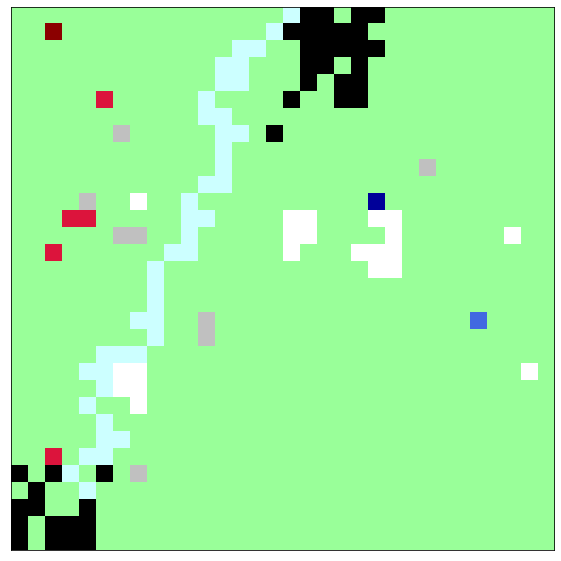

[MOVE-S] OK
ACTIVE
move_left


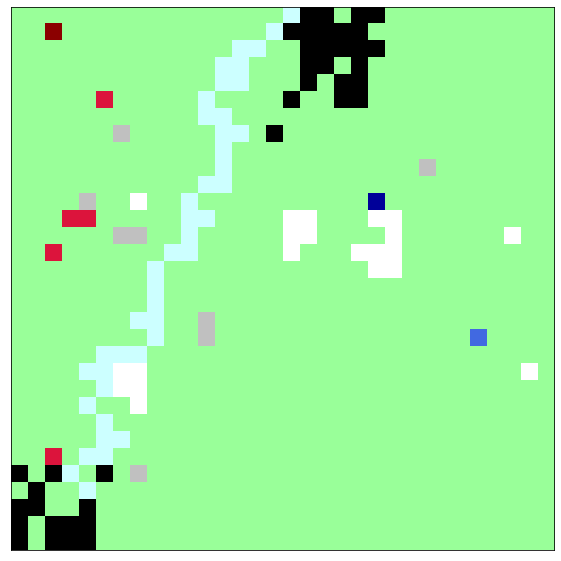

[MOVE-W] OK
ACTIVE
move_up


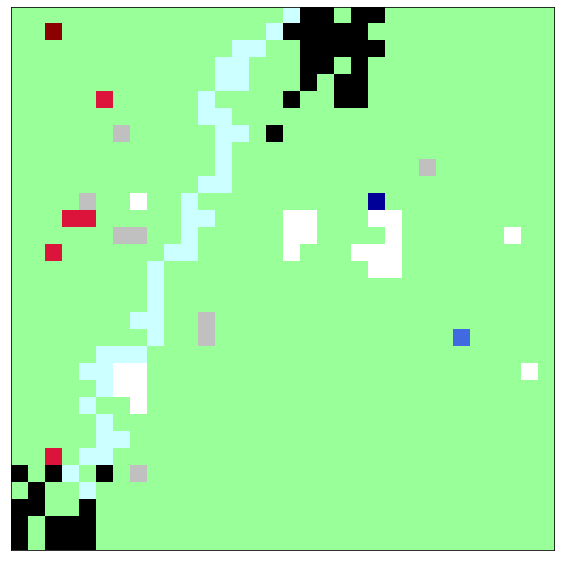

[MOVE-N] OK
ACTIVE
move_right


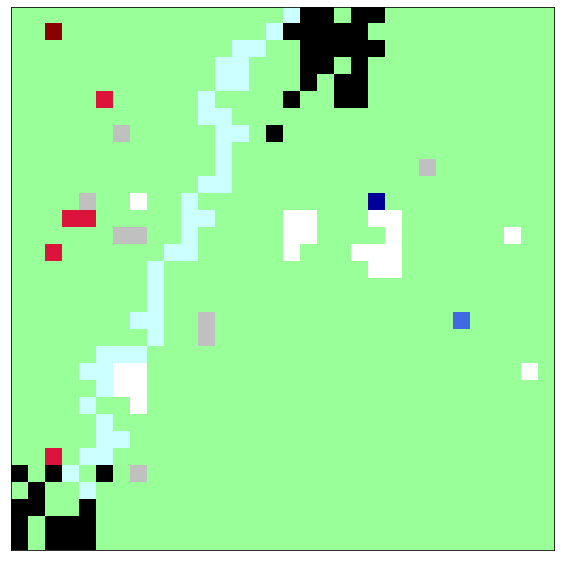

[MOVE-E] OK
ACTIVE
move_right


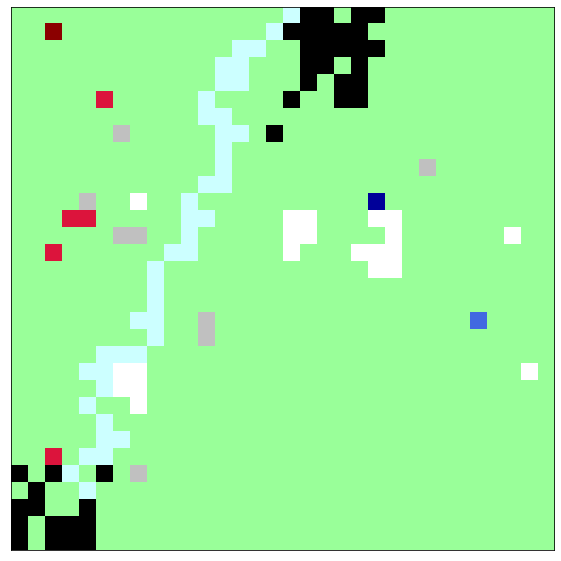

[MOVE-E] OK
ACTIVE
move_down


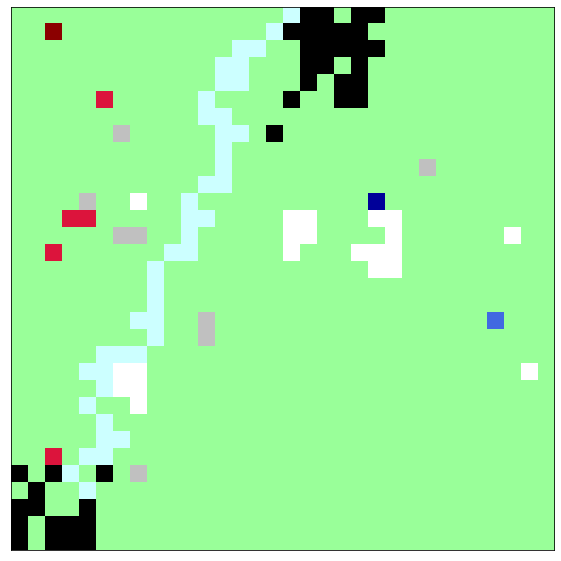

[MOVE-S] OK
ACTIVE
move_up


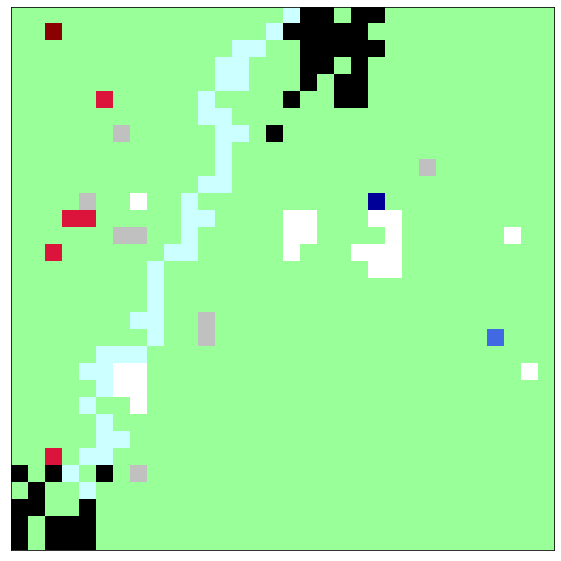

[MOVE-N] OK
ACTIVE
move_right


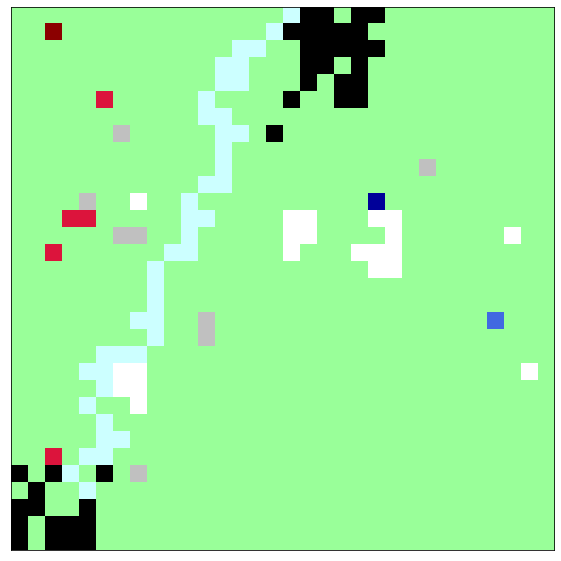

[MOVE-E] OK
ACTIVE
move_left


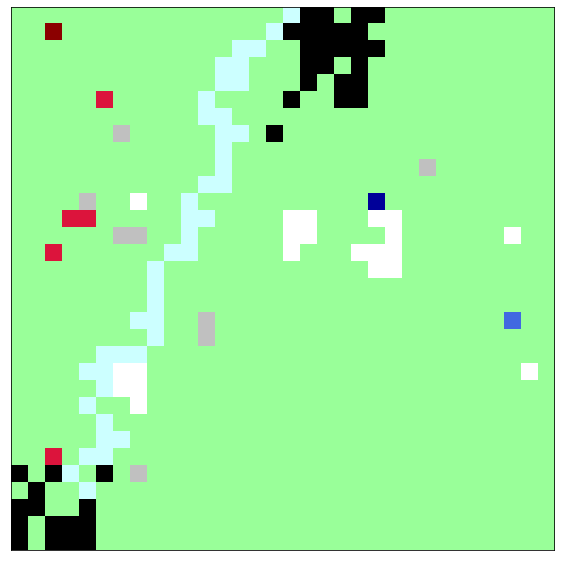

[MOVE-W] OK
ACTIVE
move_left


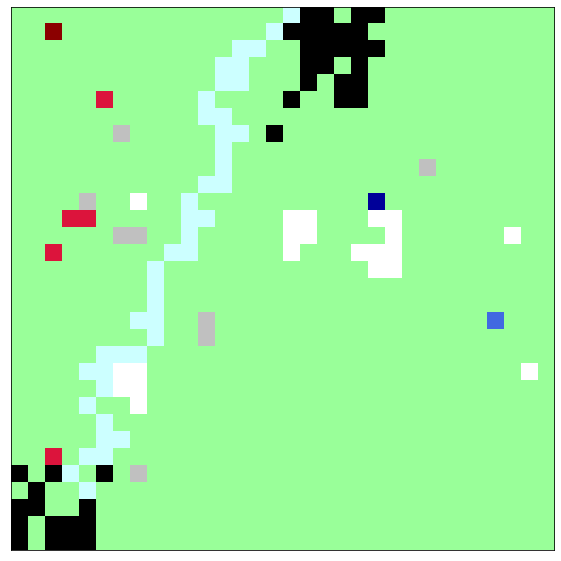

[MOVE-W] OK
ACTIVE
move_left


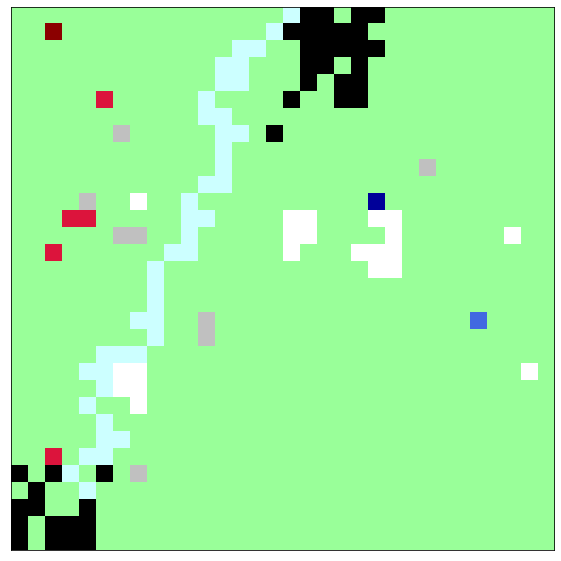

[MOVE-W] OK
ACTIVE
move_up


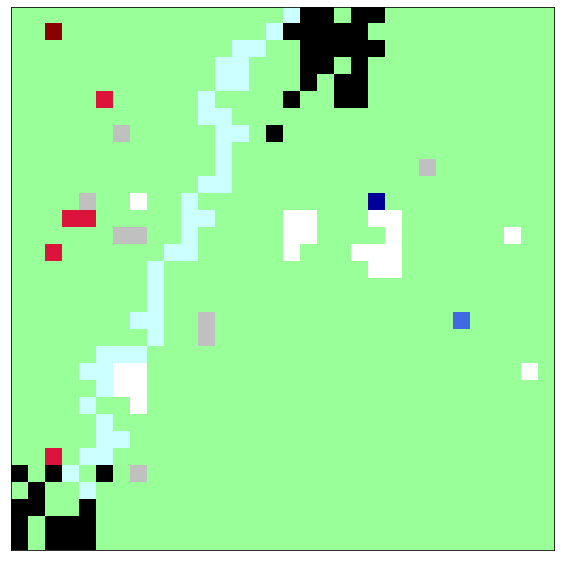

[MOVE-N] OK
ACTIVE
move_right


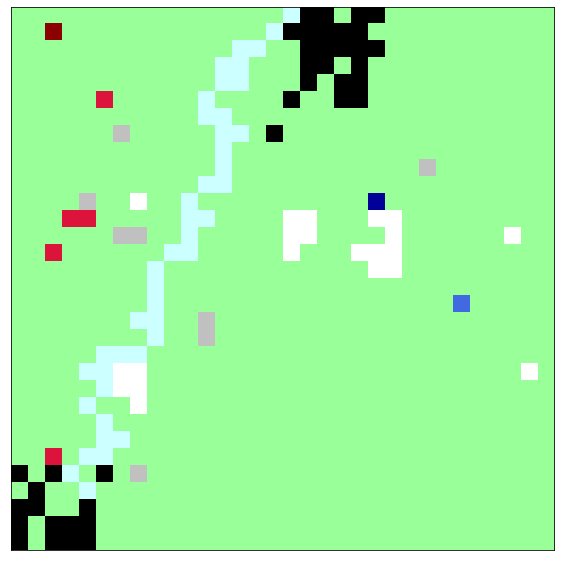

[MOVE-E] OK
ACTIVE
move_left


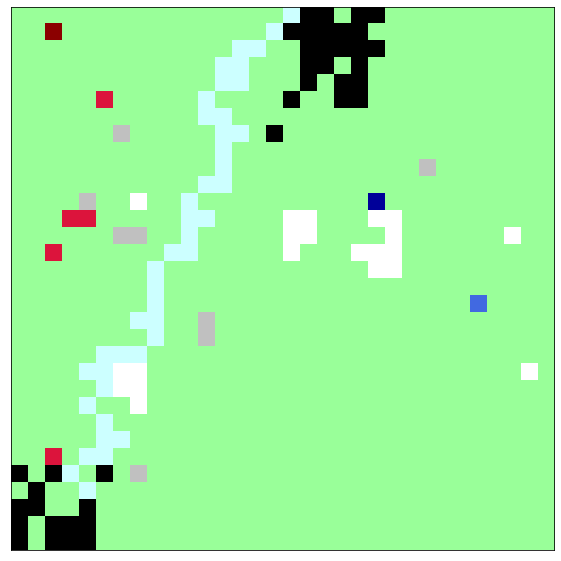

[MOVE-W] OK
ACTIVE
move_down


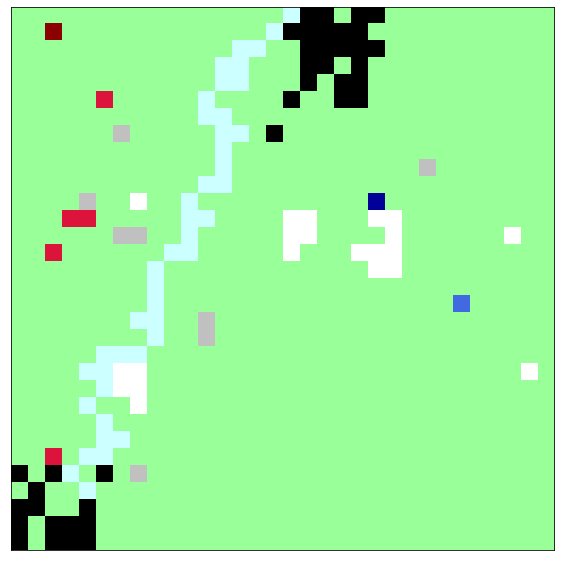

[MOVE-S] OK
ACTIVE
move_left


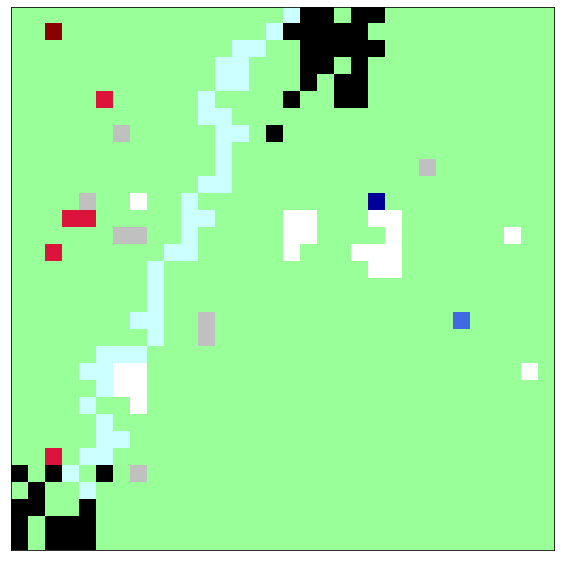

[MOVE-W] OK
ACTIVE
move_left


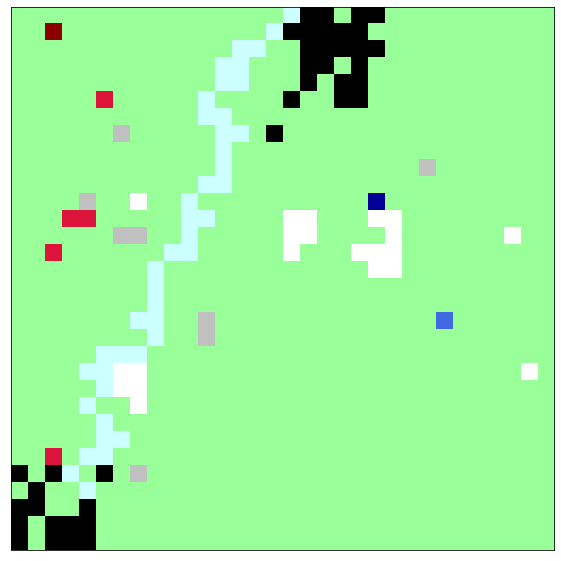

[MOVE-W] OK
ACTIVE
move_left


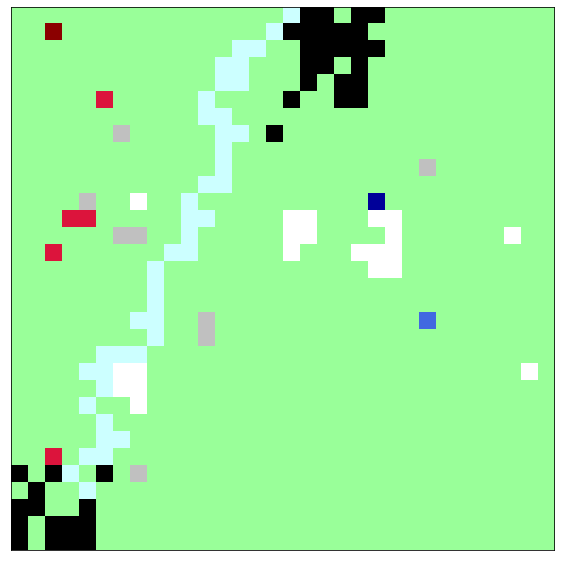

[MOVE-W] OK
ACTIVE
move_left


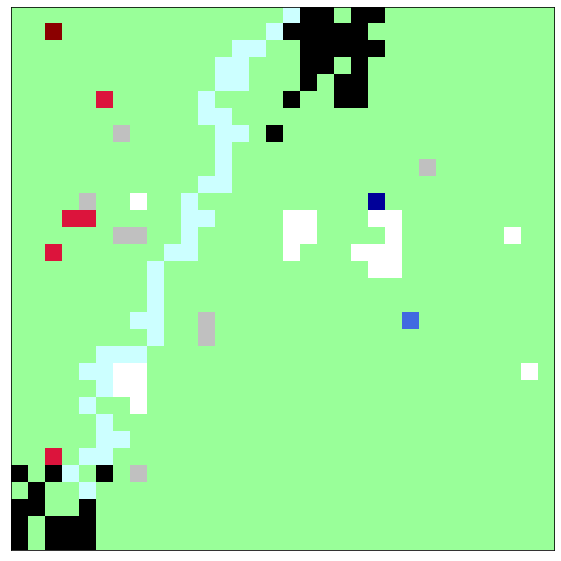

[MOVE-W] OK
ACTIVE
move_down


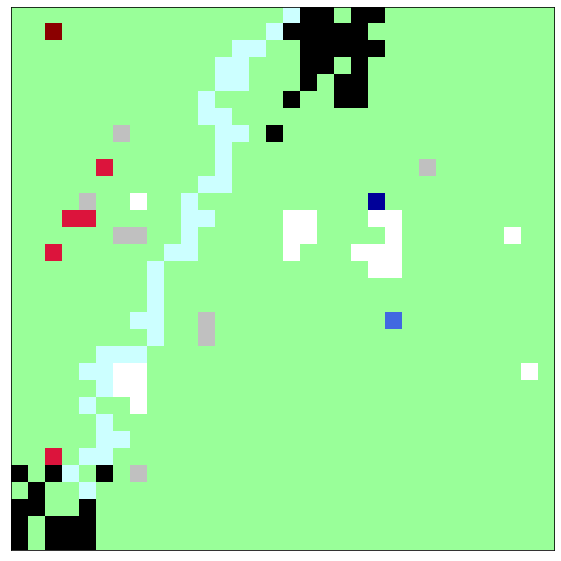

[MOVE-S] OK
ACTIVE
move_left


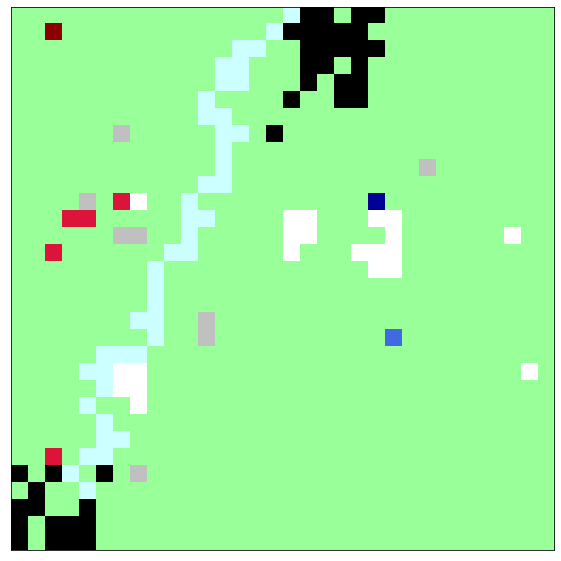

[MOVE-W] OK
ACTIVE
move_left


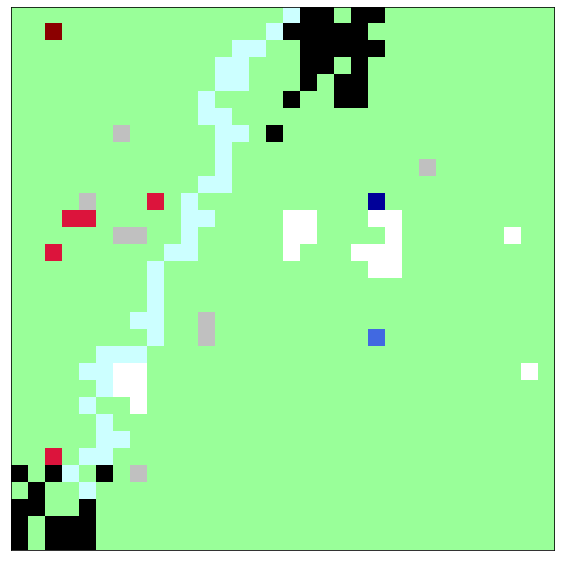

[MOVE-W] OK
ACTIVE
move_right


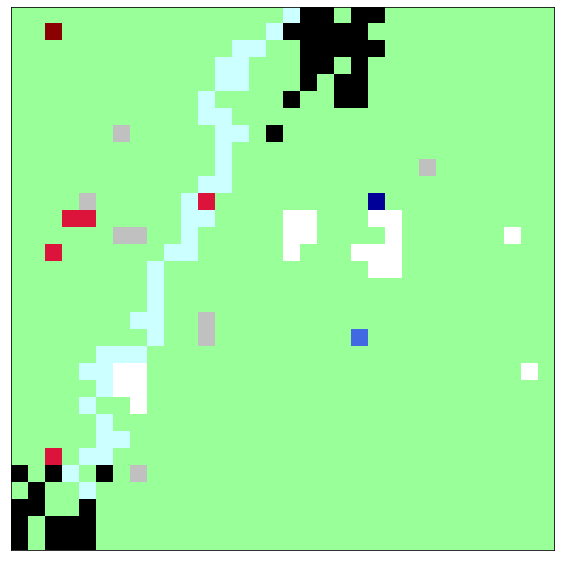

[MOVE-E] OK
ACTIVE
move_right


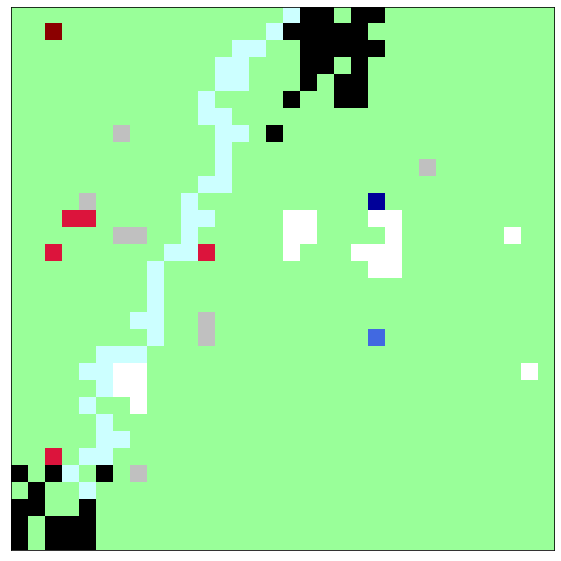

[MOVE-E] OK
ACTIVE
move_left


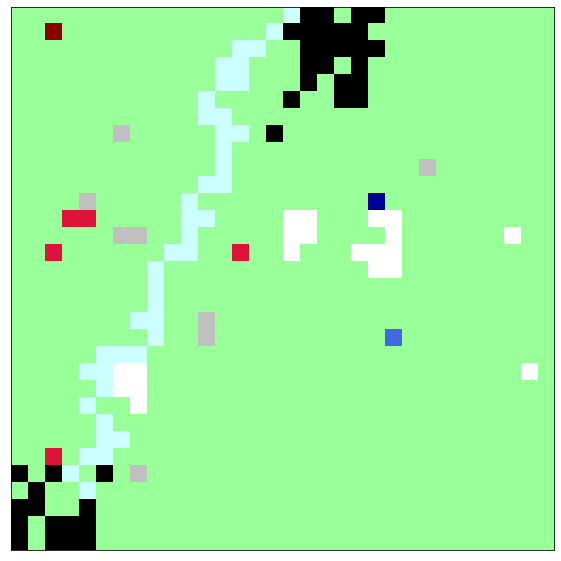

[MOVE-W] OK
ACTIVE
move_right


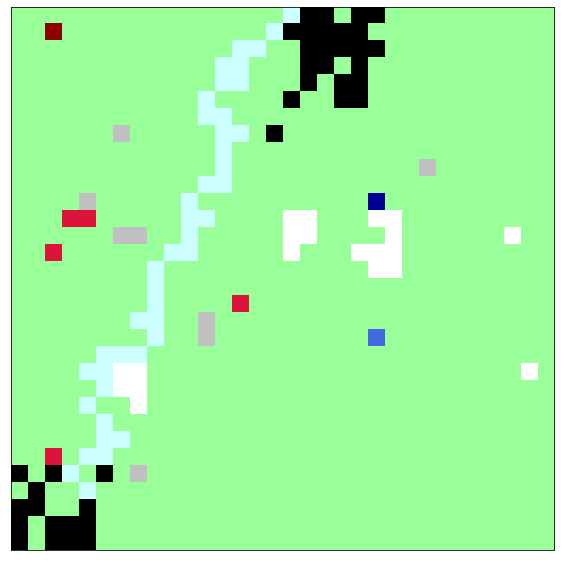

[MOVE-E] OK
ACTIVE
move_left


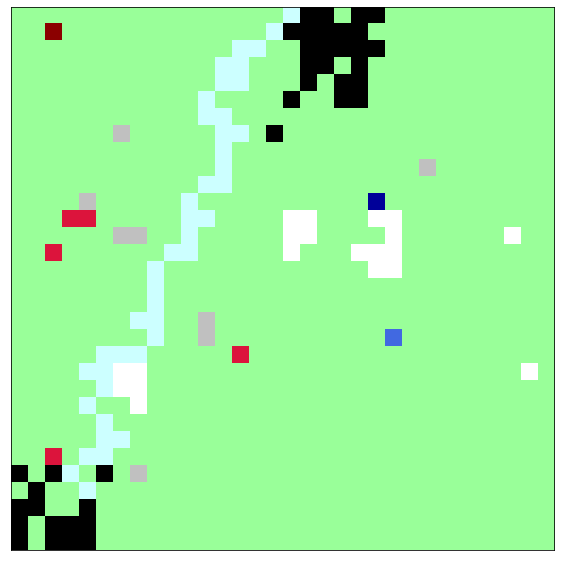

[MOVE-W] OK
ACTIVE
move_right


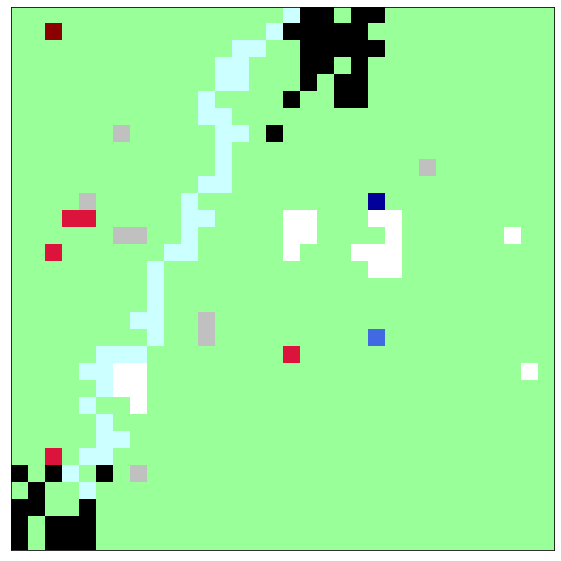

[MOVE-E] OK
ACTIVE
move_up


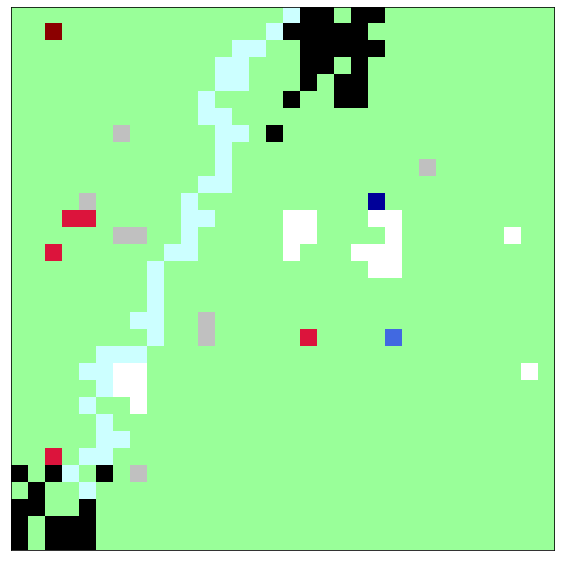

[MOVE-N] OK
ACTIVE
move_up


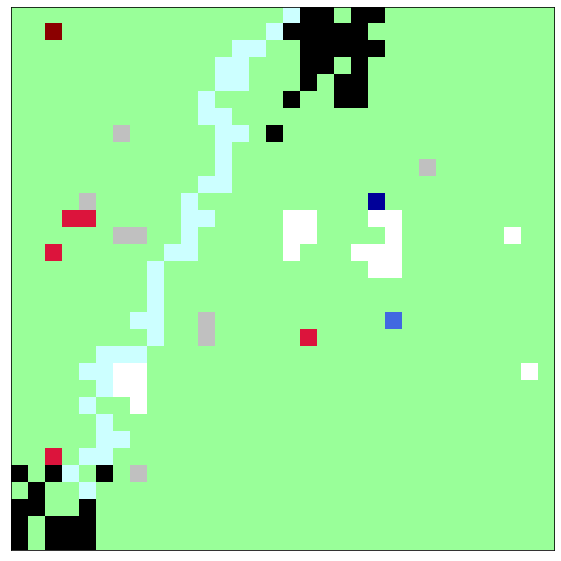

[MOVE-N] OK
ACTIVE
move_right


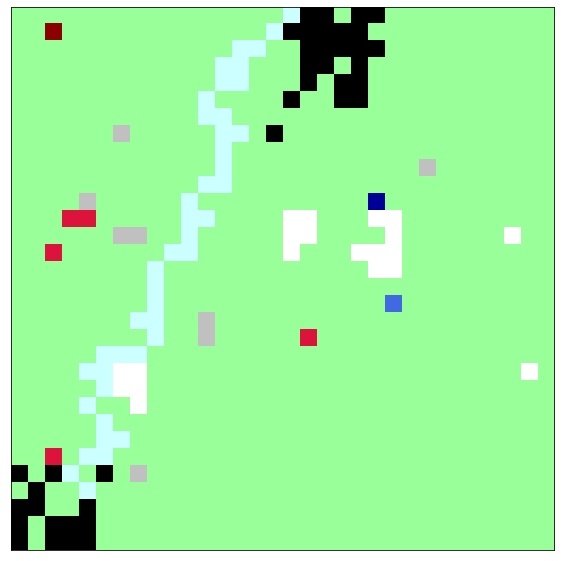

[MOVE-E] OK
ACTIVE
move_left


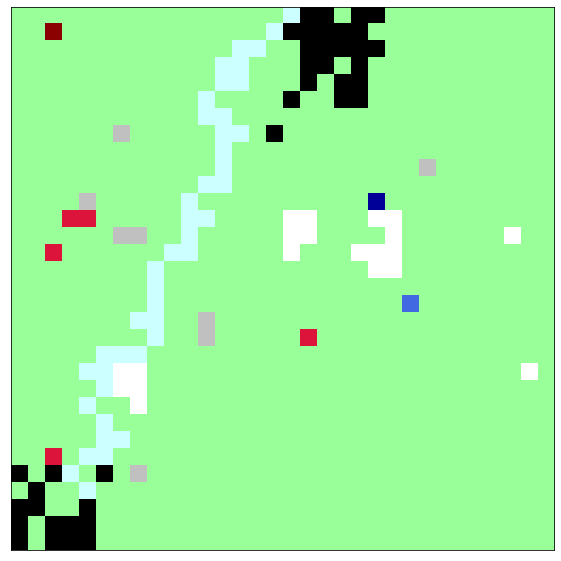

[MOVE-W] OK
ACTIVE
move_right


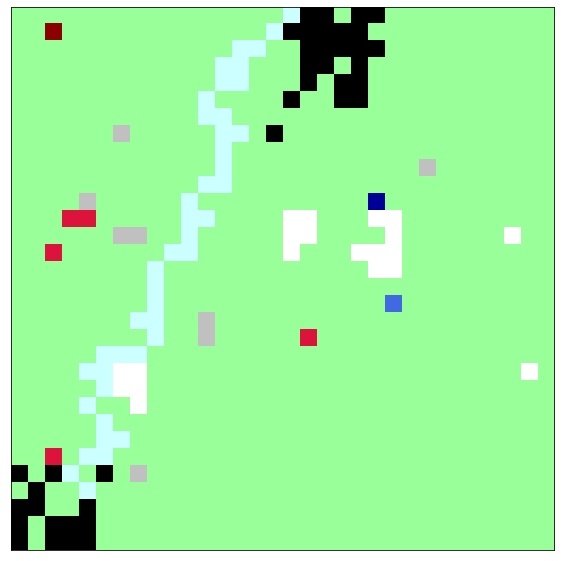

[MOVE-E] OK
ACTIVE
move_right


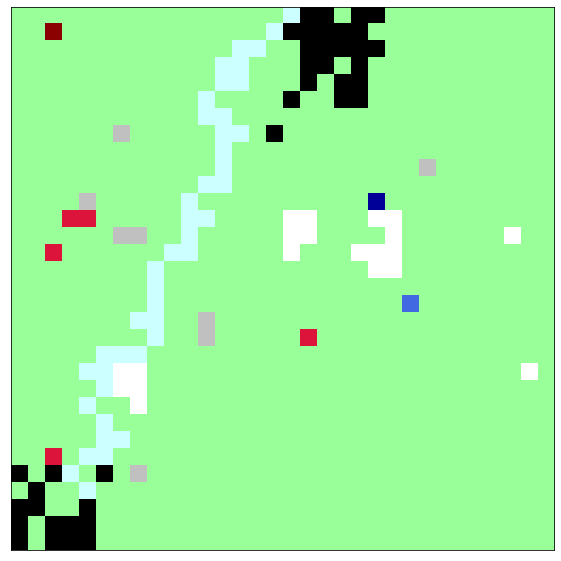

[MOVE-E] OK
ACTIVE
move_left


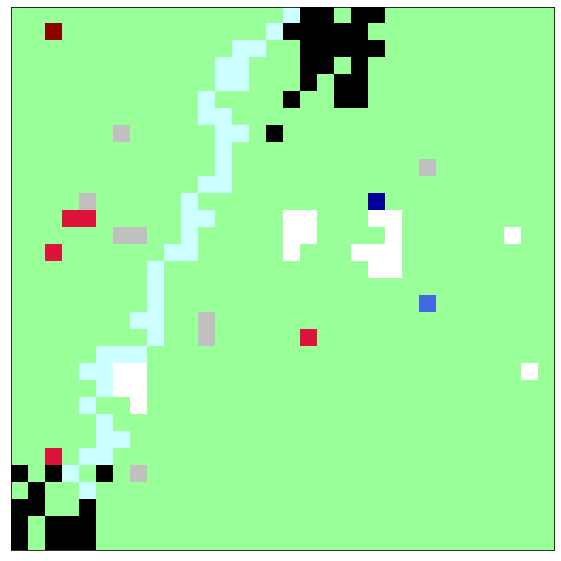

[MOVE-W] OK
ACTIVE
move_left


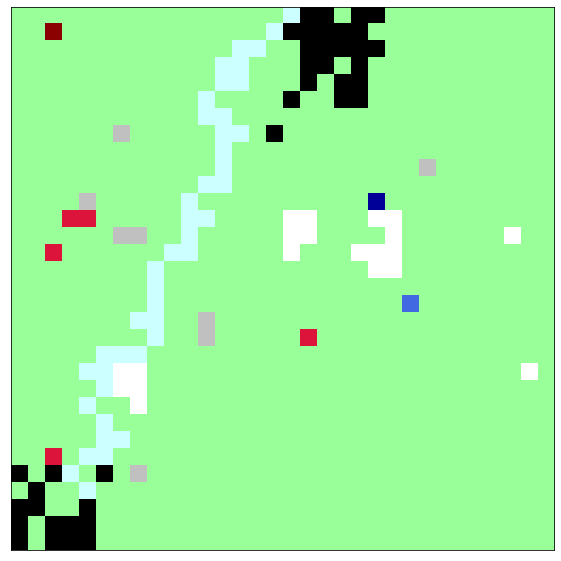

[MOVE-W] OK
ACTIVE
move_right


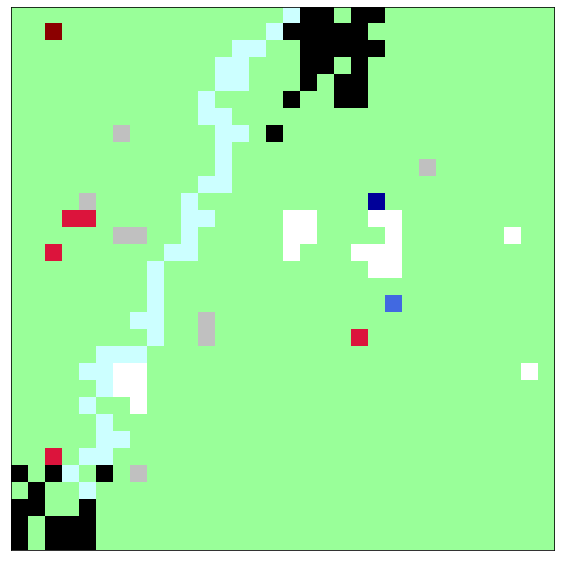

[MOVE-E] OK
ACTIVE
move_right


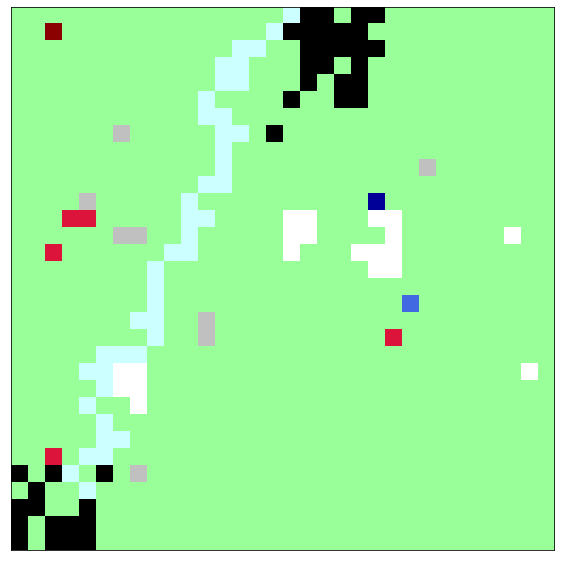

[MOVE-E] OK
ACTIVE
move_left


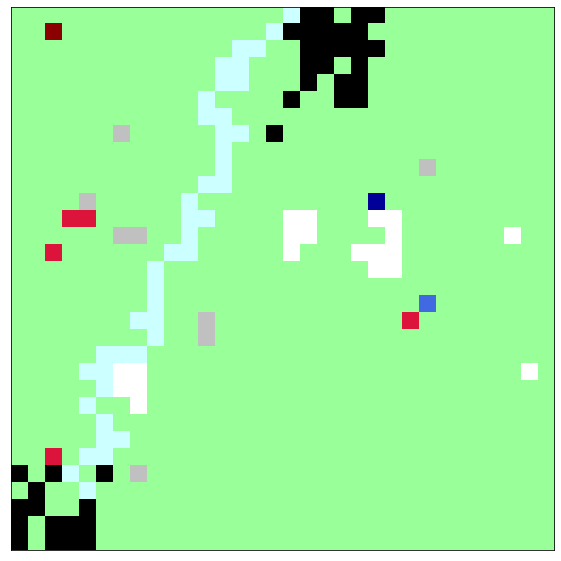

[MOVE-W] OK
ACTIVE
move_right


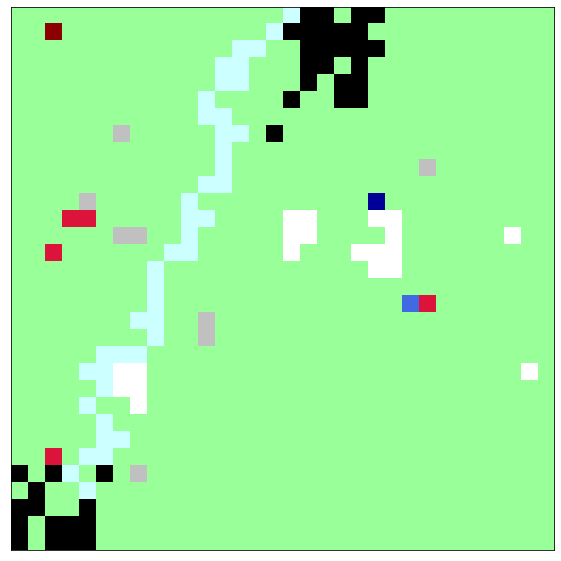

[MOVE-E] OK
ACTIVE
move_right


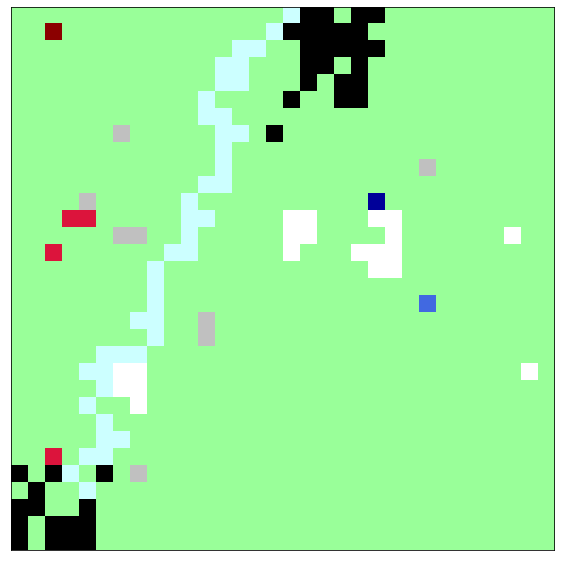

[MOVE-E] OK
ACTIVE
move_left


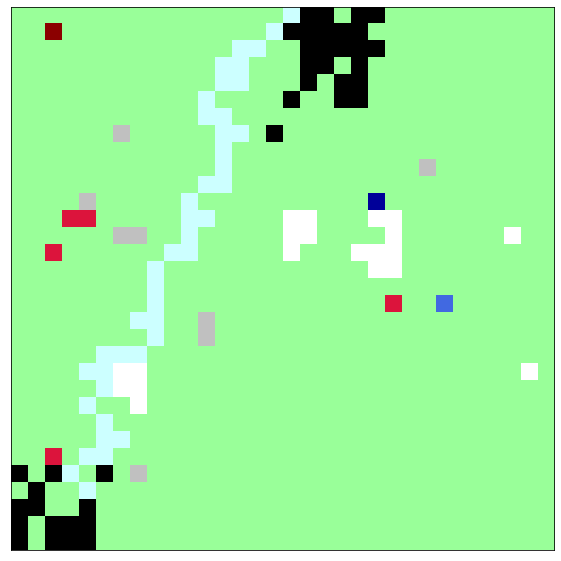

[MOVE-W] OK
ACTIVE
move_right


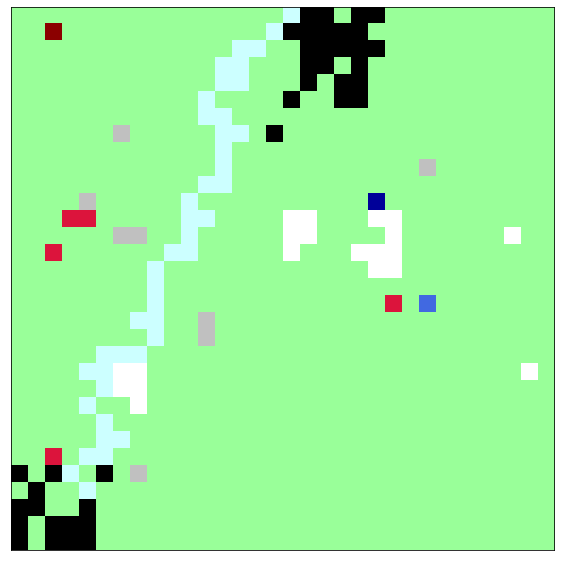

[MOVE-E] OK
ACTIVE
move_left


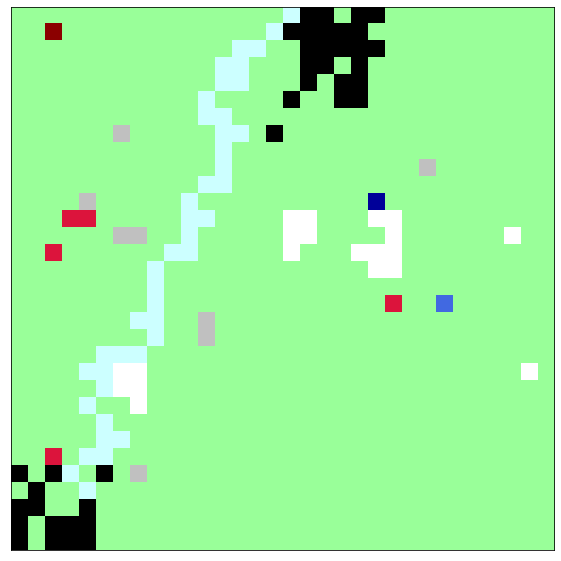

[MOVE-W] OK
ACTIVE
move_down


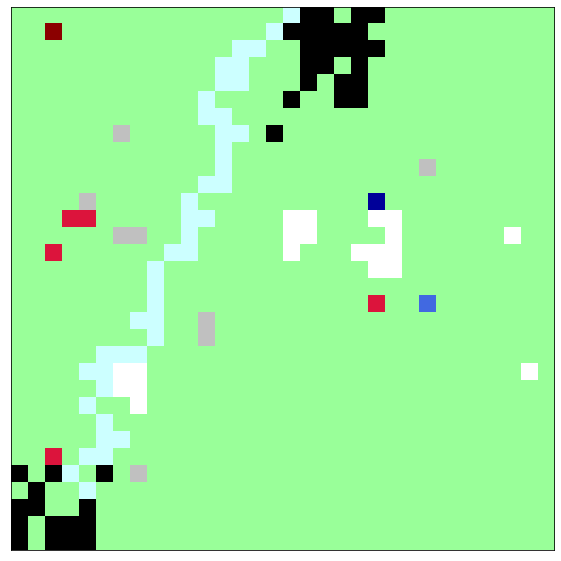

[MOVE-S] OK
ACTIVE
move_left


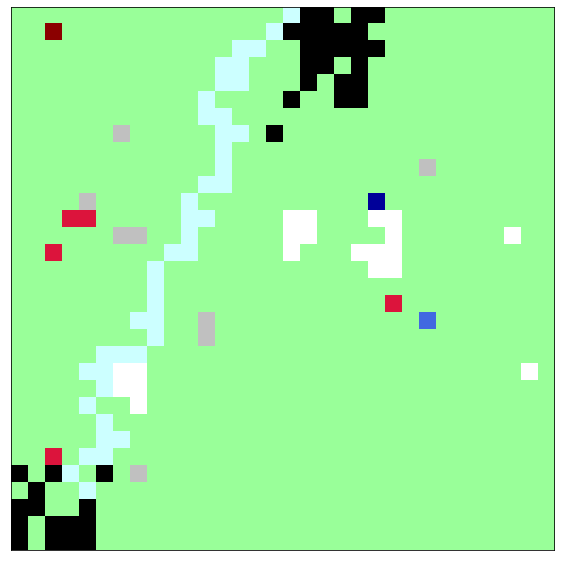

[MOVE-W] OK
ACTIVE
move_right


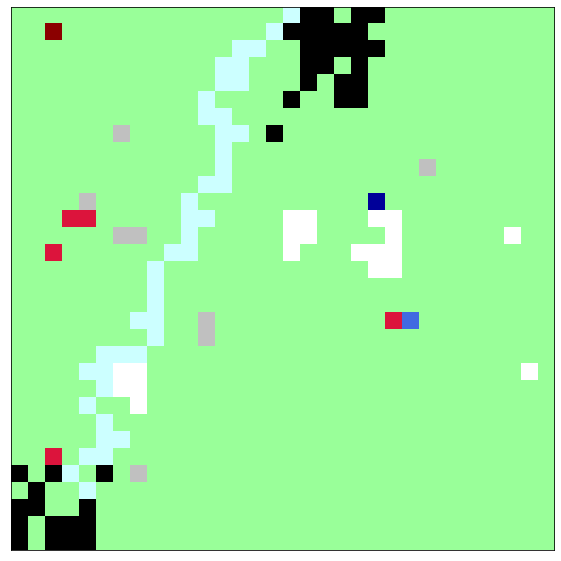

[MOVE-E] OK
ACTIVE
move_left


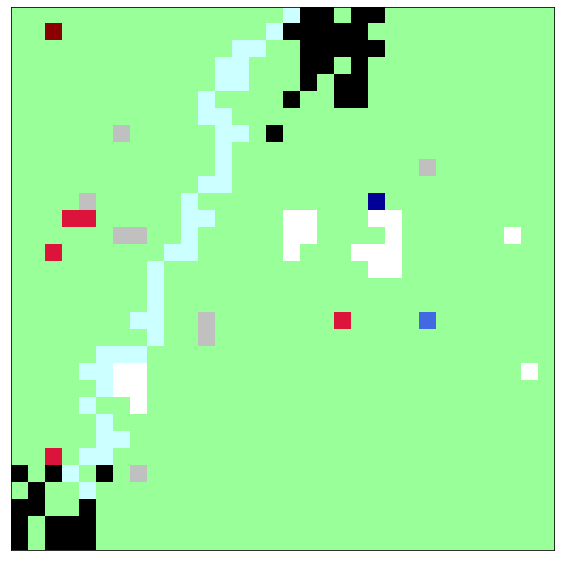

[MOVE-W] OK
ACTIVE
move_right


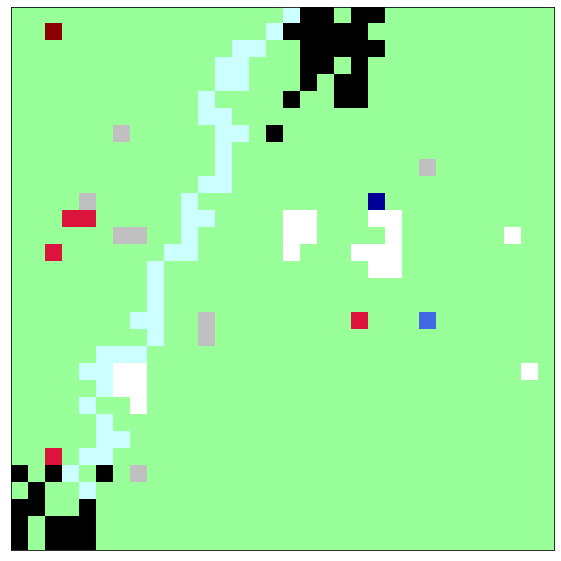

[MOVE-E] OK
ACTIVE
move_right


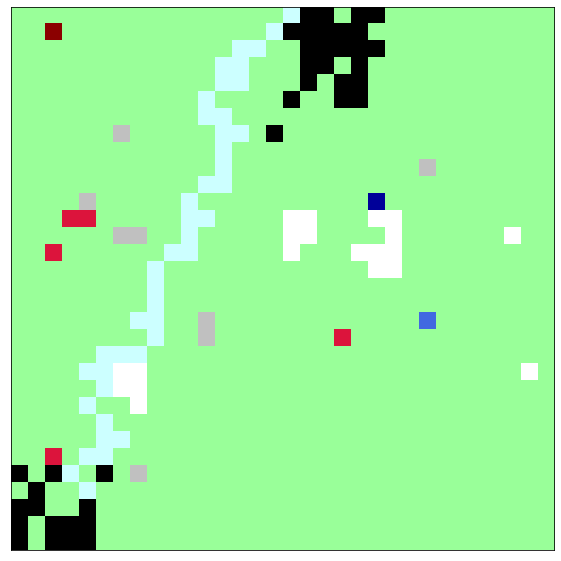

[MOVE-E] OK
ACTIVE
move_right


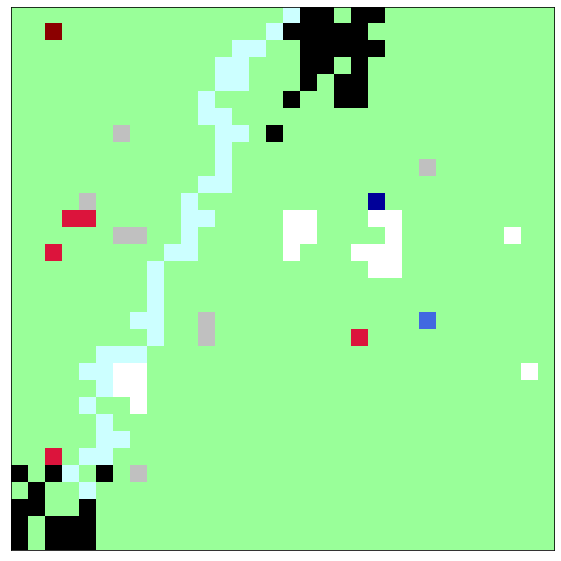

[MOVE-E] OK
ACTIVE
move_right


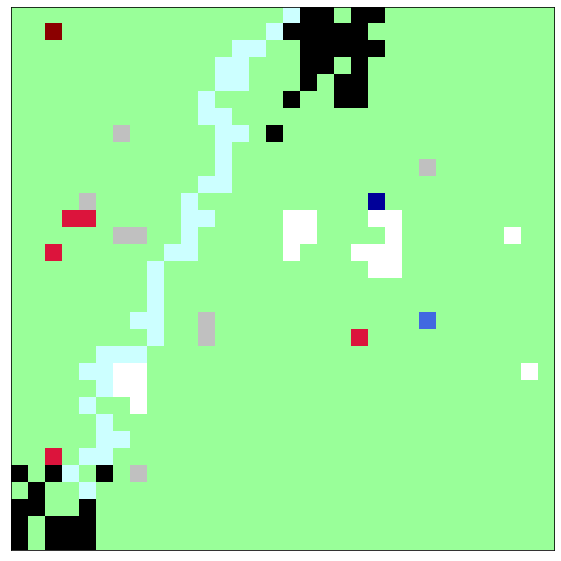

[MOVE-E] OK
ACTIVE
move_down


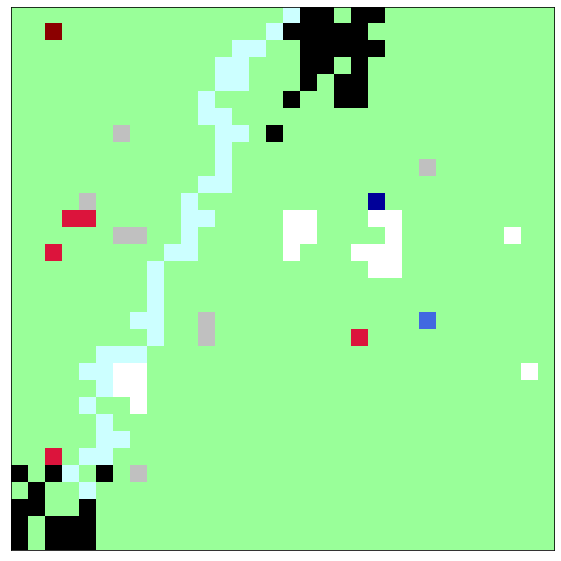

[MOVE-S] OK
ACTIVE
move_right


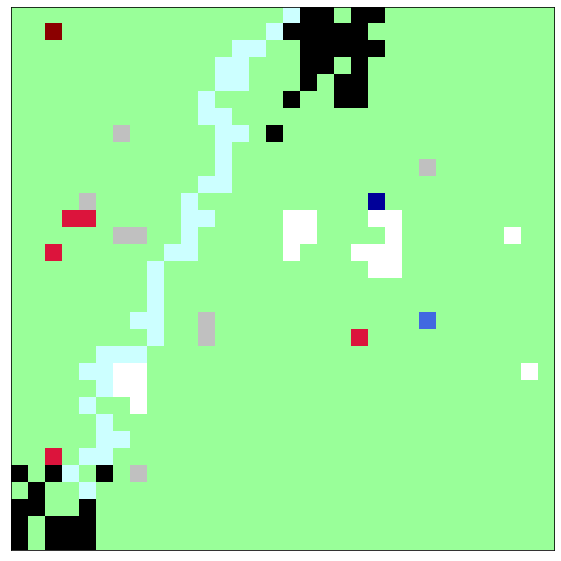

[MOVE-E] OK
ACTIVE
move_right


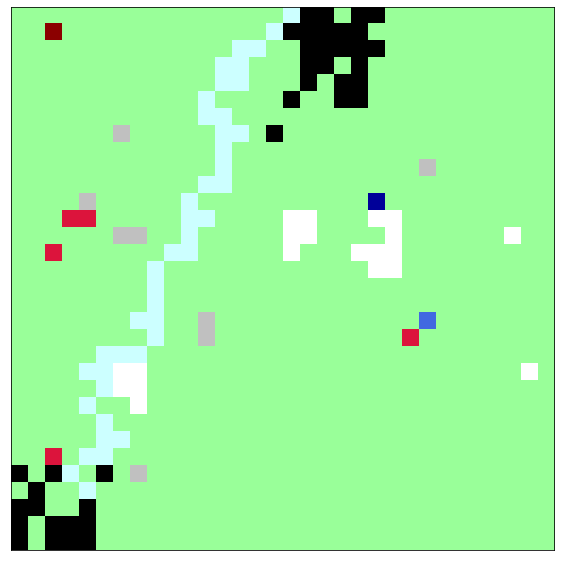

[MOVE-E] OK
ACTIVE
move_down


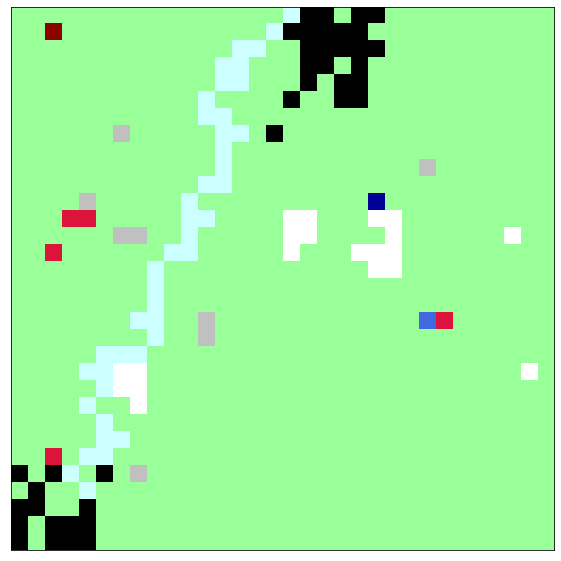

[MOVE-S] OK
ACTIVE
move_left


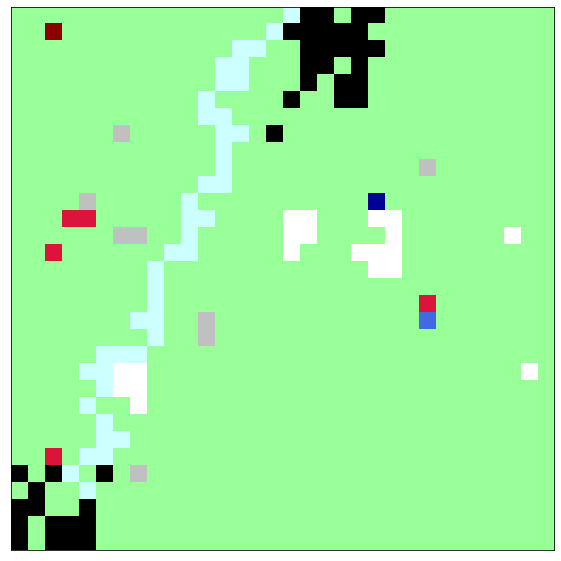

[MOVE-W] OK
ACTIVE
move_up


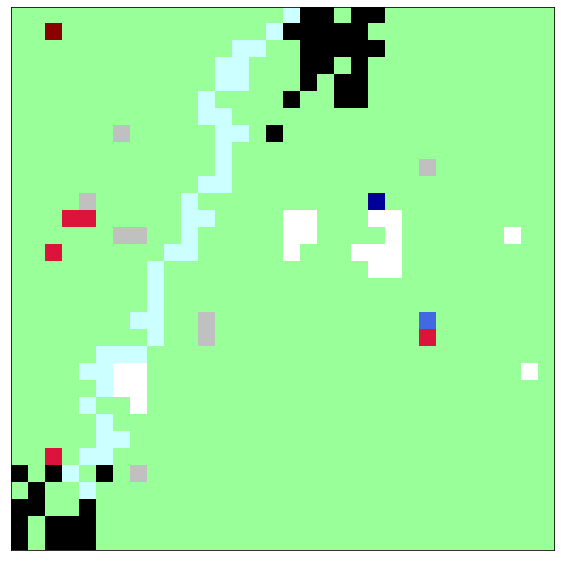

[MOVE-N] OK
ACTIVE
move_down


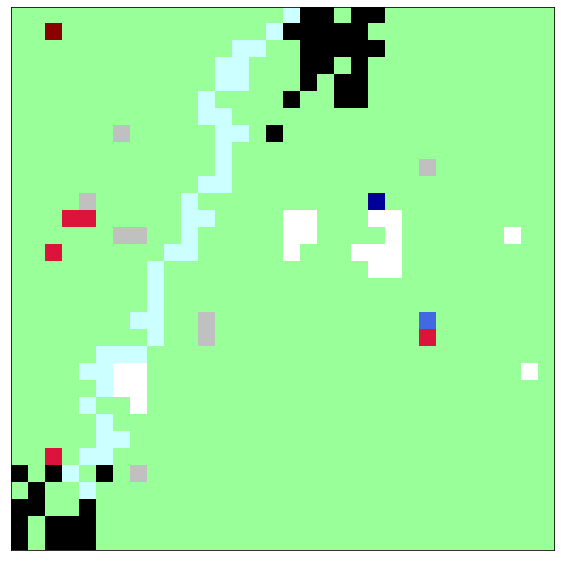

[MOVE-S] OK
ACTIVE
move_right


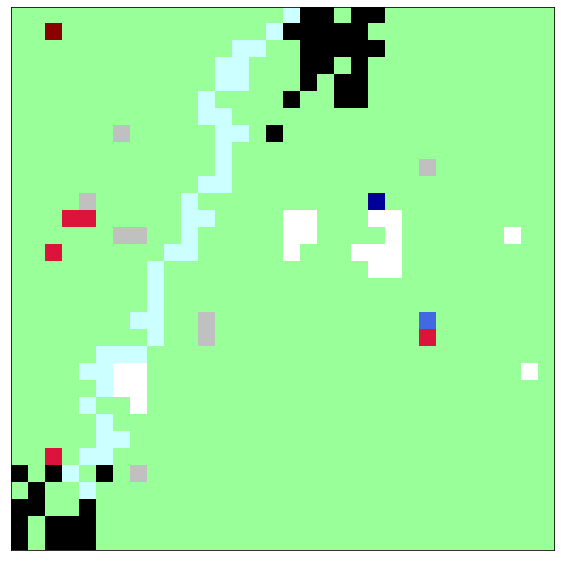

[MOVE-E] OK
ACTIVE
move_right


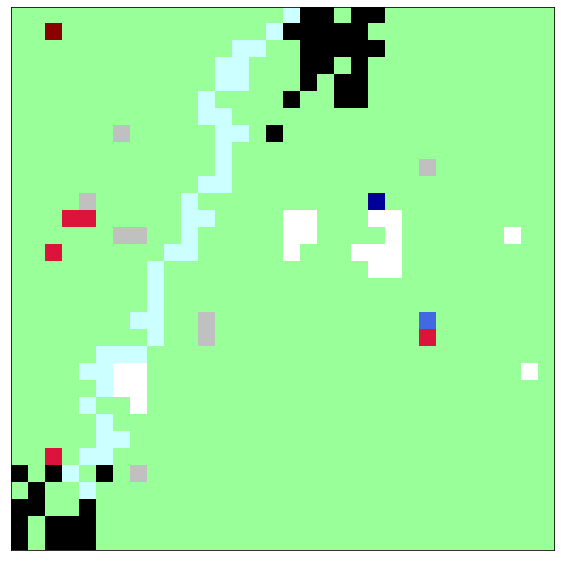

[MOVE-E] OK
ACTIVE
move_right


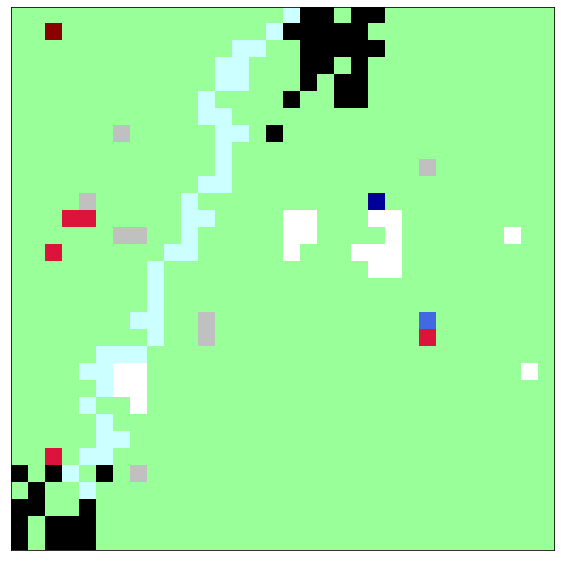

[MOVE-E] OK
ACTIVE
move_right


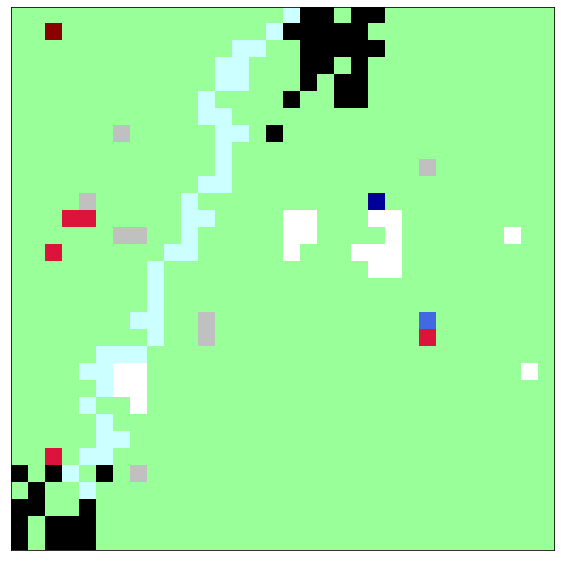

[MOVE-E] OK
ACTIVE
move_left


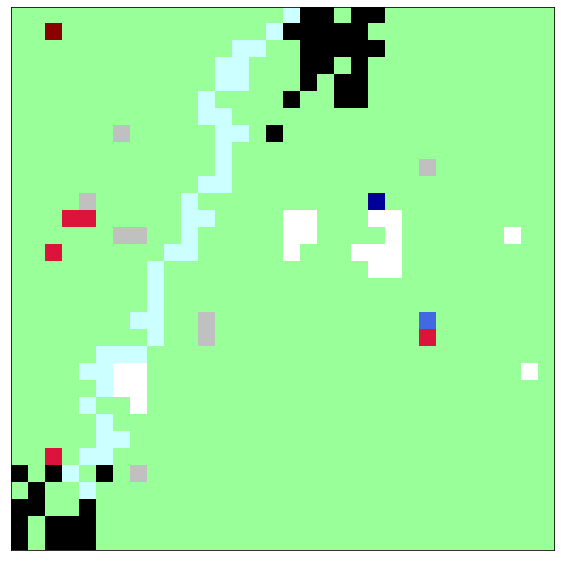

[MOVE-W] OK
ACTIVE
move_right


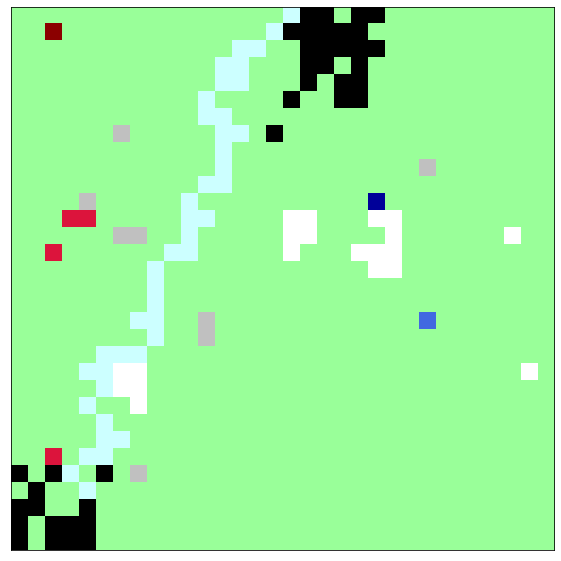

[MOVE-E] OK
ACTIVE
move_left


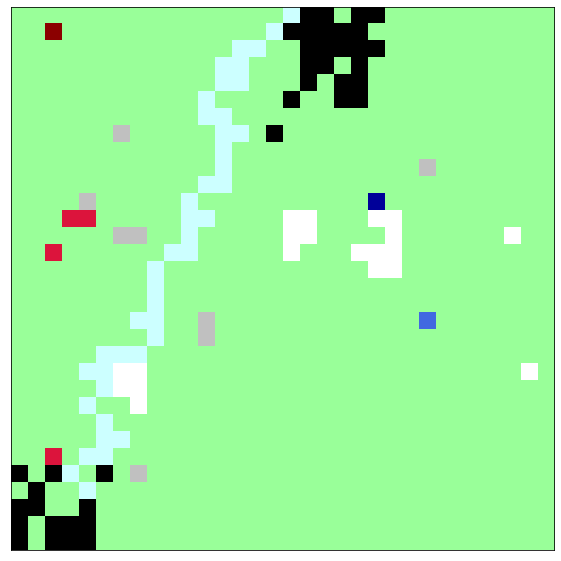

[MOVE-W] OK
ACTIVE
move_right


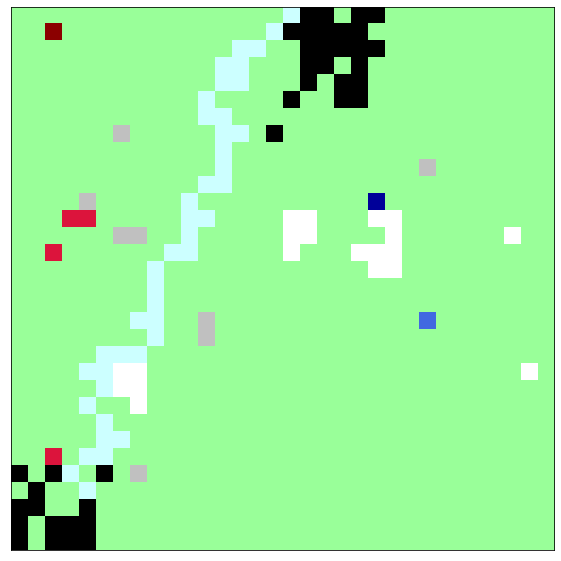

[MOVE-E] OK
ACTIVE
move_right


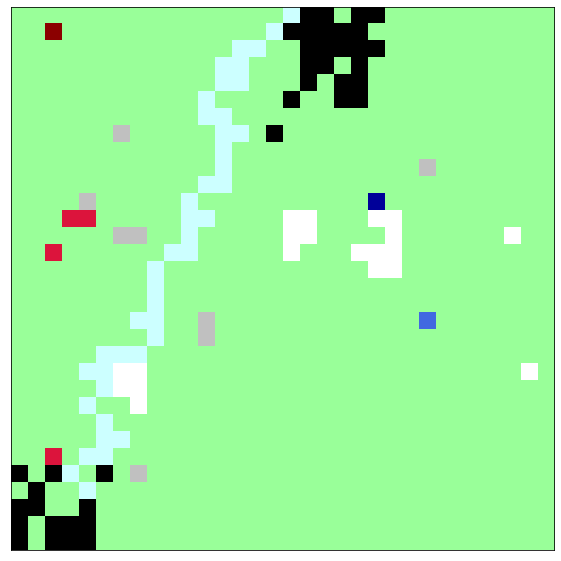

[MOVE-E] OK
ACTIVE
move_right


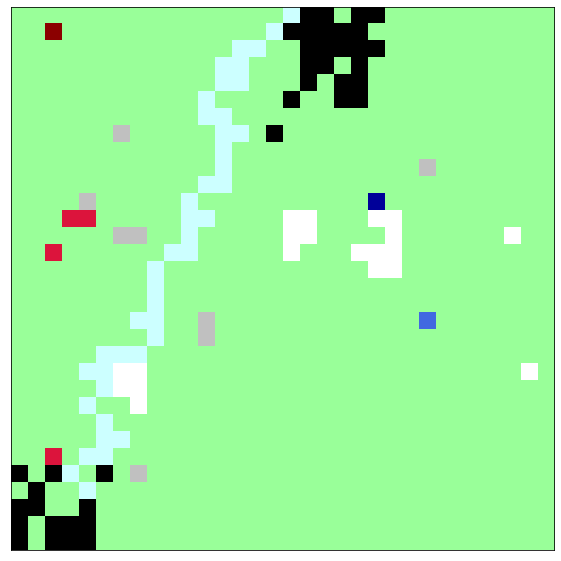

[MOVE-E] OK
ACTIVE
move_left


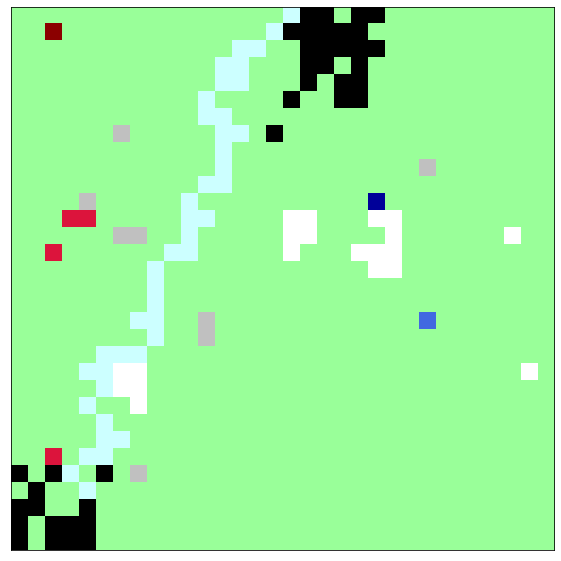

[MOVE-W] OK
ACTIVE
move_right


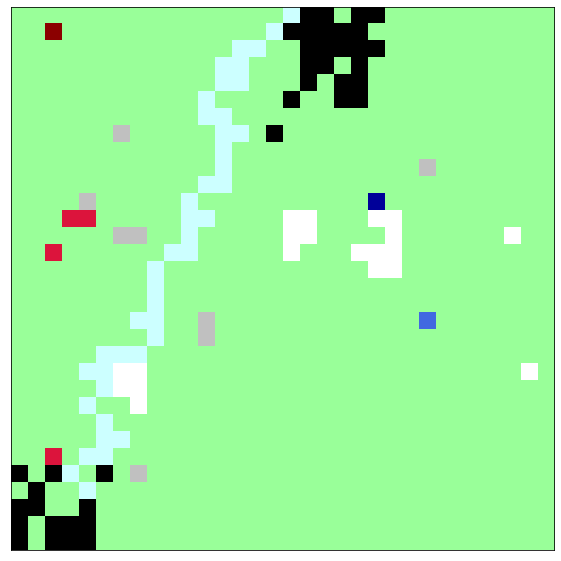

[MOVE-E] OK
ACTIVE
move_left


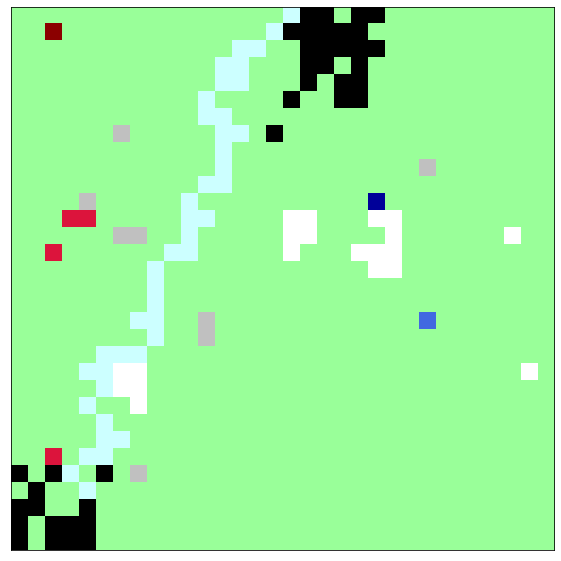

[MOVE-W] OK
ACTIVE
move_right


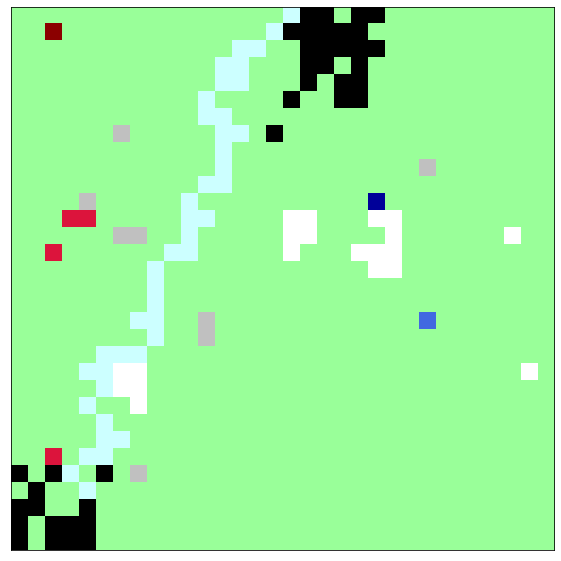

[MOVE-E] OK
ACTIVE
move_right


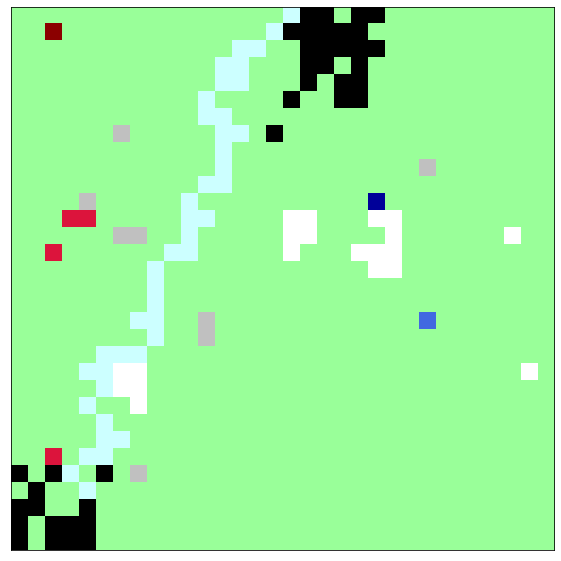

[MOVE-E] OK
ACTIVE
move_right


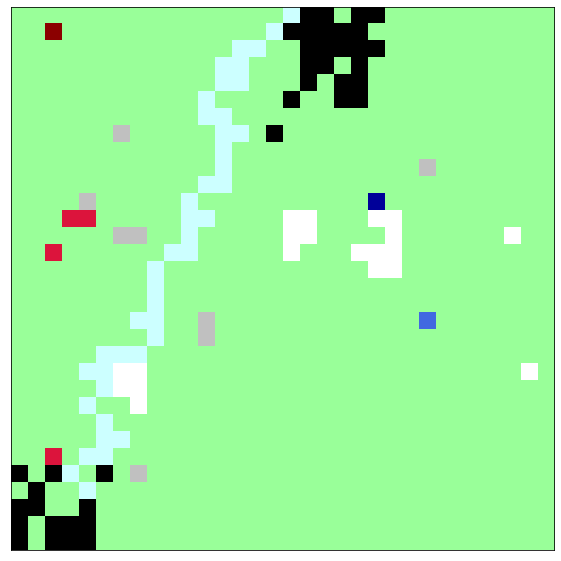

[MOVE-E] OK
ACTIVE
move_left


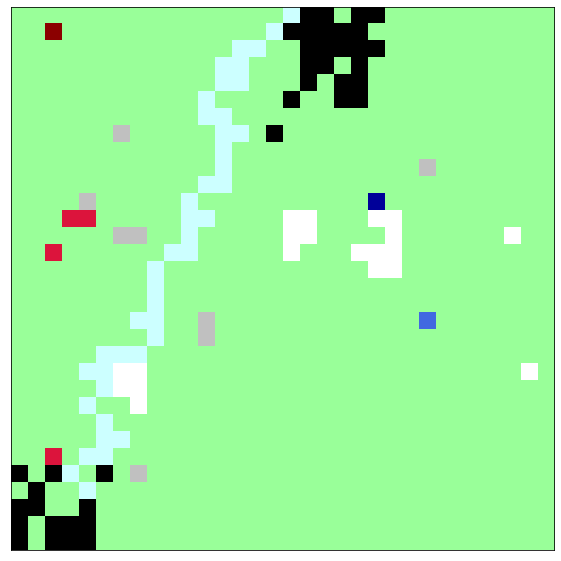

[MOVE-W] OK
ACTIVE
move_up


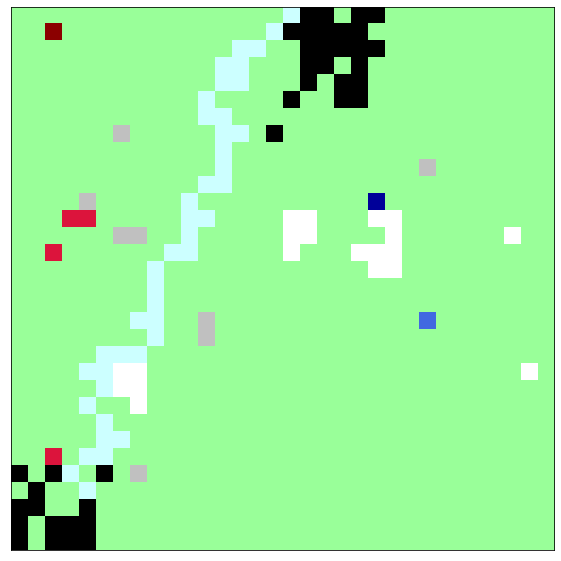

[MOVE-N] OK
ACTIVE
move_right


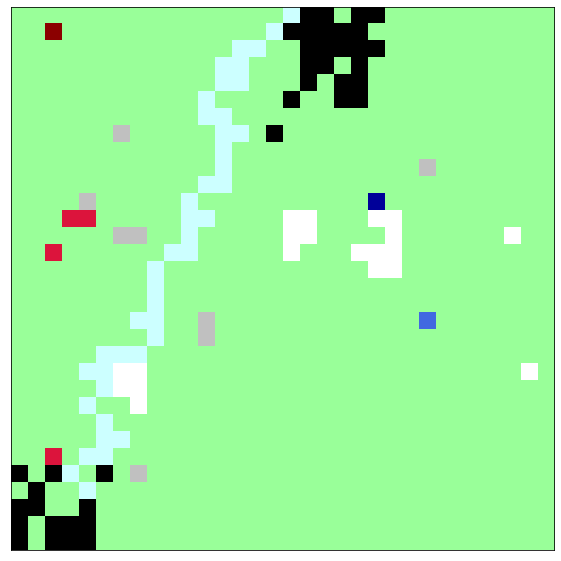

[MOVE-E] OK
ACTIVE
move_right


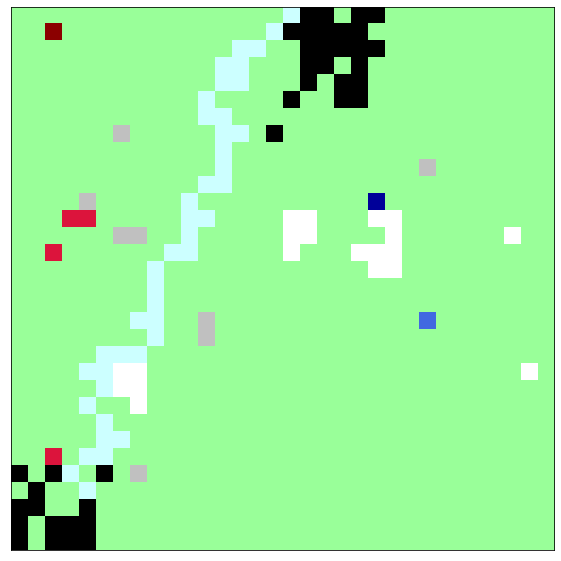

[MOVE-E] OK
ACTIVE
move_left


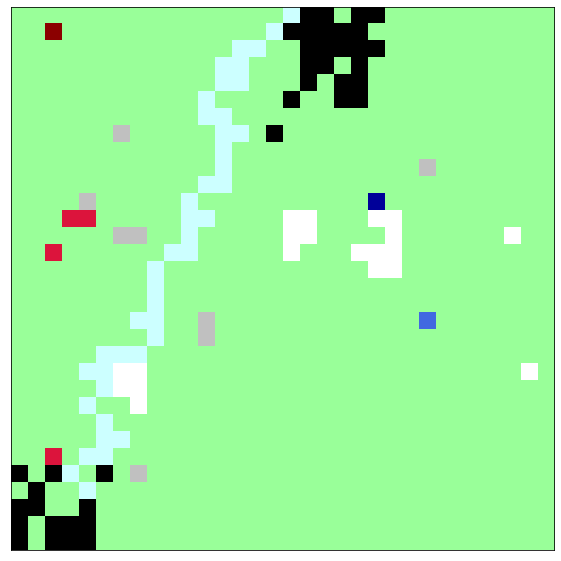

[MOVE-W] OK
ACTIVE
move_right


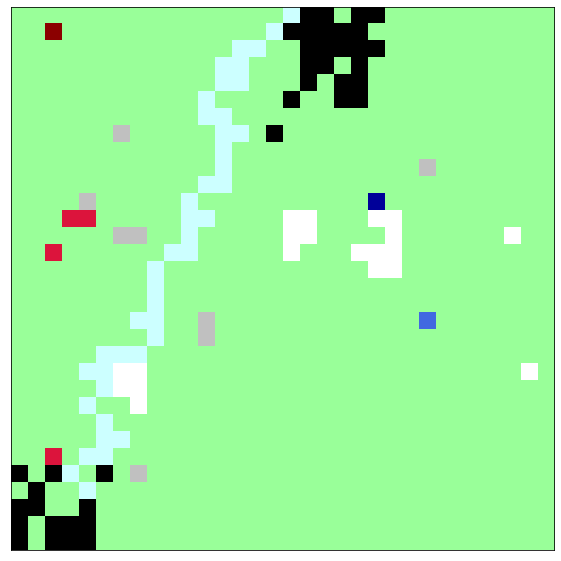

[MOVE-E] OK
ACTIVE
move_down


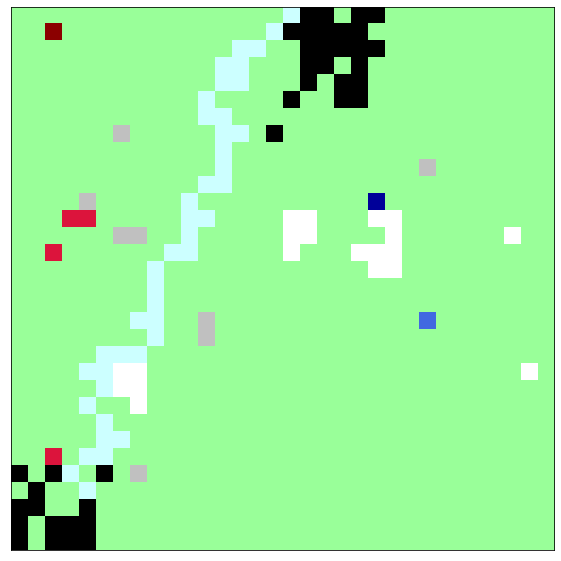

[MOVE-S] OK
ACTIVE
move_right


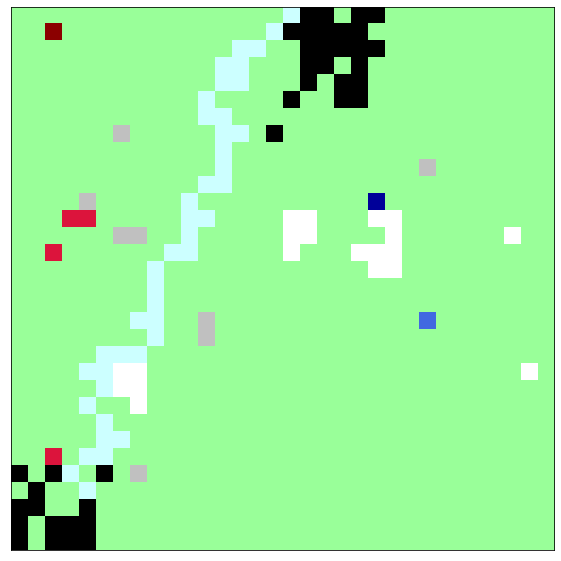

[MOVE-E] OK
ACTIVE
move_right


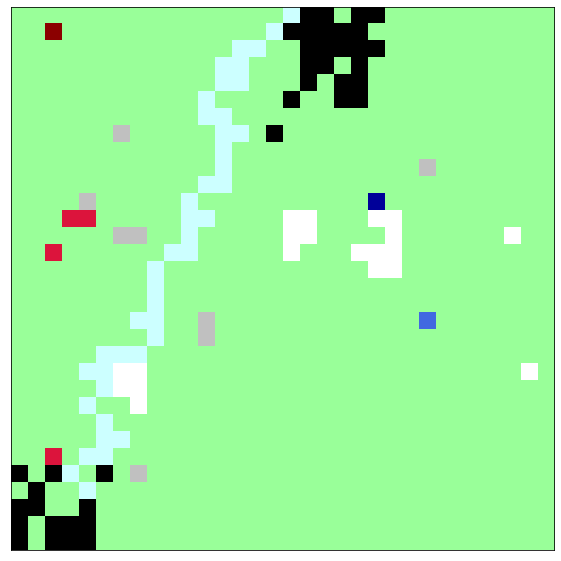

[MOVE-E] OK
ACTIVE
move_right


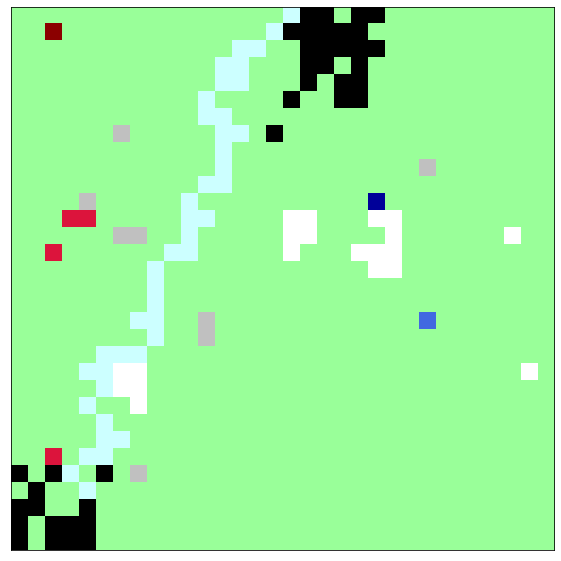

[MOVE-E] OK
ACTIVE
move_right


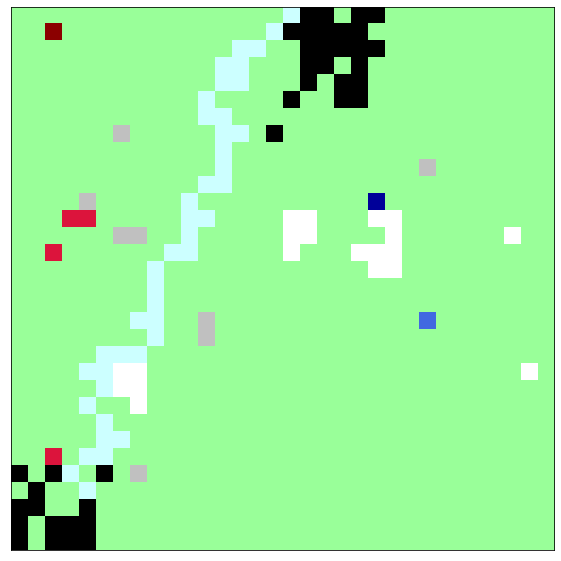

[MOVE-E] OK
ACTIVE
move_right


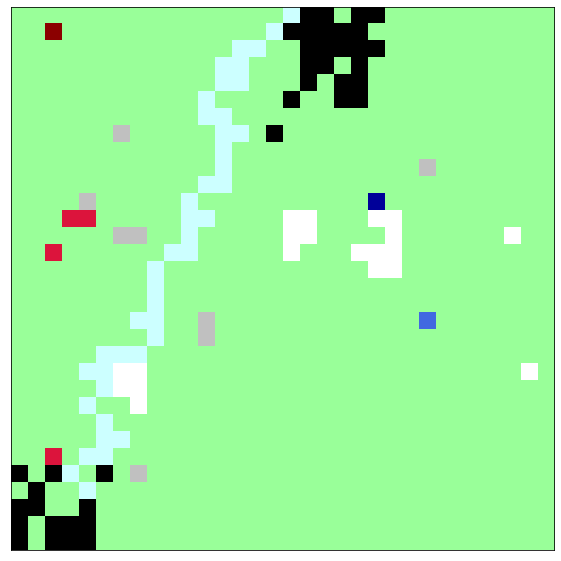

[MOVE-E] OK
ACTIVE
move_down


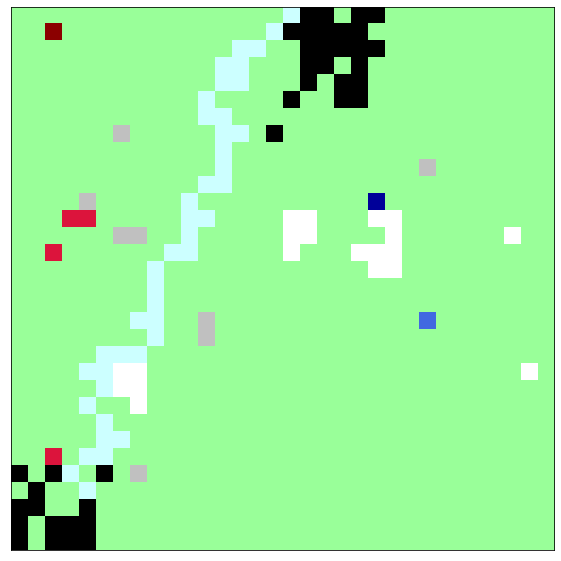

[MOVE-S] OK
ACTIVE
move_right


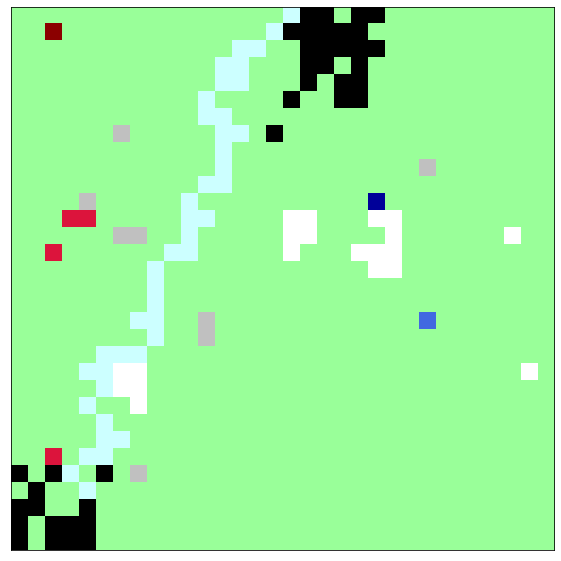

[MOVE-E] OK
ACTIVE
move_left


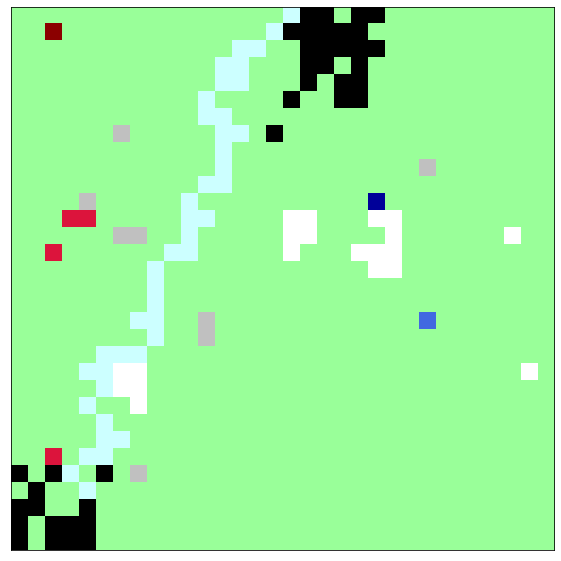

[MOVE-W] OK
ACTIVE
move_right


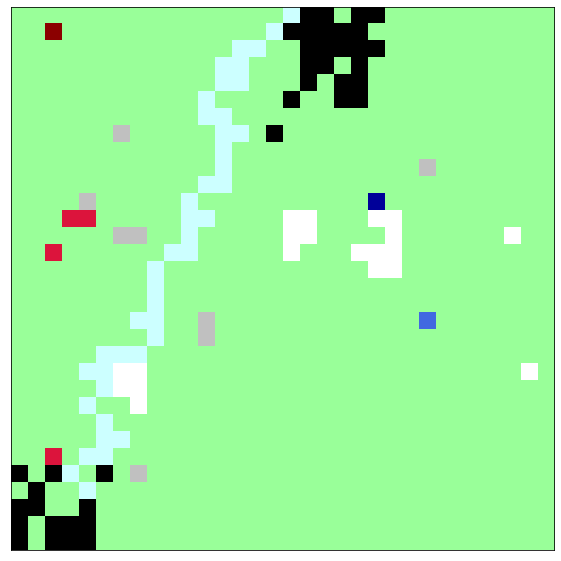

[MOVE-E] OK
ACTIVE
move_up


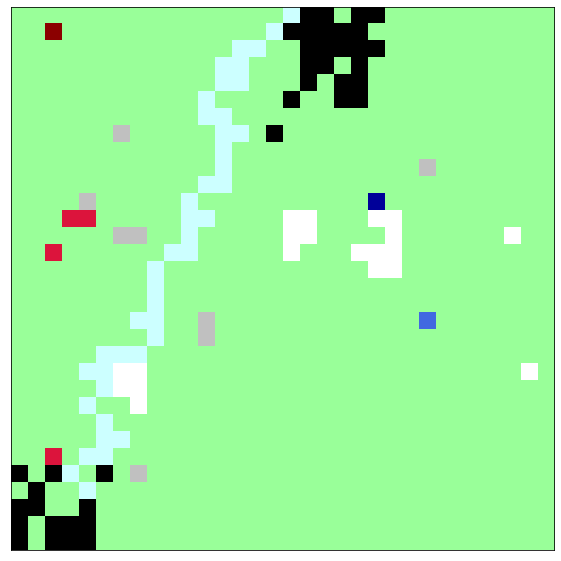

[MOVE-N] OK
ACTIVE
move_right


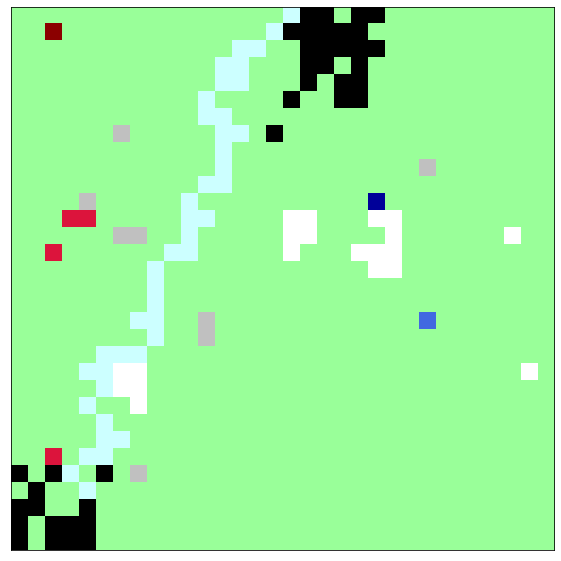

[MOVE-E] OK
ACTIVE
move_right


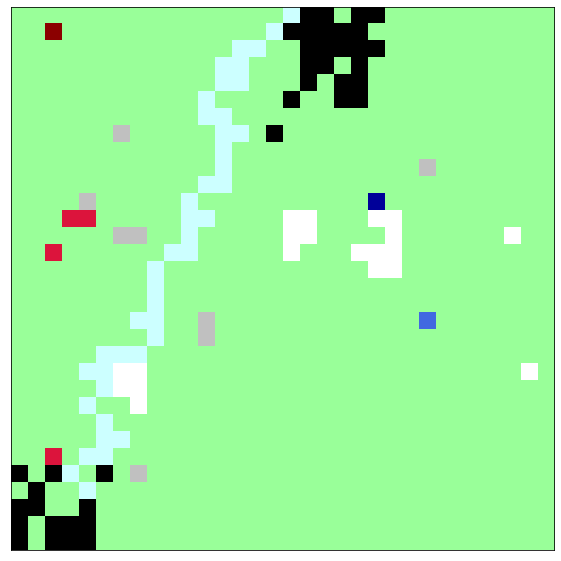

[MOVE-E] OK
ACTIVE
move_right


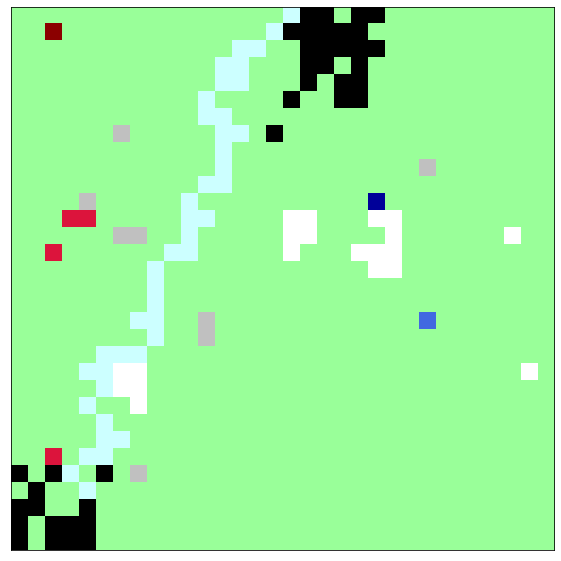

[MOVE-E] OK
ACTIVE
move_right


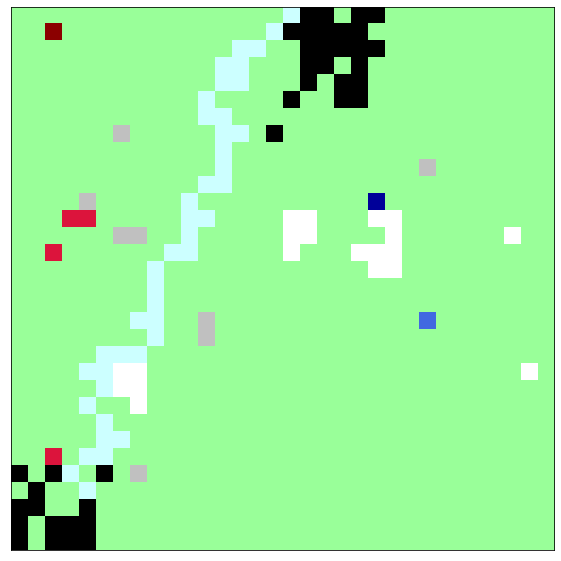

[MOVE-E] OK
ACTIVE
move_down


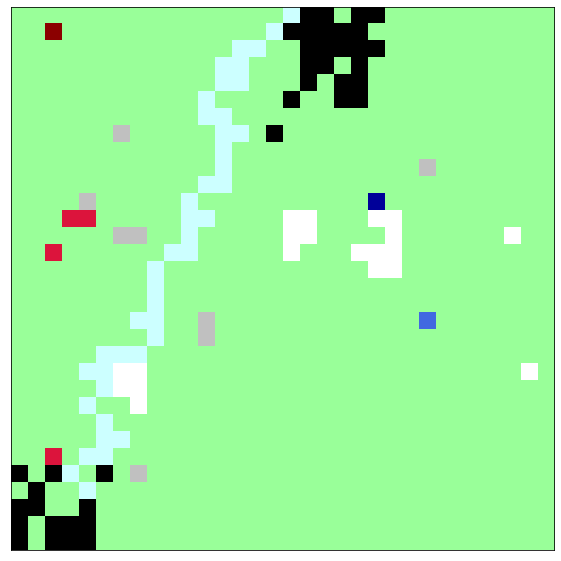

[MOVE-S] OK
ACTIVE
move_up


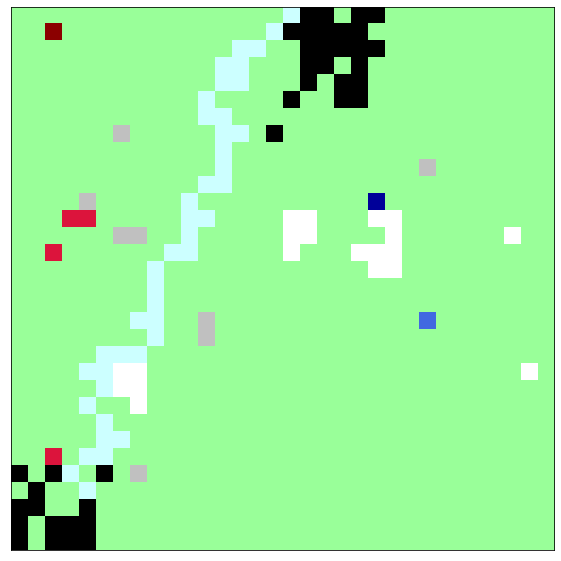

[MOVE-N] OK
ACTIVE
move_right


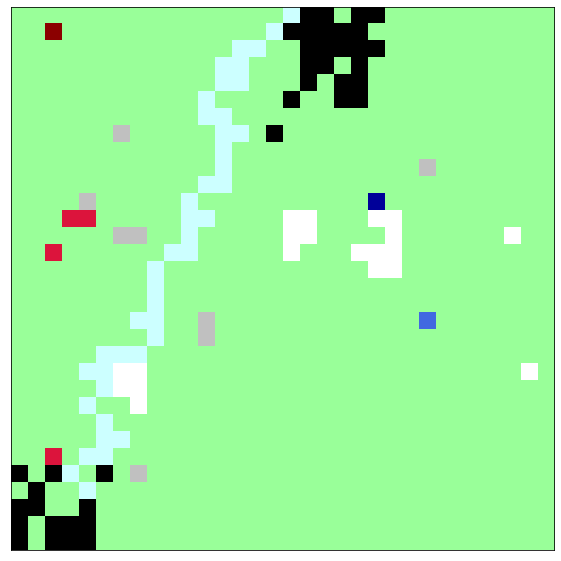

[MOVE-E] OK
ACTIVE
move_left


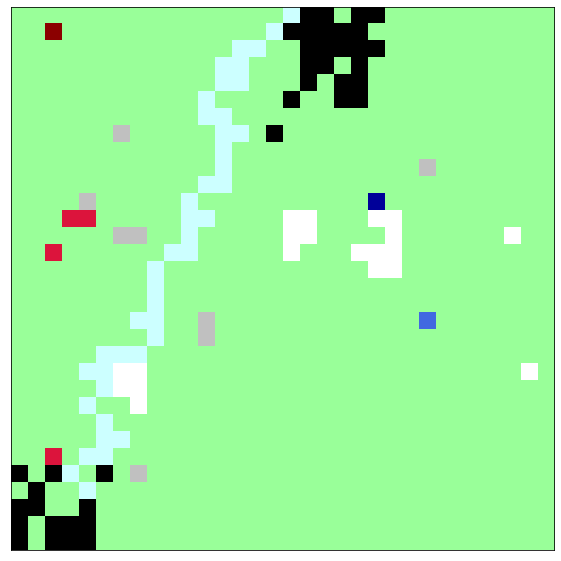

[MOVE-W] OK
ACTIVE
move_left


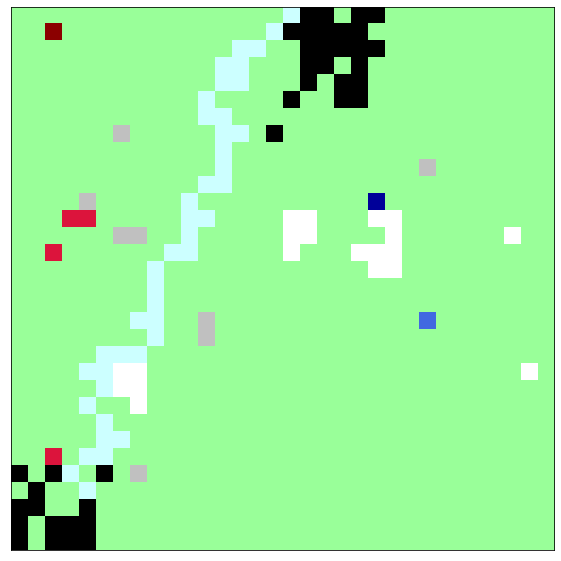

[MOVE-W] OK
ACTIVE
move_right


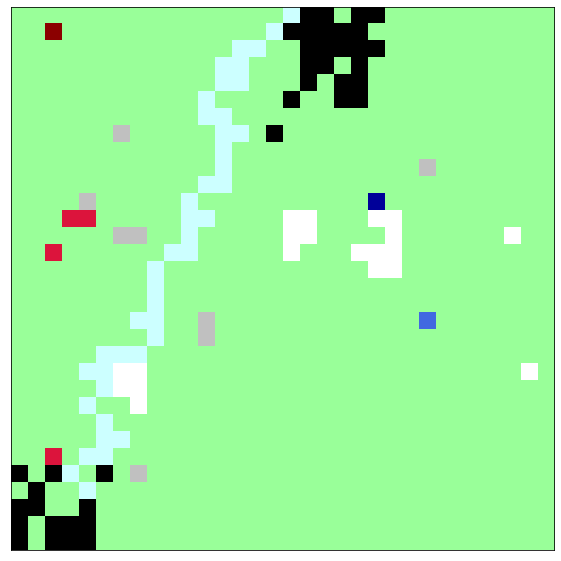

[MOVE-E] OK
ACTIVE
move_left


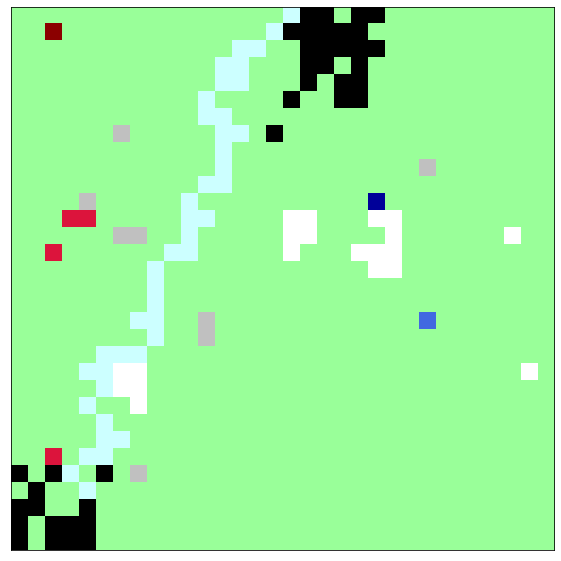

[MOVE-W] OK
ACTIVE
move_right


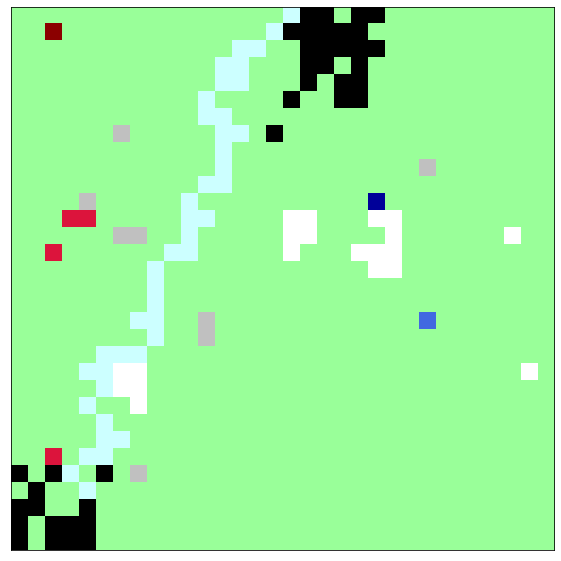

[MOVE-E] OK
ACTIVE
move_left


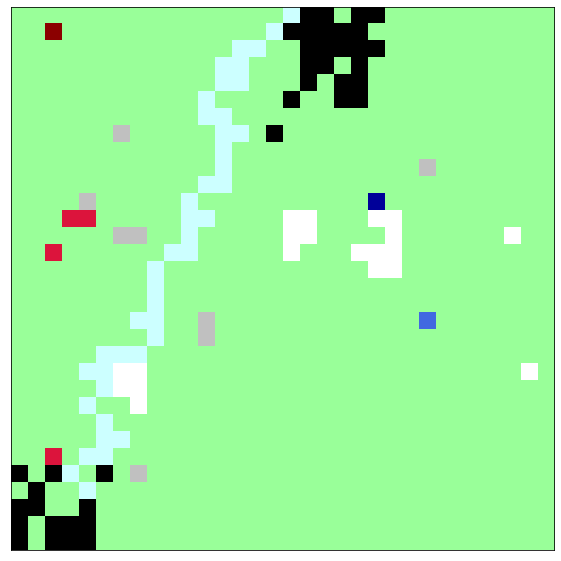

[MOVE-W] OK
ACTIVE
move_up


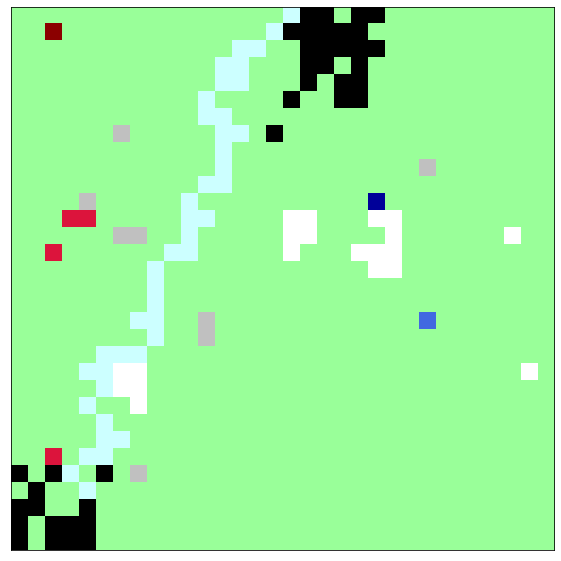

[MOVE-N] OK
ACTIVE
move_left


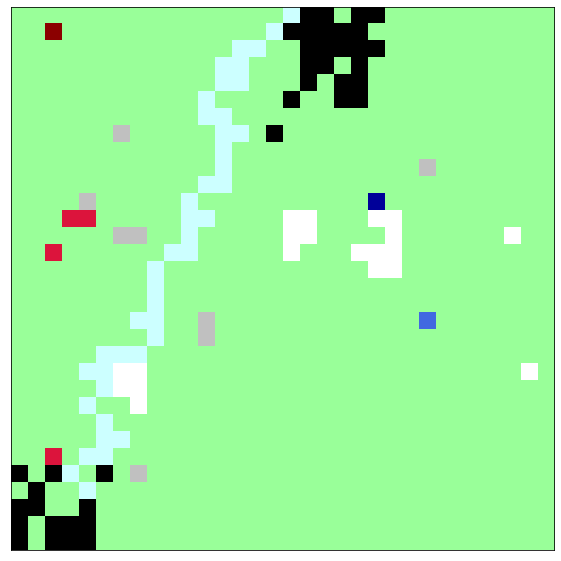

[MOVE-W] OK
ACTIVE
move_right


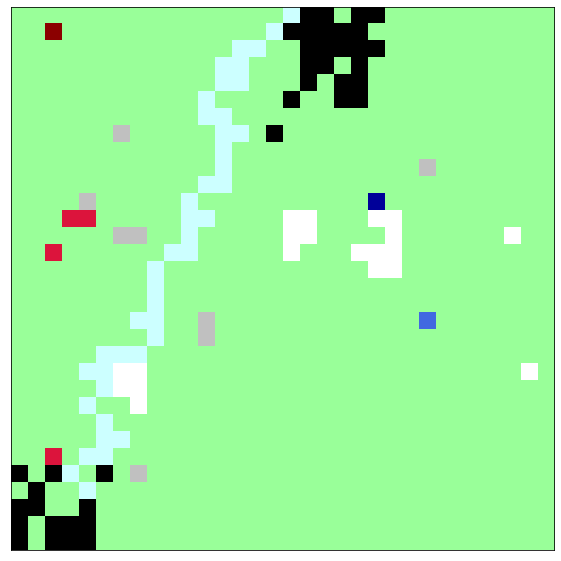

[MOVE-E] OK
ACTIVE
move_left


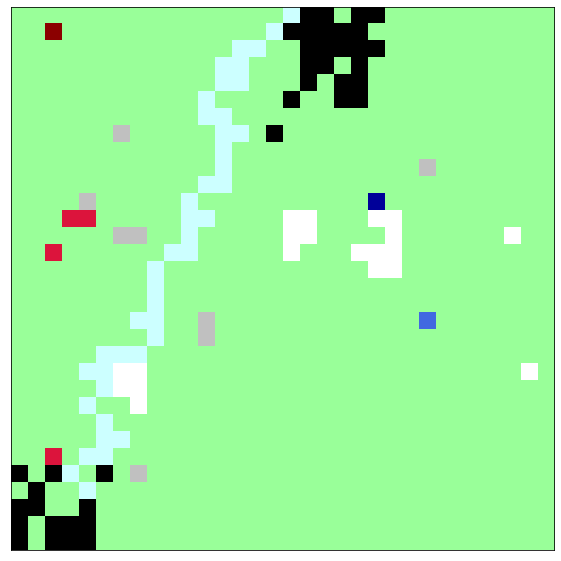

[MOVE-W] OK
ACTIVE
move_left


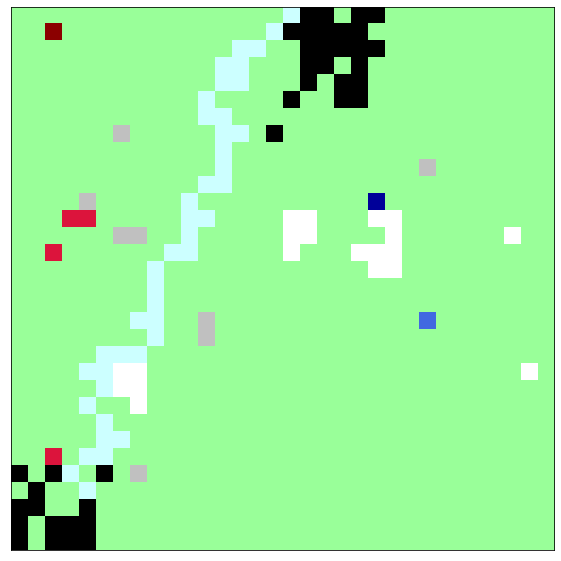

[MOVE-W] OK
ACTIVE
move_up


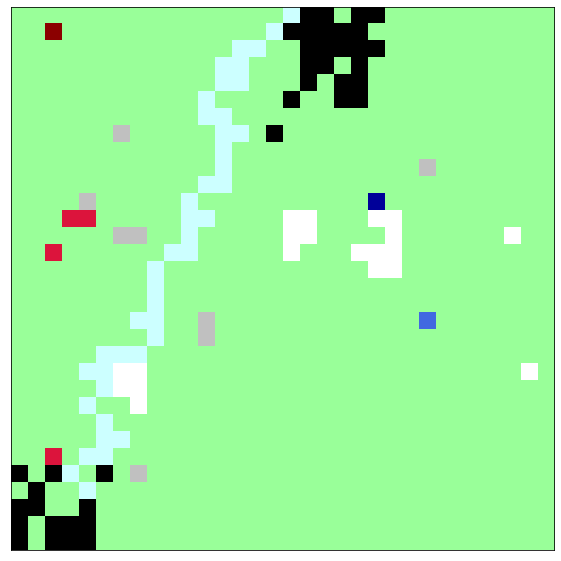

[MOVE-N] OK
ACTIVE
move_left


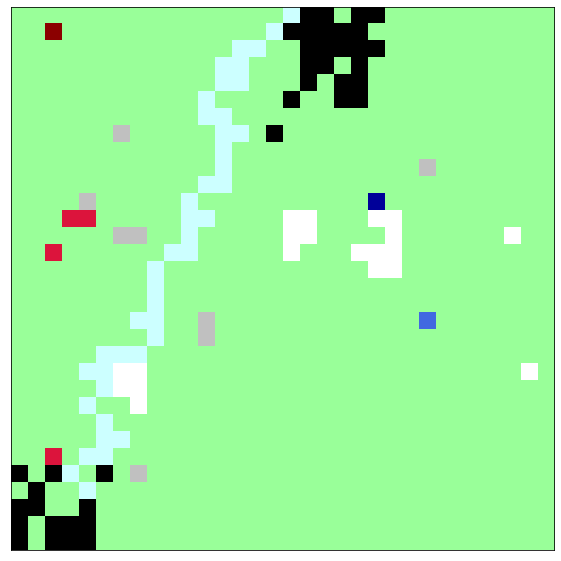

[MOVE-W] OK
ACTIVE
move_left


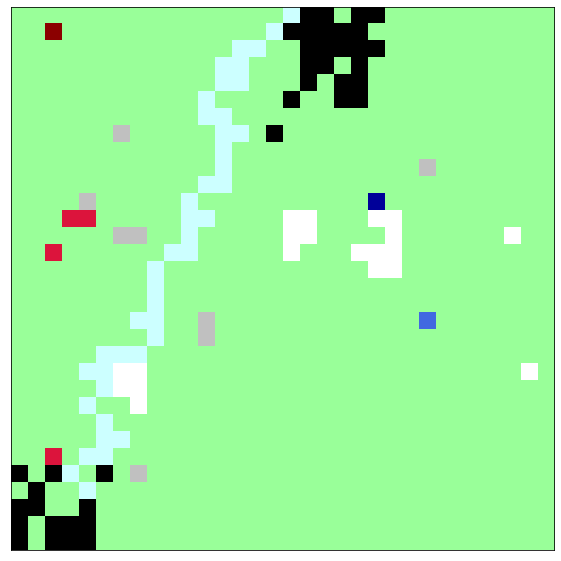

[MOVE-W] OK
ACTIVE
move_right


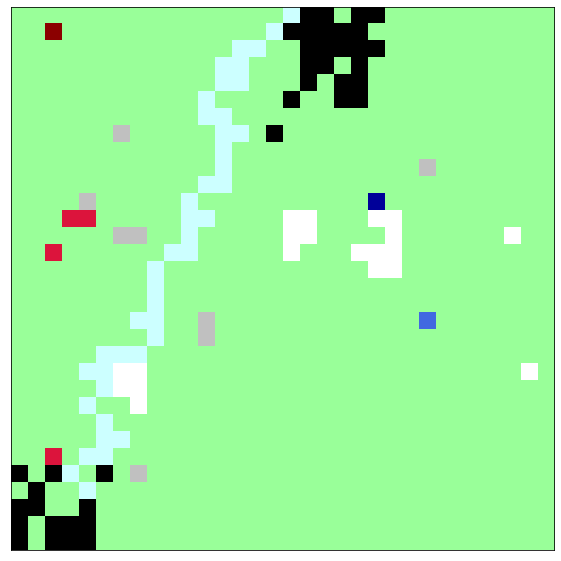

[MOVE-E] OK
ACTIVE
move_right


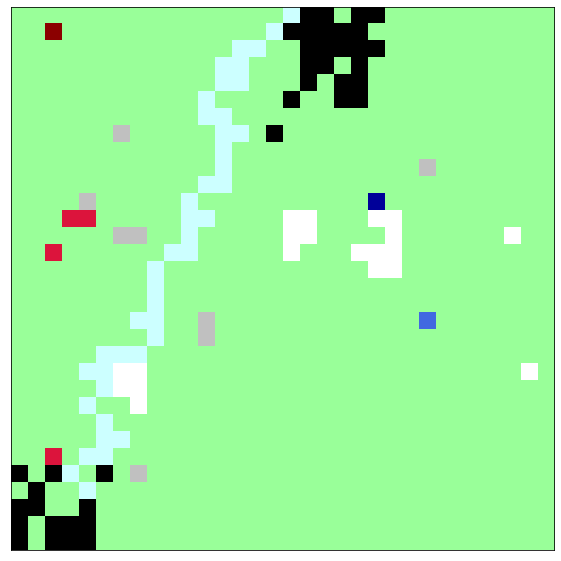

[MOVE-E] OK
ACTIVE
move_down


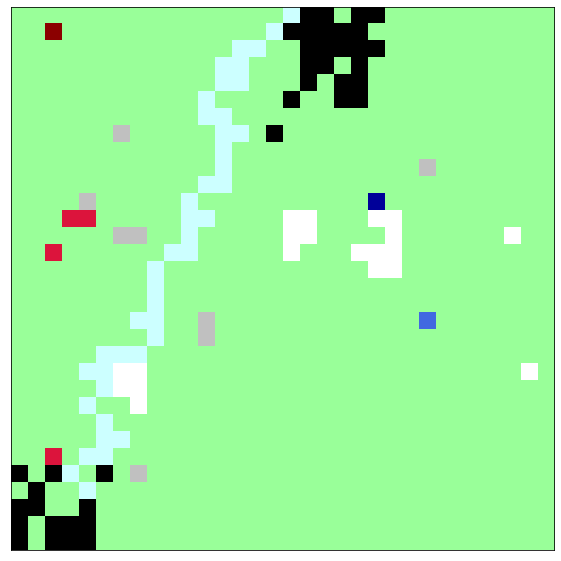

[MOVE-S] OK
ACTIVE
move_right


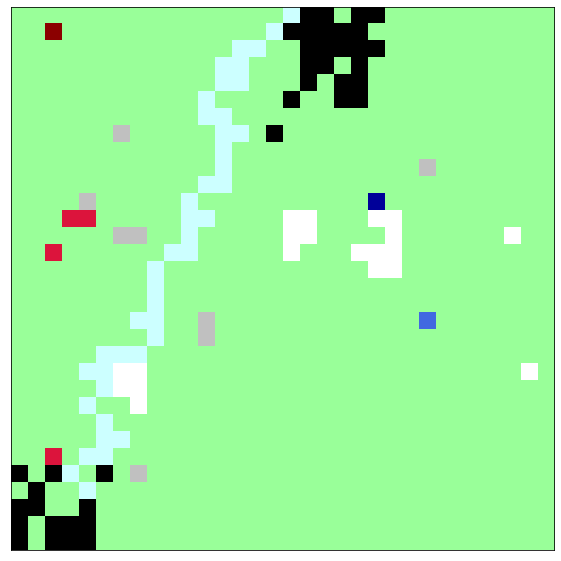

[MOVE-E] OK
ACTIVE
move_right


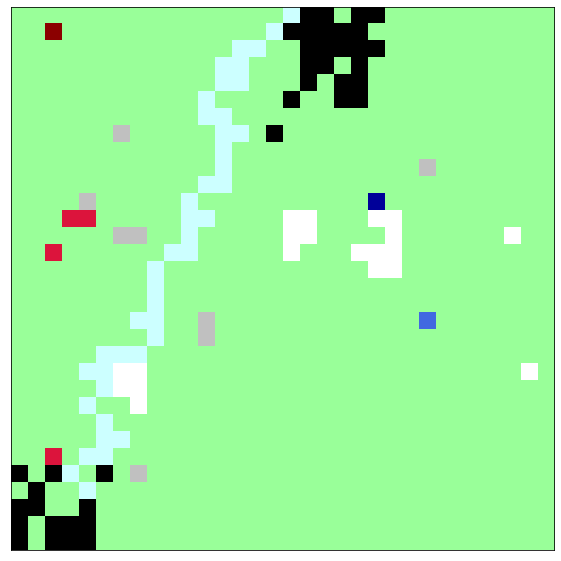

KeyboardInterrupt: ignored

In [ ]:
gameName = 'ai0-5' # INSERT GAME NAME HERE
playerName = 'AI0-JDeep'
# reloading the model
model = PPO2.load("Test1")

# Establish Connection
blaid_ch = CommunicationHandler(host, serverPort)
print(blaid_ch.host)

# Join the Game
join = blaid_ch.joinGame(gameName, playerName)
print(join)

map = blaid_ch.getMap()
status = blaid_ch.getStatus()
myPlayer = extractMyInfo(status)
blaid_chat = Chat(host, chatPort, myPlayer)
blaid_chat.join(gameName, myPlayer.team)

# read the chat until the start of the game
readMessage = blaid_chat.readChat(timeout=20)
print(readMessage)
while ('Now starting!' not in readMessage):
  nowTime = (time.time() - blaid_ch.lastAction)
  readMessage = blaid_chat.readChat(timeout=48.5-nowTime)
  if (nowTime > 48):
    print('Time > 48')
    status = blaid_ch.getStatus()
    myPlayer = extractMyInfo(status)
  print(readMessage)

print('Game has started!')
start_time = int(time.time()*1000)
myPreparedMap = prepareMap(copy.deepcopy(map), myPlayer)

# Using the trained agent
obs = np.array(prepareMap2(copy.deepcopy(map)))

# calculating time status (0 = first 8 seconds, 1 = 8-45 seconds, 2 = 45 or more seconds)
current_time = int(time.time()*1000)
time_difference = current_time - start_time # differenza in millesimi di secondo
if (time_difference < 1000 * 5): # primi 5 secondi
  current_phase = 0
elif (time_difference < 1000 * 30): # 5-30 secondi
  current_phase = 1
else:
  current_phase = 2

# line: who we are on the map, energy, x, y, loyalty, score, alive, last_update
if (myPlayer.symbol.isupper()): #team maiuscolo
  player_number = ord(myPlayer.symbol)-56
else:
  player_number = ord(myPlayer.symbol)-68
line = [[]]
line[0].append(player_number)
line[0].append(myPlayer.team)
line[0].append(myPlayer.energy)
line[0].append(myPlayer.posX)
line[0].append(myPlayer.posY)
line[0].append(myPlayer.loyalty)
line[0].append(myPlayer.score)
if (myPlayer.alive): 
  line[0].append(1)
else:
  line[0].append(0)
line[0].append(0)
line[0].append(0)
line[0].append(current_phase)

for i in range(len(line[0]),256): #servono (256 - parametri) zeri dopo self.current_player
  line[0].append(0)
obs = np.append(obs, line, axis=0) 


while(gameState(status) != 'FINISHED'):
  print('ACTIVE')
  
  action, _states = model.predict(obs)
  action = actions[action]
  print(action)
  printMap(map)

  if action == 'move_up':
    res = blaid_ch.move("N")

  elif action == 'move_down':
    res = blaid_ch.move("S")

  elif action == 'move_left':
    res = blaid_ch.move("W")
    
  elif action == 'move_right':
    res = blaid_ch.move("E")

  elif action == 'shoot_up':
    res = blaid_ch.shoot("N")

  elif action == 'shoot_down':
    res = blaid_ch.shoot("S")

  elif action == 'shoot_left':
    res = blaid_ch.shoot("W")

  elif action == 'shoot_right':
    res = blaid_ch.shoot("E")

  map = blaid_ch.getMap()
  myPreparedMap = prepareMap(copy.deepcopy(map), myPlayer)
  status = blaid_ch.getStatus()
  myPlayer = extractMyInfo(status)

# Game is over
print(extractMyInfo(status).score)

# Posting on chat
blaid_chat.post(gameName, 'gg ez')


In [ ]:
# Using the trained agent
obs = env.reset()
while True:
  action, _states = model.predict(obs)
  obs, rewards, dones, info = env.step(action)
  env.render()

In [ ]:
def judgePlayers(judged_players, players, ch):
  for player in players.values():
    if(player not in judged_players):
      ch.judge(player.name, 'AI')
      judged_players.append(player)

## Testing 

In [ ]:
# Establish Connection
ch = CommunicationHandler('margot.di.unipi.it', 8421)
print(ch.host)

# Create and Join the Game
gameName = 'test-' + ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
playerName = 'cisternino'
print('GameName:' + gameName)
crea = ch.createGame(gameName, params="Q1")
print(crea)

join = ch.joinGame(gameName, playerName)
print(join)

Connected!
margot.di.unipi.it
GameName:test-9RT7YYICW3
[CREATE] OK
['OK', 'Created\n']
[JOIN] OK
['OK', 'team=0', 'loyalty=0\n']


In [ ]:
# creo altri 4 giocatori
for i in range(15):
  chn = CommunicationHandler('margot.di.unipi.it', 8421)
  randomName = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
  joinn = chn.joinGame(gameName, randomName)
print("Players created")

Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Connected!
[JOIN] OK
Players created


In [ ]:
# Get Status and Map
status = ch.getStatus()
print(status)
print(gameState(status))
myPlayer = extractMyInfo(status)
players = extractPlayerInfo(status)

GA: name=test-9RT7YYICW3 state=LOBBY size=32 ratio=Q
ME: symbol=A name=cisternino team=0 loyalty=0 energy=256 score=0
PL: symbol=A name=cisternino team=0 x=2 y=3 state=LOBBYOWNER
PL: symbol=B name=ZO1N team=0 x=5 y=26 state=LOBBYGUEST
PL: symbol=C name=EKQ0 team=0 x=6 y=25 state=LOBBYGUEST
PL: symbol=D name=EUIR team=0 x=7 y=23 state=LOBBYGUEST
PL: symbol=E name=7J5W team=0 x=1 y=5 state=LOBBYGUEST
PL: symbol=F name=HD0T team=0 x=4 y=22 state=LOBBYGUEST
PL: symbol=G name=2PBA team=0 x=7 y=29 state=LOBBYGUEST
PL: symbol=H name=KGEQ team=0 x=4 y=26 state=LOBBYGUEST
PL: symbol=a name=1AUU team=1 x=29 y=18 state=LOBBYGUEST
PL: symbol=b name=ARJK team=1 x=30 y=5 state=LOBBYGUEST
PL: symbol=c name=VQUI team=1 x=29 y=13 state=LOBBYGUEST
PL: symbol=d name=D0KG team=1 x=30 y=12 state=LOBBYGUEST
PL: symbol=e name=LO8K team=1 x=25 y=24 state=LOBBYGUEST
PL: symbol=f name=Y0HW team=1 x=27 y=16 state=LOBBYGUEST
PL: symbol=g name=HD0M team=1 x=27 y=6 state=LOBBYGUEST
PL: symbol=h name=4ZDQ team=1 x=2

In [ ]:
map = ch.getMap()
printMatrix(map)

['.', '.', '.', '.', '.', '#', '#', '#', '#', '#', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '#', '#', '#', '#', '.', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '&', '&', '.', '.']
['.', '.', 'A', '.', '#', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '&', '&', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', 'E', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '&', '&', '.', '.', '.', '$', '.', '.', '.', '.', '.', '.', '.', '.', 'b', '.']
['#', '.', '.', '.', '.', '#', '.'

In [ ]:
prepMap = prepareMap(copy.deepcopy(map), myPlayer)
prepMap3 = prepareMap3(copy.deepcopy(map), myPlayer, players, size=(32,32))

In [ ]:
printMatrix(prepMap3)

[1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 21, 1, 1, 21, 1]
[1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 21, 1, 1, 21, 1]
[1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 21, -2, -2, 21, 1]
[1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 21, 11, 21, 21, 1]
[1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -2, -2, 1, 1, 1, 1, 1, 1, 1, 11, 1, 21, 11, 21, 21, 1]
[1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -2, -2, 13.0, 14.5, 16.0, 17.5, 19.0, 20.5, 22.0, 33.5, 25.0, 46.5, 38.0, 49.5, 41, 29.5]
[-1, 1, 1, 1, 1, -1, 11, 11, 11, 11, 11, 11, 11, 11, 11.5, 13.0, 14.5, 16.0, 17.5, 19.0, 20.5, 22.0, 23.5, 25.0, 26.5, 38.0, 29.5, 31, 39.5, 48.0, 46.5, 25.0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 1, 21, 11, 21, 21, 1]
[1, 1, 1, 1, -1, -1, 1, 1, -5, 1, 1, 1, -2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
posY, posX = findOnMap(map, 'A')
flagY, flagX = findOnMap(map, myPlayer.enemyFlag)

In [ ]:
print(tempMap[0])
path1 = findPath(prepMap, posX, posY, flagX, flagY)
print(path)

.....#####..#...................
......####......................
.....####.##................&&..
..A.#..#........................
....##..........&&..............
.E..#...........&&...$........b.
#....#...............$.....g....
................................
....##..X...&...................
#.##.......&&...................
##..............................
#..................&............
.#............................d.
#.###.......##...............c..
......&&....##..................
...###.........&................
........##.................f....
....##..#.......................
.....#.###...................a..
........#.......................
......##.#......................
..............!.................
....F....#............x.........
.......D#..................$$..!
..$$....##...............e..$...
......C##.......#...........$...
....HB.##.......##..$...........
.............!.##...............
.......##.....!###..........h...
...$...G......####..............
...$......

In [ ]:
print(tempMap[0])
path3 = findPath(prepMap3, posX, posY, flagX, flagY)
print(path3)

.....#####..#...................
......####......................
.....####.##................&&..
..A.#..#........................
....##..........&&..............
.E..#...........&&...$........b.
#....#...............$.....g....
................................
....##..X...&...................
#.##.......&&...................
##..............................
#..................&............
.#............................d.
#.###.......##...............c..
......&&....##..................
...###.........&................
........##.................f....
....##..#.......................
.....#.###...................a..
........#.......................
......##.#......................
..............!.................
....F....#............x.........
.......D#..................$$..!
..$$....##...............e..$...
......C##.......#...........$...
....HB.##.......##..$...........
.............!.##...............
.......##.....!###..........h...
...$...G......####..............
...$......

In [ ]:
coloredMap = buildMap(map)

In [ ]:
def printMapPath(map, size=(10,10)):
  #beautiful_map = buildMap(map)
  plt.figure(figsize=size)
  plt.imshow(map, interpolation='nearest')
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
for coord in path3[1:-1]:
  coloredMap[coord[1],coord[0]] = colors["path"]

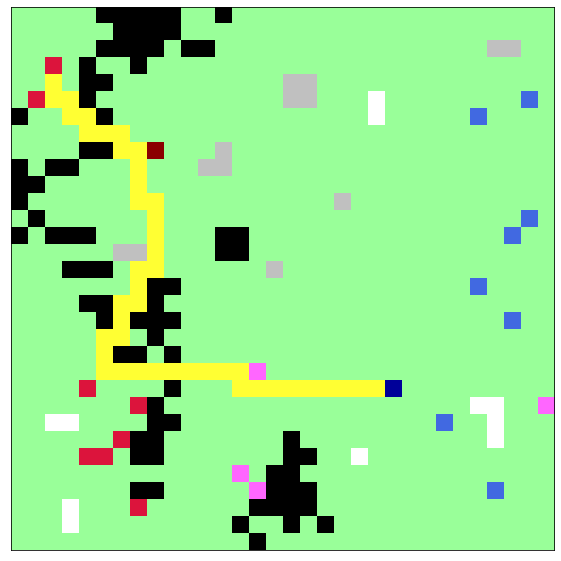

In [ ]:
printMapPath(coloredMap) # dumb path

In [ ]:
ch.startGame()

[START] OK


['OK', 'Game', 'started\n']

In [ ]:
ch.move('S')
ch.move('S')
ch.move('S')

[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK


['OK', 'moved\n']

In [ ]:
# Get Status and Map
status = ch.getStatus()
print(status)
myPlayer = extractMyInfo(status)
players = extractPlayerInfo(status)
map = updateMapFromStatus(map, myPlayer, players)

GA: name=test-RRXY2PI1DV state=ACTIVE size=32 ratio=Q
ME: symbol=a name=cisternino team=1 loyalty=1 energy=256 score=0
PL: symbol=A name=6P64 team=0 x=2 y=30 state=ACTIVE
PL: symbol=B name=K3RP team=0 x=1 y=14 state=ACTIVE
PL: symbol=a name=cisternino team=1 x=26 y=6 state=ACTIVE
PL: symbol=b name=MGJR team=1 x=28 y=30 state=ACTIVE
PL: symbol=c name=M0F1 team=1 x=26 y=11 state=ACTIVE
PL: symbol=d name=K3AH team=1 x=27 y=23 state=ACTIVE
PL: symbol=e name=K6WV team=1 x=27 y=18 state=ACTIVE

pos:(26,6)


In [ ]:
printMatrix(map)

['#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['$', '$', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'l', '.', '.', '.']
['.', '$', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'g', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '$', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'x', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '&', '.', '.', '.', '.', '.', '.', 'X', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '&', '.', 'c', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '&', '&', '.', '.', '.']
['#', '.', '.', '.', '.', '.', '.'

In [ ]:
posY, posX = findOnMap(map, 'a')
posY, posX

(6, 26)

In [ ]:
printMatrix(map)

['@', '@', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '$', '$', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '$', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '$', '$', '.', '.', '#', '.', '.', '.', '&', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['.', '.', '.', '$', '$', '.', '.'

In [ ]:
for player in players.values():
  res = ch.judge(player.name, 'AI')
  print(res)

[JUDGE-JNRP] OK
['OK', 'Noted.\n']
[JUDGE-E0L8] OK
['OK', 'Noted.\n']
[JUDGE-QD6D] OK
['OK', 'Noted.\n']
[JUDGE-VTTT] OK
['OK', 'Noted.\n']


In [ ]:
# PER ORA VA CAMBIATO A MANO OGNI VOLTA!!!
flagY, flagX = findOnMap(map,myPlayer.enemyFlag)
posY, posX = findOnMap(map,myPlayer.symbol)
print(posY)
print(posX)

12
8


In [ ]:
myPlayer.symbol

'A'

In [ ]:
print(tempMap[0])
path = findPath(prepMap, posX, posY, flagX, flagY)
print(path)

~...............................
.................###............
................................
.................#...##.........
.....................##.........
.......$........##...#....#.....
~...............##...#.#...#....
................###...###.#.#...
...................##.###.....#.
.....&............#...##...#.##.
...B.&.........$.......#..#....#
...............$.......#.....#..
.....X&A.......$............#...
................................
...........................#....
.............#..............###.
............#.........x...#..##.
...........................####.
..................b....#&..####.
.............&.........#&...##.#
......................##......#.
......................#.........
.............$$$$$...#.a........
....$$.........&$...............
...............&..c##...........
@@..............................
@@.................#............
@..................#............
....................&...........
@@..............................
@.........

In [ ]:
ch.move("N")

[MOVE-N] OK


['OK', 'moved\n']

In [ ]:
ch.move("S")

[MOVE-S] OK


['OK', 'moved\n']

In [ ]:
ch.move("W")

[MOVE-W] OK


['OK', 'moved\n']

In [ ]:
ch.move("E")

[MOVE-E] OK


['OK', 'moved\n']

In [ ]:
p = pathToCommand(ch, path)

[MOVE-S] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE-W] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-S] OK
[MOVE-W] OK
[MOVE] Done!


In [ ]:
# Get Status and Map
status = ch.getStatus()
print(status)
print(gameState(status))

GA: name=ai0-2KS7X0YS80 state=FINISHED size=32
ME: symbol=A name=cisternino team=0 loyalty=0 energy=256 score=130
PL: symbol=A name=cisternino team=0 x=22 y=18 state=ACTIVE
PL: symbol=B name=RZU9 team=0 x=7 y=21 state=ACTIVE
PL: symbol=a name=3PCH team=1 x=20 y=10 state=ACTIVE
PL: symbol=b name=BN1J team=1 x=23 y=21 state=ACTIVE
PL: symbol=c name=Y1KW team=1 x=22 y=28 state=ACTIVE

FINISHED


In [ ]:
chat = Chat(host, chatPort, myPlayer)
chat.join('4chan', 'ai0', myPlayer.team)
chat.post('ai0:0', 'testo2')

In [ ]:
string1 = '#prova @GameServer'